In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
import seaborn as sns

# Load Data

In [231]:
norm_annotations = pd.read_csv('data/annotated_aact/ner_outputs/aggregated_ner_annotations_basic_dict_mapped_19632.csv', index_col=0)
norm_annotations.head()

nct_id canonical_BioLinkBERT-base_interventions  \
0  NCT00000117          intravenous immunoglobulin|ivig   
1  NCT00000146                           corticosteroid   
2  NCT00000147                           corticosteroid   
3  NCT00000151             acetylsalicylic acid|aspirin   
4  NCT00000170                                 atropine   

    canonical_aact_interventions aact_intervention_types  \
0                 immunoglobulin                    Drug   
1  prednisone|methylprednisolone                    Drug   
2  prednisone|methylprednisolone                    Drug   
3   aspirin|acetylsalicylic acid          Procedure|Drug   
4                       atropine             Drug|Device   

               canonical_BioLinkBERT-base_conditions  \
0                  multiple sclerosis|optic neuritis   
1                  multiple sclerosis|optic neuritis   
2                  multiple sclerosis|optic neuritis   
3  diabetes mellitus|diabetic retinopathy|early d...   
4  amblyopia|anisometropia|moderate amblyopia|str...   

           canonical_aact_conditions  \
0                     optic neuritis   
1  optic neuritis|multiple sclerosis   
2  optic neuritis|multiple sclerosis   
3                          blindness   
4                          amblyopia   

                                   Disease Class  
0                         Cranial Nerve Diseases  
1  Demyelinating Diseases|Cranial Nerve Diseases  
2  Demyelinating Diseases|Cranial Nerve Diseases  
3                      Neurologic Manifestations  
4                      Neurologic Manifestations

In [233]:
norm_annotations.shape

(19632, 7)

In [235]:
trial_metadata= pd.read_csv('data/raw_aact/combined_neuro_designs_calculated_full_v2_20240701.csv')
trial_metadata['start_date'] = pd.to_datetime(trial_metadata['start_date'])
trial_metadata['start_year'] = trial_metadata['start_date'].dt.year

#print(len(trial_metadata[trial_metadata['start_year']<2024]))
#print(len(trial_metadata[trial_metadata['start_year']>=2000]))

#trial_metadata = trial_metadata[trial_metadata['start_year']<2024]
#trial_metadata = trial_metadata[trial_metadata['start_year']>=2000]

trial_metadata.head()

/var/folders/nd/2fzvhsh510gbt9x6z5pdb1gr0000gn/T/ipykernel_35625/329341566.py:1: DtypeWarning: Columns (2,7,8,18) have mixed types. Specify dtype option on import or set low_memory=False.
  trial_metadata= pd.read_csv('data/raw_aact/combined_neuro_designs_calculated_full_v2_20240701.csv')


nct_id start_date completion_date    phase overall_status  \
0  NCT00000117 1995-08-31      1997-12-31  Phase 3      Completed   
1  NCT00000117 1995-08-31      1997-12-31  Phase 3      Completed   
2  NCT00000117 1995-08-31      1997-12-31  Phase 3      Completed   
3  NCT00000117 1995-08-31      1997-12-31  Phase 3      Completed   
4  NCT00000117 1995-08-31      1997-12-31  Phase 3      Completed   

    country_name primary_purpose  allocation masking  number_of_facilities  \
0  United States       Treatment  Randomized  Double                   2.0   
1  United States       Treatment  Randomized  Double                   2.0   
2  United States       Treatment  Randomized  Double                   2.0   
3  United States       Treatment  Randomized  Double                   2.0   
4  United States       Treatment  Randomized  Double                   2.0   

   ...  months_to_report_results  number_of_primary_outcomes_to_measure  \
0  ...                       NaN                                    NaN   
1  ...                       NaN                                    NaN   
2  ...                       NaN                                    NaN   
3  ...                       NaN                                    NaN   
4  ...                       NaN                                    NaN   

   number_of_secondary_outcomes_to_measure  \
0                                      NaN   
1                                      NaN   
2                                      NaN   
3                                      NaN   
4                                      NaN   

   number_of_other_outcomes_to_measure  agency_class lead_or_collaborator  \
0                                  NaN           NIH                 lead   
1                                  NaN           NIH                 lead   
2                                  NaN           NIH                 lead   
3                                  NaN           NIH                 lead   
4                                  NaN           NIH                 lead   

                   sponsor_name                         facility_name  \
0  National Eye Institute (NEI)  Mayo Clinic, Department of Neurology   
1  National Eye Institute (NEI)                           Mayo Clinic   
2  National Eye Institute (NEI)  Mayo Clinic, Department of Neurology   
3  National Eye Institute (NEI)                           Mayo Clinic   
4  National Eye Institute (NEI)  Mayo Clinic, Department of Neurology   

         country start_year  
0  United States     1995.0  
1  United States     1995.0  
2  United States     1995.0  
3  United States     1995.0  
4  United States     1995.0  

[5 rows x 21 columns]

In [236]:
df = trial_metadata[trial_metadata['nct_id'].isin(norm_annotations['nct_id'])]

original_trials_nr = len(set(df['nct_id']))
print(original_trials_nr)

# Drop duplicates based on 'nct_id' and 'start_year' columns
df_unique = df.drop_duplicates(subset=['nct_id', 'start_year'])
print("missing start year: ", df_unique['start_year'].isna().sum())

df = df[df['start_year']<2024]
trials_before_2024 = len(set(df['nct_id']))
print("start year before 2024: ", original_trials_nr - trials_before_2024)

df = df[df['start_year']>=2000]
new_trials_nr = len(set(df['nct_id']))
print("start year after 2000: ", trials_before_2024 - new_trials_nr) 

print(len(set(df['nct_id'])))


trial_metadata = trial_metadata[trial_metadata['start_year']<2024]
trial_metadata = trial_metadata[trial_metadata['start_year']>=2000]

df.head()

19632
missing start year:  189
start year before 2024:  572
start year after 2000:  451
18609


nct_id start_date completion_date    phase overall_status  \
2285  NCT00000307 2003-04-30      2007-04-30  Phase 2      Completed   
2286  NCT00000307 2003-04-30      2007-04-30  Phase 2      Completed   
2287  NCT00000307 2003-04-30      2007-04-30  Phase 2      Completed   
2288  NCT00000307 2003-04-30      2007-04-30  Phase 2      Completed   
2289  NCT00000307 2003-04-30      2007-04-30  Phase 2      Completed   

       country_name primary_purpose allocation masking  number_of_facilities  \
2285  United States       Treatment        NaN     NaN                   1.0   
2286  United States       Treatment        NaN     NaN                   1.0   
2287  United States       Treatment        NaN     NaN                   1.0   
2288  United States       Treatment        NaN     NaN                   1.0   
2289  United States       Treatment        NaN     NaN                   1.0   

      ...  months_to_report_results  number_of_primary_outcomes_to_measure  \
2285  ...                       NaN                                    1.0   
2286  ...                       NaN                                    1.0   
2287  ...                       NaN                                    1.0   
2288  ...                       NaN                                    1.0   
2289  ...                       NaN                                    1.0   

      number_of_secondary_outcomes_to_measure  \
2285                                      NaN   
2286                                      NaN   
2287                                      NaN   
2288                                      NaN   
2289                                      NaN   

      number_of_other_outcomes_to_measure  agency_class lead_or_collaborator  \
2285                                  NaN           NIH                 lead   
2286                                  NaN         OTHER         collaborator   
2287                                  NaN           NIH                 lead   
2288                                  NaN         OTHER         collaborator   
2289                                  NaN           NIH                 lead   

                                 sponsor_name  \
2285  National Institute on Drug Abuse (NIDA)   
2286                      University of Texas   
2287  National Institute on Drug Abuse (NIDA)   
2288                      University of Texas   
2289  National Institute on Drug Abuse (NIDA)   

                                  facility_name        country start_year  
2285  University of Texas Health Science Center  United States     2003.0  
2286  University of Texas Health Science Center  United States     2003.0  
2287  University of Texas Health Science Center  United States     2003.0  
2288  University of Texas Health Science Center  United States     2003.0  
2289  University of Texas Health Science Center  United States     2003.0  

[5 rows x 21 columns]

In [237]:
len(set(df['nct_id']))

18609

In [238]:
df.columns

Index(['nct_id', 'start_date', 'completion_date', 'phase', 'overall_status',
       'country_name', 'primary_purpose', 'allocation', 'masking',
       'number_of_facilities', 'were_results_reported',
       'months_to_report_results', 'number_of_primary_outcomes_to_measure',
       'number_of_secondary_outcomes_to_measure',
       'number_of_other_outcomes_to_measure', 'agency_class',
       'lead_or_collaborator', 'sponsor_name', 'facility_name', 'country',
       'start_year'],
      dtype='object')

In [239]:
df_for_trend = df[['nct_id','start_date','start_year','allocation','masking', 'were_results_reported', 'lead_or_collaborator', 'sponsor_name', 'agency_class']].drop_duplicates()

In [240]:
def replace_agency_class(row):
    if 'university' in row['sponsor_name'].lower() or ('universita' in row['sponsor_name'].lower()) \
    or ('université' in row['sponsor_name'].lower()) or ('universität' in row['sponsor_name'].lower()) \
    or ('universiteit' in row['sponsor_name'].lower())or ('universidad' in row['sponsor_name'].lower()):
        return 'UNIVERSITY'
    elif 'hospital' in row['sponsor_name'].lower():
        return 'HOSPITAL'
    else:
        return row['agency_class']


In [329]:
def replace_agency_class(row):
    sponsor_lower = row['sponsor_name'].lower()
    
    university_keywords = ['university', 'universita', 'université', 'universität', 
                           'universiteit', 'universidad'] + ['universite', 'università', 'universiti', 'universitesi', 'universitário']
    
    hospital_keywords = ['hospital', 'hôpital', 'hopital', 'krankenhaus', 'klinikum', 
                         'ospedale', 'ziekenhuis', 'sanatorio', 'medical center', 
                         'health system', 'memorial', 'infirmary', 'med center', 
                         'centro médico']
    
    # Then check if it only contains university terms
    if any(term in sponsor_lower for term in university_keywords):
        return 'UNIVERSITY'
    # Then check if it only contains hospital terms
    elif any(term in sponsor_lower for term in hospital_keywords):
        return 'HOSPITAL'
    # Otherwise, return the original agency_class
    else:
        return row['agency_class']

df_for_trend['agency_class_refined'] = df_for_trend.apply(replace_agency_class, axis=1)

In [331]:
df_for_trend_lead = df_for_trend[df_for_trend['lead_or_collaborator']=='lead']

In [396]:
df_for_trend_lead.head()

nct_id start_date  start_year  allocation    masking  \
2285  NCT00000307 2003-04-30      2003.0         NaN        NaN   
2379  NCT00000333 2001-05-31      2001.0         NaN        NaN   
2712  NCT00000428 2000-09-30      2000.0  Randomized  Quadruple   
2754  NCT00000439 2000-10-31      2000.0  Randomized  Quadruple   
6266  NCT00001956 2000-01-31      2000.0         NaN        NaN   

      were_results_reported lead_or_collaborator  \
2285                  False                 lead   
2379                  False                 lead   
2712                  False                 lead   
2754                  False                 lead   
6266                  False                 lead   

                                           sponsor_name agency_class  \
2285            National Institute on Drug Abuse (NIDA)          NIH   
2379            National Institute on Drug Abuse (NIDA)          NIH   
2712                               Tufts Medical Center        OTHER   
2754  National Institute on Alcohol Abuse and Alcoho...          NIH   
6266  National Institute of Dental and Craniofacial ...          NIH   

     agency_class_refined  
2285                  NIH  
2379                  NIH  
2712             HOSPITAL  
2754                  NIH  
6266                  NIH

In [335]:
df_for_trend_lead[df_for_trend_lead['nct_id']=='NCT05883540']

nct_id start_date  start_year  allocation    masking  \
9155179  NCT05883540 2023-09-30      2023.0  Randomized  Quadruple   

         were_results_reported lead_or_collaborator  \
9155179                  False                 lead   

                                    sponsor_name agency_class  \
9155179  University Hospital, Basel, Switzerland        OTHER   

        agency_class_refined  
9155179           UNIVERSITY

In [337]:
df_for_trend_lead_new_sposnsor = df_for_trend_lead[df_for_trend_lead['agency_class']!=df_for_trend_lead['agency_class_refined']]
df_for_trend_lead_uni = df_for_trend_lead_new_sposnsor[df_for_trend_lead_new_sposnsor['agency_class_refined']=='UNIVERSITY']
df_for_trend_lead_hospital = df_for_trend_lead_new_sposnsor[df_for_trend_lead_new_sposnsor['agency_class_refined']=='HOSPITAL']

df_for_trend_lead_new_sposnsor.shape, df_for_trend_lead_uni.shape, df_for_trend_lead_hospital.shape

((7771, 10), (5982, 10), (1789, 10))

In [339]:
df_for_trend_lead_not_uni = df_for_trend_lead[df_for_trend_lead['agency_class_refined']!='UNIVERSITY']
df_for_trend_lead_not_uni[df_for_trend_lead_not_uni['sponsor_name'].str.contains("Univ")]

nct_id start_date  start_year      allocation  \
5478963  NCT01874028 2013-05-31      2013.0             NaN   
6410696  NCT02426905 2016-01-31      2016.0  Non-Randomized   

                   masking  were_results_reported lead_or_collaborator  \
5478963  None (Open Label)                  False                 lead   
6410696  None (Open Label)                  False                 lead   

        sponsor_name agency_class agency_class_refined  
5478963    Univar BV     INDUSTRY             INDUSTRY  
6410696    Univar BV     INDUSTRY             INDUSTRY

In [355]:
df_for_trend_lead[df_for_trend_lead['sponsor_name'].str.contains("sanatorio")]

Empty DataFrame
Columns: [nct_id, start_date, start_year, allocation, masking, were_results_reported, lead_or_collaborator, sponsor_name, agency_class, agency_class_refined]
Index: []

In [347]:
df_sample_uni = df_for_trend_lead_uni.sample(n=min(100, len(df_for_trend_lead_uni)), random_state=42)
df_sample_hospital = df_for_trend_lead_hospital.sample(n=min(100, len(df_for_trend_lead_hospital)), random_state=42)


In [349]:
df_sample_uni.to_csv("analysis/sponsor_name_assignment/df_sample_uni_100_v2.csv")
df_sample_hospital.to_csv("analysis/sponsor_name_assignment/df_sample_hospital_100_v2.csv")

In [357]:
df_for_trend_lead.to_csv("data/clintrials_data_to_analyse_for_trends_20250219.csv")

# Descriptive Stats

## General

In [248]:
# Convert date columns to datetime
df['start_date'] = pd.to_datetime(df['start_date'])
df['completion_date'] = pd.to_datetime(df['completion_date'])

# Extract year component and create new columns
df['start_year'] = df['start_date'].dt.year
df['completion_year'] = df['completion_date'].dt.year

In [249]:
trial_metadata = df[['nct_id','start_year', 'completion_year', 'phase', 'overall_status','primary_purpose']]

In [250]:
trial_metadata

nct_id  start_year  completion_year           phase  \
2285     NCT00000307        2003           2007.0         Phase 2   
2286     NCT00000307        2003           2007.0         Phase 2   
2287     NCT00000307        2003           2007.0         Phase 2   
2288     NCT00000307        2003           2007.0         Phase 2   
2289     NCT00000307        2003           2007.0         Phase 2   
...              ...         ...              ...             ...   
9259440  NCT06293586        2023           2024.0  Not Applicable   
9259441  NCT06293586        2023           2024.0  Not Applicable   
9259442  NCT06293586        2023           2024.0  Not Applicable   
9259443  NCT06293586        2023           2024.0  Not Applicable   
9259444  NCT06293586        2023           2024.0  Not Applicable   

        overall_status primary_purpose  
2285         Completed       Treatment  
2286         Completed       Treatment  
2287         Completed       Treatment  
2288         Completed       Treatment  
2289         Completed       Treatment  
...                ...             ...  
9259440     Recruiting      Prevention  
9259441     Recruiting      Prevention  
9259442     Recruiting      Prevention  
9259443     Recruiting      Prevention  
9259444     Recruiting      Prevention  

[8263406 rows x 6 columns]

### Primary Purpose & Status

18316


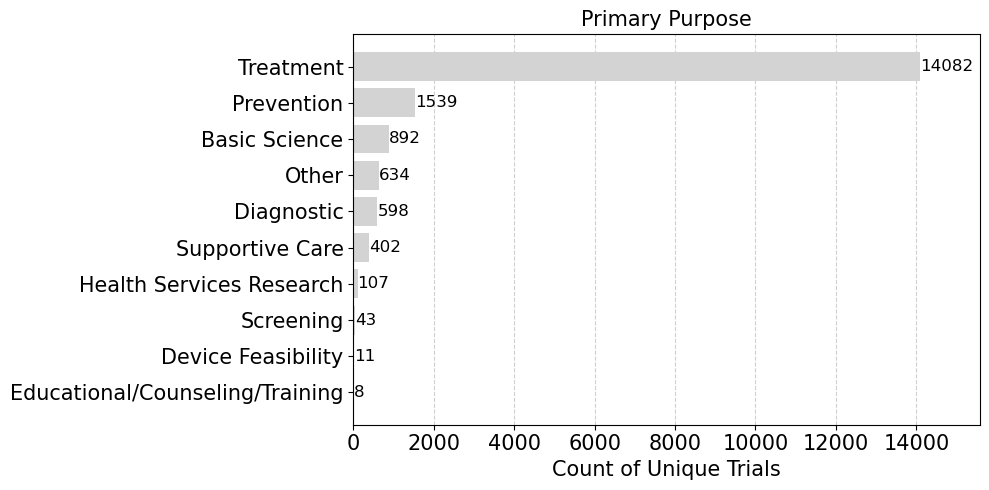

In [223]:
# Keeping only unique nct_id, phase pairs
unique_pairs_phase = trial_metadata[['nct_id', 'primary_purpose']].drop_duplicates()

# Counting the number of nct_ids per phase type
phase_type_counts = unique_pairs_phase['primary_purpose'].value_counts()
phase_type_counts = phase_type_counts.sort_values(ascending=True)
print(sum(phase_type_counts))

# Create a horizontal bar chart for the top 10 data types
plt.figure(figsize=(10, 5))
bars = plt.barh(phase_type_counts.index, phase_type_counts, color='lightgrey',zorder=2)

# Add labels to each bar
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height() / 2, f'{width}', va='center', fontsize=12)
    
plt.tick_params(axis='y', labelsize=15)
plt.tick_params(axis='x', labelsize=15)
plt.grid(axis='x', linestyle='--', alpha=0.6, zorder=1)
plt.xlabel('Count of Unique Trials', fontsize=15)
plt.title('Primary Purpose', fontsize=15)
plt.xlim(0, max(phase_type_counts)+1500) # Adjusted to max count for relevancy
plt.tight_layout()

# Save the plot to a local folder
plt.savefig(f'viz/trial_characteristics/general/primary_purpose_{len(unique_pairs_phase)}.pdf')

# Display the chart
plt.show()

18609


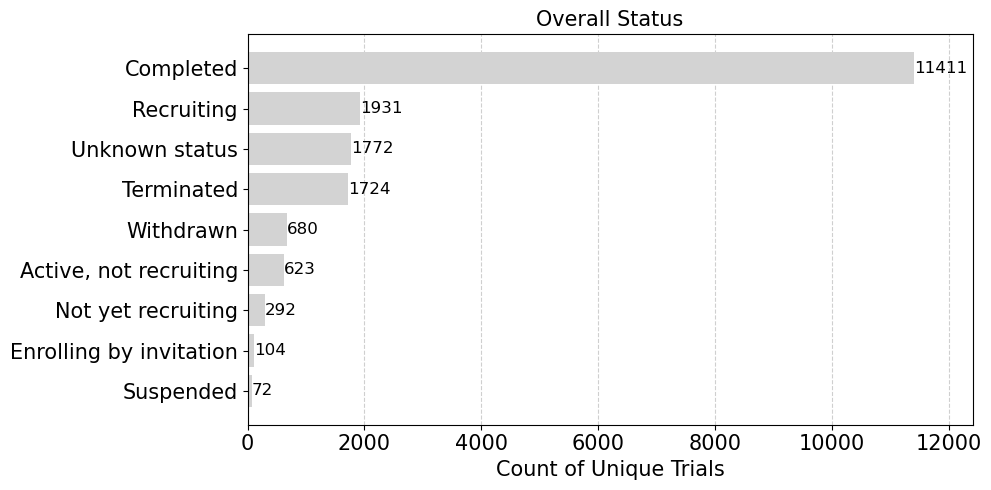

In [224]:
# Keeping only unique nct_id, phase pairs
unique_pairs_phase = trial_metadata[['nct_id', 'overall_status']].drop_duplicates()

# Counting the number of nct_ids per phase type
phase_type_counts = unique_pairs_phase['overall_status'].value_counts()
phase_type_counts = phase_type_counts.sort_values(ascending=True)
print(sum(phase_type_counts))

# Create a horizontal bar chart for the top 10 data types
plt.figure(figsize=(10, 5))
bars = plt.barh(phase_type_counts.index, phase_type_counts, color='lightgrey',zorder=2)

# Add labels to each bar
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height() / 2, f'{width}', va='center', fontsize=12)
    
plt.tick_params(axis='y', labelsize=15)
plt.tick_params(axis='x', labelsize=15)
plt.grid(axis='x', linestyle='--', alpha=0.6, zorder=1)
plt.xlabel('Count of Unique Trials', fontsize=15)
plt.title('Overall Status', fontsize=15)
plt.xlim(0, max(phase_type_counts)+1000) # Adjusted to max count for relevancy
plt.tight_layout()

# Save the plot to a local folder
plt.savefig(f'viz/trial_characteristics/general/trial_status_frequency_{len(unique_pairs_phase)}.png')

# Display the chart
plt.show()

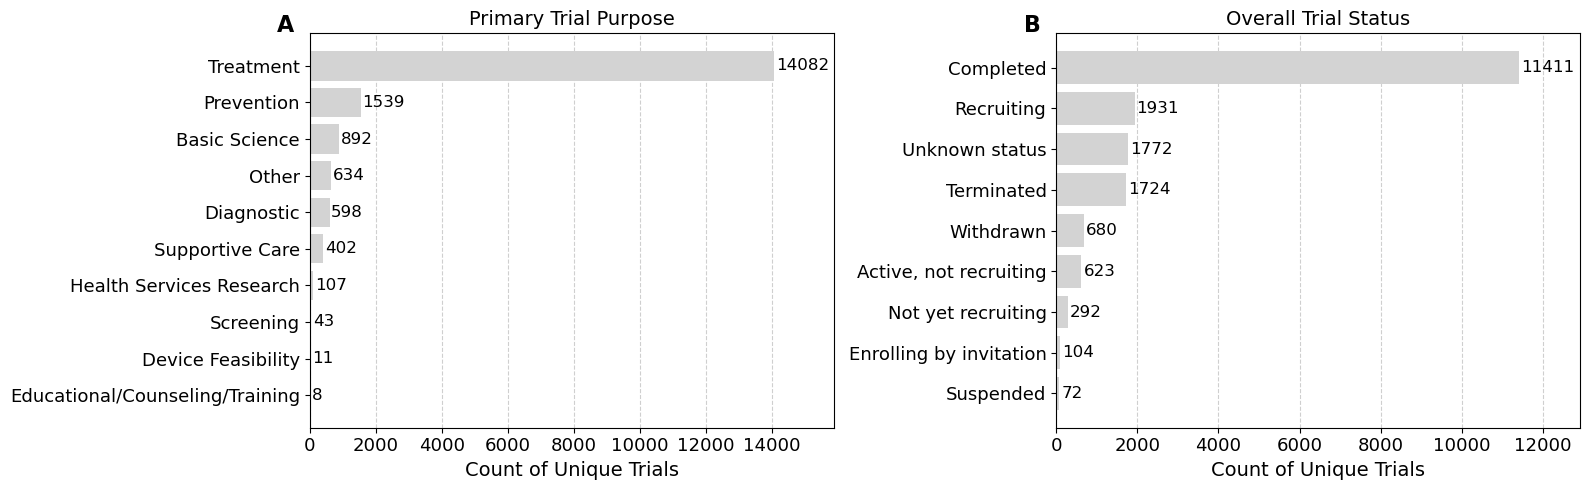

In [225]:
# Keeping only unique nct_id, primary_purpose pairs
unique_pairs_purpose = trial_metadata[['nct_id', 'primary_purpose']].drop_duplicates()

# Counting the number of nct_ids per primary purpose type
purpose_type_counts = unique_pairs_purpose['primary_purpose'].value_counts()
purpose_type_counts = purpose_type_counts.sort_values(ascending=True)

# Keeping only unique nct_id, overall_status pairs
unique_pairs_status = trial_metadata[['nct_id', 'overall_status']].drop_duplicates()

# Counting the number of nct_ids per overall status type
status_type_counts = unique_pairs_status['overall_status'].value_counts()
status_type_counts = status_type_counts.sort_values(ascending=True)

# Create a figure with two horizontal bar charts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Plot for Primary Purpose
ax1.barh(purpose_type_counts.index, purpose_type_counts, color='lightgrey', zorder=2)
for i, v in enumerate(purpose_type_counts):
    ax1.text(v + 50, i, str(v), va='center', color='black', fontsize=12)
ax1.set_title('Primary Trial Purpose', fontsize=14)
ax1.set_xlabel('Count of Unique Trials', fontsize=14)
ax1.set_xlim(0, max(purpose_type_counts)+1500)  # Adjusting the x limits for visibility
ax1.grid(axis='x', linestyle='--', alpha=0.6, zorder=1)
ax1.set_xlim(0, max(purpose_type_counts)+1800) # Adjusted to max count for relevancy
ax1.tick_params(axis='both', labelsize=13)  # Increase tick label size
ax1.text(-0.03, 1.05, 'A', transform=ax1.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

# Plot for Overall Status
ax2.barh(status_type_counts.index, status_type_counts, color='lightgrey', zorder=2)
for i, v in enumerate(status_type_counts):
    ax2.text(v + 50, i, str(v), va='center', color='black', fontsize=12)
ax2.set_title('Overall Trial Status', fontsize=14)
ax2.set_xlabel('Count of Unique Trials', fontsize=14)
ax2.set_xlim(0, max(status_type_counts)+1000)  # Adjusting the x limits for visibility
ax2.grid(axis='x', linestyle='--', alpha=0.6, zorder=1)
ax2.set_xlim(0, max(status_type_counts)+1500) # Adjusted to max count for relevancy
ax2.tick_params(axis='both', labelsize=13)  # Increase tick label size
ax2.text(-0.03, 1.05, 'B', transform=ax2.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
# Adjust layout and display the plots
plt.tight_layout()
plt.show()

# Optionally save the figure to a local folder
fig.savefig(f'viz/trial_characteristics/general/trials_purpose_and_status_{len(unique_pairs_phase)}.pdf')

### Phase

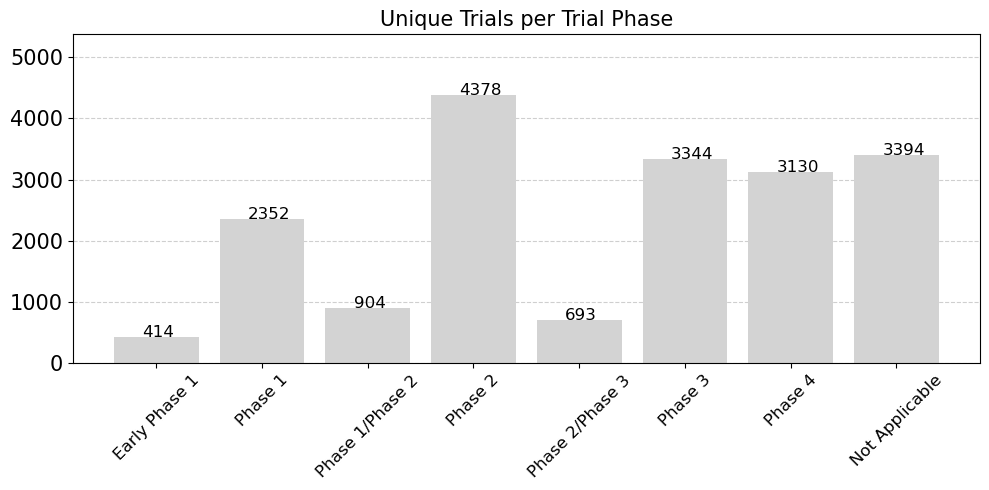

In [226]:
import matplotlib.pyplot as plt

# Defining the order of phases
phase_order = [
    'Early Phase 1', 
    'Phase 1',
    'Phase 1/Phase 2',
    'Phase 2', 
    'Phase 2/Phase 3', 
    'Phase 3', 
    'Phase 4', 
    'Not Applicable'
]

# Keeping only unique nct_id, phase pairs
unique_pairs_phase = trial_metadata[['nct_id', 'phase']].drop_duplicates()
#unique_pairs_phase['phase'].fillna('Unknown', inplace=True)
#unique_pairs_phase.replace({'': 'Unknown'}, inplace=True)

# Counting the number of nct_ids per phase type
phase_type_counts = unique_pairs_phase['phase'].value_counts()

# Reindexing phase_type_counts based on the phase_order and filling missing values with 0
phase_type_counts = phase_type_counts.reindex(phase_order, fill_value=0)

plt.figure(figsize=(10, 5))
bars = plt.bar(phase_type_counts.index, phase_type_counts, color='lightgrey', zorder=2)

# Add labels to each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/3, height, f'{height}', fontsize=12)

plt.tick_params(axis='y', labelsize=15)
plt.tick_params(axis='x', labelsize=12, rotation=45)  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.6, zorder=1)  # Change axis to 'y' for horizontal gridlines
#plt.ylabel('Unique Trials', fontsize=15)  # Changed to ylabel
plt.title('Unique Trials per Trial Phase', fontsize=15)
plt.ylim(0, max(phase_type_counts)+1000) # Adjusted to max count for relevancy
plt.tight_layout()

# Save the plot to a local folder
plt.savefig(f'viz/trial_characteristics/general/phase_frequency_{len(unique_pairs_phase)}.pdf')

# Display the chart
plt.show()


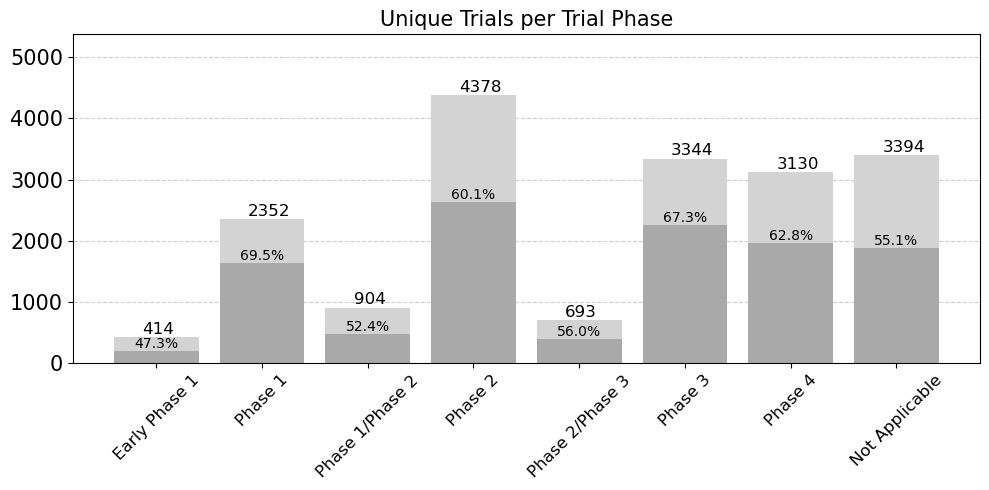

In [227]:
import matplotlib.pyplot as plt

# Defining the order of phases
phase_order = [
    'Early Phase 1', 
    'Phase 1',
    'Phase 1/Phase 2',
    'Phase 2', 
    'Phase 2/Phase 3', 
    'Phase 3', 
    'Phase 4', 
    'Not Applicable'
]

# Keeping only unique nct_id, phase pairs
unique_pairs_phase = trial_metadata[['nct_id', 'phase', 'overall_status']].drop_duplicates()

# Counting the number of nct_ids per phase type
phase_type_counts = unique_pairs_phase['phase'].value_counts()

# Reindexing phase_type_counts based on the phase_order and filling missing values with 0
phase_type_counts = phase_type_counts.reindex(phase_order, fill_value=0)

# Calculate the count and proportion of completed trials for each phase
completed_count = unique_pairs_phase[unique_pairs_phase['overall_status'] == 'Completed']['phase'].value_counts()
completed_count = completed_count.reindex(phase_order, fill_value=0)

completed_proportion = completed_count / phase_type_counts * 100

plt.figure(figsize=(10, 5))


# Adding bars for total trials
total_bars = plt.bar(phase_type_counts.index, phase_type_counts, color='lightgrey', zorder=2)
completed_bars = plt.bar(completed_count.index, completed_count, color='darkgrey', zorder=2)

# Add labels to each bar
for bar in total_bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/3, height + 50, f'{height}', fontsize=12)

# Add labels to each bar
for bar, prop in zip(completed_bars, completed_proportion):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{prop:.1f}%', ha='center', va='bottom', fontsize=10)
    
plt.tick_params(axis='y', labelsize=15)
plt.tick_params(axis='x', labelsize=12, rotation=45)  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.6, zorder=1)  # Change axis to 'y' for horizontal gridlines
#plt.ylabel('Unique Trials', fontsize=15)  # Changed to ylabel
plt.title('Unique Trials per Trial Phase', fontsize=15)
plt.ylim(0, max(phase_type_counts)+1000) # Adjusted to max count for relevancy
plt.tight_layout()

# Save the plot to a local folder
plt.savefig(f'viz/trial_characteristics/general/completed_by_phase_frequency_{len(unique_pairs_phase)}.pdf')

# Display the chart
plt.show()


### Start/ Completion Years

In [228]:
trial_metadata

nct_id  start_year  completion_year           phase  \
2285     NCT00000307        2003           2007.0         Phase 2   
2286     NCT00000307        2003           2007.0         Phase 2   
2287     NCT00000307        2003           2007.0         Phase 2   
2288     NCT00000307        2003           2007.0         Phase 2   
2289     NCT00000307        2003           2007.0         Phase 2   
...              ...         ...              ...             ...   
9259440  NCT06293586        2023           2024.0  Not Applicable   
9259441  NCT06293586        2023           2024.0  Not Applicable   
9259442  NCT06293586        2023           2024.0  Not Applicable   
9259443  NCT06293586        2023           2024.0  Not Applicable   
9259444  NCT06293586        2023           2024.0  Not Applicable   

        overall_status primary_purpose  
2285         Completed       Treatment  
2286         Completed       Treatment  
2287         Completed       Treatment  
2288         Completed       Treatment  
2289         Completed       Treatment  
...                ...             ...  
9259440     Recruiting      Prevention  
9259441     Recruiting      Prevention  
9259442     Recruiting      Prevention  
9259443     Recruiting      Prevention  
9259444     Recruiting      Prevention  

[8263406 rows x 6 columns]

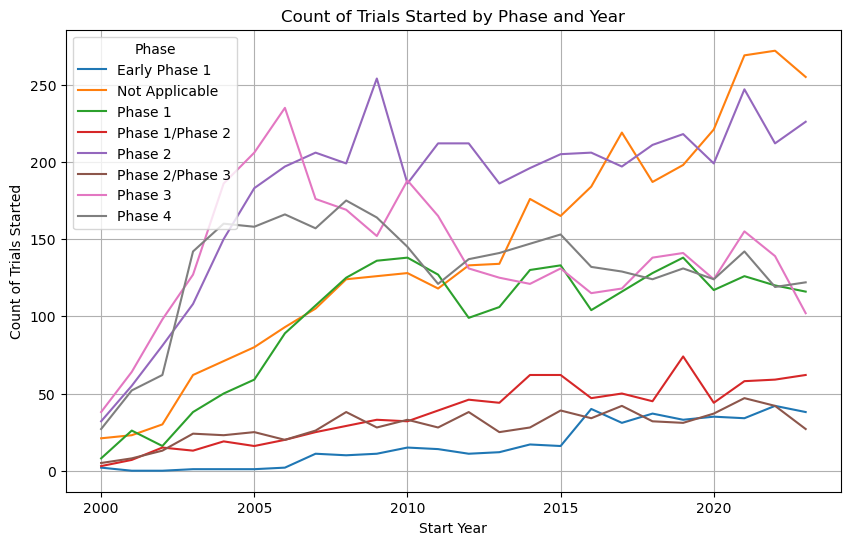

In [229]:
filtered_data = trial_metadata[['nct_id', 'phase', 'start_year']][trial_metadata['start_year'] < 2024].drop_duplicates()

# Grouping data by phase and start year, then counting the number of trials for each group
trial_counts = filtered_data.groupby(['phase', 'start_year']).size().unstack(fill_value=0)

# Plotting the line chart for each phase
plt.figure(figsize=(10, 6))
for phase in trial_counts.index:
    plt.plot(trial_counts.columns, trial_counts.loc[phase], label=phase)

# Adding labels, legend, and title
plt.xlabel('Start Year')
plt.ylabel('Count of Trials Started')
plt.title('Count of Trials Started by Phase and Year')
plt.legend(title='Phase')
plt.grid(True)

# Set x-axis tick labels to every 5 years
plt.xticks(np.arange(min(trial_counts.columns), max(trial_counts.columns)+1, 5))

plt.savefig(f'viz/trial_characteristics/general/phase_over_time_{len(unique_pairs_phase)}.pdf')

# Show plot
plt.show()

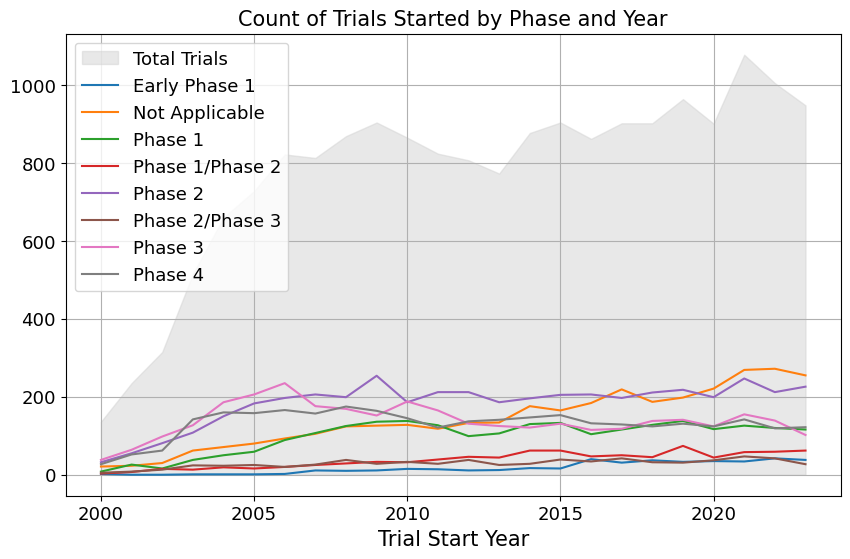

In [230]:
# Assuming 'trial_metadata' and previous preprocessing steps have been properly executed
filtered_data = trial_metadata[['nct_id', 'phase', 'start_year']][trial_metadata['start_year'] < 2024].drop_duplicates()

# Grouping data by phase and start year, then counting the number of trials for each group
trial_counts = filtered_data.groupby(['phase', 'start_year']).size().unstack(fill_value=0)

# Compute the total trials per year across all phases
total_trials_per_year = trial_counts.sum(axis=0)

# Plotting the area chart for total trials in the background
plt.figure(figsize=(10, 6))
plt.fill_between(total_trials_per_year.index, total_trials_per_year, color='lightgray', alpha=0.5, label='Total Trials')

# Plotting the line chart for each phase over the area chart
for phase in trial_counts.index:
    plt.plot(trial_counts.columns, trial_counts.loc[phase], label=phase)

# Adding labels, legend, and title
plt.xlabel('Trial Start Year',fontsize=15)
#plt.ylabel('Count of Trials Started')
plt.title('Count of Trials Started by Phase and Year', fontsize=15)
plt.legend(loc='upper left', fontsize=13)
plt.grid(True)
plt.tick_params(axis='y', labelsize=13)
plt.tick_params(axis='x', labelsize=13)  

# Set x-axis tick labels to every 5 years
plt.xticks(np.arange(min(trial_counts.columns), max(trial_counts.columns)+1, 5))

# Saving the figure to a PDF file
plt.savefig(f'viz/trial_characteristics/general/phase_over_time_with_total_{len(unique_pairs_phase)}.pdf')

# Show plot
plt.show()

In [231]:
phase_type_counts

phase
Early Phase 1       414
Phase 1            2352
Phase 1/Phase 2     904
Phase 2            4378
Phase 2/Phase 3     693
Phase 3            3344
Phase 4            3130
Not Applicable     3394
Name: count, dtype: int64

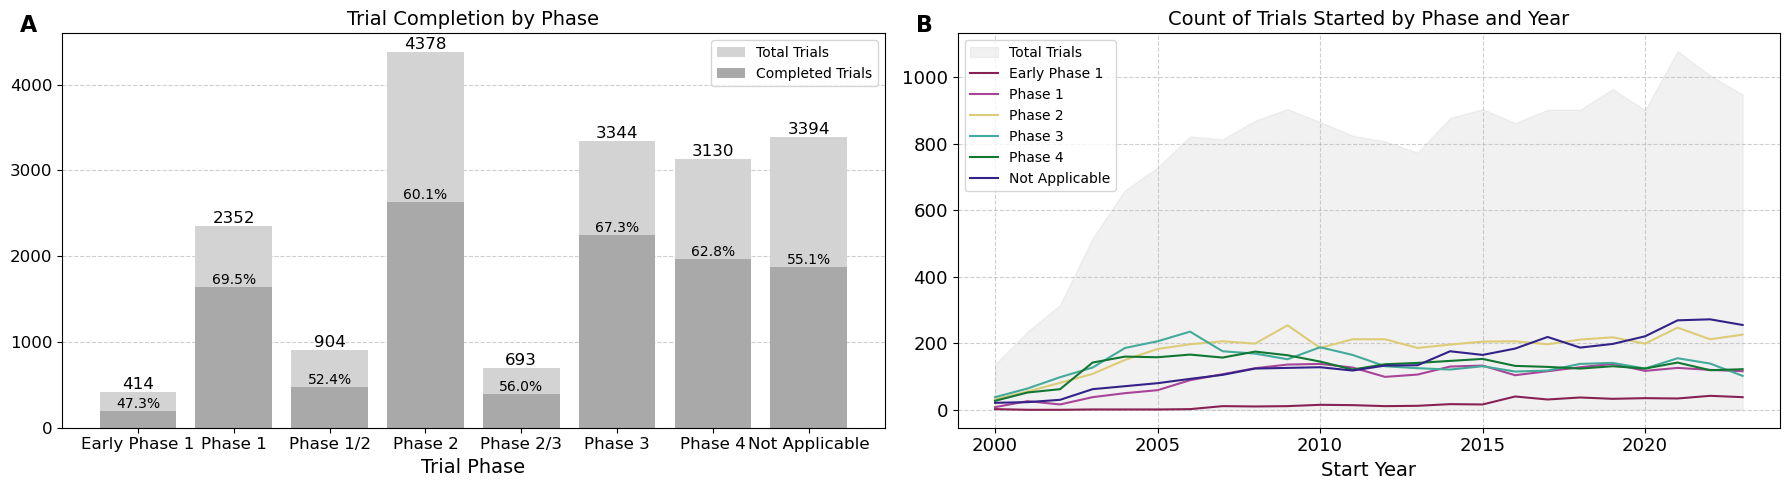

In [232]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming trial_metadata is already loaded and processed

# Define phase order and filter/preprocess the data
phase_order = [
    'Early Phase 1',
    'Phase 1',
    'Phase 1/2',
    'Phase 2',
    'Phase 2/3',
    'Phase 3',
    'Phase 4',
    'Not Applicable'
]

# Define custom colors for each phase
phase_colors = {
    'Early Phase 1': '#882255',
    'Phase 1': '#AA4499',
    'Phase 1/2': '#CC6677',
    'Phase 2': '#DDCC77',
    'Phase 2/3': '#88CCEE',
    'Phase 3': '#44AA99',
    'Phase 4': '#117733',
    'Not Applicable': '#332288'
}

# Filter and count phases and statuses
unique_pairs_phase = trial_metadata[['nct_id', 'phase', 'overall_status']].drop_duplicates()
unique_pairs_phase['phase'] = unique_pairs_phase['phase'].str.replace('/Phase ', '/', regex=False)

phase_type_counts = unique_pairs_phase['phase'].value_counts().reindex(phase_order, fill_value=0)
completed_count = unique_pairs_phase[unique_pairs_phase['overall_status'] == 'Completed']['phase'].value_counts().reindex(phase_order, fill_value=0)
completed_proportion = (completed_count / phase_type_counts * 100).fillna(0)

# Prepare data for the time series plot
filtered_data = trial_metadata[['nct_id', 'phase', 'start_year']][trial_metadata['start_year'] < 2024].drop_duplicates()
trial_counts = filtered_data.groupby(['phase', 'start_year']).size().unstack(fill_value=0)
total_trials_per_year = trial_counts.sum(axis=0)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

# First subplot - Completion by phase
total_bars = ax1.bar(phase_type_counts.index, phase_type_counts, color='lightgrey', zorder=2, label='Total Trials')
completed_bars = ax1.bar(completed_count.index, completed_count, color='darkgrey', zorder=2, label='Completed Trials')

# Label the bars
for bar, prop in zip(completed_bars, completed_proportion):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{prop:.1f}%', ha='center', va='bottom', fontsize=10)

for bar in total_bars:
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{int(bar.get_height())}', ha='center', va='bottom', fontsize=12)

ax1.set_xlabel('Trial Phase',fontsize=14)
ax1.set_title('Trial Completion by Phase',fontsize=14)
ax1.legend()
ax1.grid(axis='y', linestyle='--', alpha=0.6)
ax1.text(-0.03, 1.05, 'A', transform=ax1.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
ax1.tick_params(axis='both', labelsize=12)  # Increase tick label size

# Second subplot - Trials over time
ax2.fill_between(total_trials_per_year.index, total_trials_per_year, color='lightgray', alpha=0.3, label='Total Trials')
for phase in phase_order:
    if phase in trial_counts.index:
        ax2.plot(trial_counts.columns, trial_counts.loc[phase], label=phase, color=phase_colors[phase])

ax2.set_xlabel('Start Year', fontsize=14)
ax2.set_title('Count of Trials Started by Phase and Year',fontsize=14)
ax2.legend(loc='upper left')
ax2.grid(linestyle='--', alpha=0.6, zorder=1)
ax2.set_xticks(np.arange(min(trial_counts.columns), max(trial_counts.columns)+1, 5))
ax2.text(-0.03, 1.05, 'B', transform=ax2.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
ax2.tick_params(axis='both', labelsize=13)  # Increase tick label size
# Adjust layout and display the plots
plt.tight_layout()
plt.show()

# Optionally save the figure to a local folder
fig.savefig(f'viz/trial_characteristics/general/trials_phase_and_over_time_{len(unique_pairs_phase)}.pdf')


In [23]:
ax2.set_title('Overall Trial Status', fontsize=14)
ax2.set_xlabel('Count of Unique Trials', fontsize=14)
ax2.set_xlim(0, max(status_type_counts)+1000)  # Adjusting the x limits for visibility
ax2.grid(axis='x', linestyle='--', alpha=0.6, zorder=1)
ax2.set_xlim(0, max(status_type_counts)+1500) # Adjusted to max count for relevancy
ax2.tick_params(axis='both', labelsize=13)  # Increase tick label size

## Design Characteristics

In [24]:
df.columns

Index(['nct_id', 'start_date', 'completion_date', 'phase', 'overall_status',
       'country_name', 'primary_purpose', 'allocation', 'masking',
       'number_of_facilities', 'were_results_reported',
       'months_to_report_results', 'number_of_primary_outcomes_to_measure',
       'number_of_secondary_outcomes_to_measure',
       'number_of_other_outcomes_to_measure', 'agency_class',
       'lead_or_collaborator', 'sponsor_name', 'facility_name', 'country',
       'start_year', 'completion_year'],
      dtype='object')

In [25]:
trial_design = df[['nct_id','allocation', 'masking', 'number_of_primary_outcomes_to_measure', 'number_of_secondary_outcomes_to_measure', 'number_of_other_outcomes_to_measure','number_of_facilities', 'country', 'country_name', 'start_year']]

In [26]:
trial_design.fillna('not reported', inplace=True)
trial_design

/var/folders/nd/2fzvhsh510gbt9x6z5pdb1gr0000gn/T/ipykernel_68110/27152776.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'not reported' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  trial_design.fillna('not reported', inplace=True)
/var/folders/nd/2fzvhsh510gbt9x6z5pdb1gr0000gn/T/ipykernel_68110/27152776.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trial_design.fillna('not reported', inplace=True)


nct_id    allocation       masking  \
2285     NCT00000307  not reported  not reported   
2286     NCT00000307  not reported  not reported   
2287     NCT00000307  not reported  not reported   
2288     NCT00000307  not reported  not reported   
2289     NCT00000307  not reported  not reported   
...              ...           ...           ...   
9259440  NCT06293586    Randomized        Double   
9259441  NCT06293586    Randomized        Double   
9259442  NCT06293586    Randomized        Double   
9259443  NCT06293586    Randomized        Double   
9259444  NCT06293586    Randomized        Double   

        number_of_primary_outcomes_to_measure  \
2285                                      1.0   
2286                                      1.0   
2287                                      1.0   
2288                                      1.0   
2289                                      1.0   
...                                       ...   
9259440                                   1.0   
9259441                                   1.0   
9259442                                   1.0   
9259443                                   1.0   
9259444                                   1.0   

        number_of_secondary_outcomes_to_measure  \
2285                               not reported   
2286                               not reported   
2287                               not reported   
2288                               not reported   
2289                               not reported   
...                                         ...   
9259440                                     2.0   
9259441                                     2.0   
9259442                                     2.0   
9259443                                     2.0   
9259444                                     2.0   

        number_of_other_outcomes_to_measure number_of_facilities  \
2285                           not reported                  1.0   
2286                           not reported                  1.0   
2287                           not reported                  1.0   
2288                           not reported                  1.0   
2289                           not reported                  1.0   
...                                     ...                  ...   
9259440                                 5.0                  1.0   
9259441                                 5.0                  1.0   
9259442                                 5.0                  1.0   
9259443                                 5.0                  1.0   
9259444                                 5.0                  1.0   

               country   country_name  start_year  
2285     United States  United States        2003  
2286     United States  United States        2003  
2287     United States  United States        2003  
2288     United States  United States        2003  
2289     United States  United States        2003  
...                ...            ...         ...  
9259440          Egypt          Egypt        2023  
9259441          Egypt          Egypt        2023  
9259442          Egypt          Egypt        2023  
9259443          Egypt          Egypt        2023  
9259444          Egypt          Egypt        2023  

[8263406 rows x 10 columns]

### Allocation and Masking

In [27]:
set(trial_design['allocation'])

{'Non-Randomized', 'Randomized', 'not reported'}

In [28]:
set(trial_design['masking'])

{'Double',
 'None (Open Label)',
 'Quadruple',
 'Single',
 'Triple',
 'not reported'}

In [29]:
trial_design

nct_id    allocation       masking  \
2285     NCT00000307  not reported  not reported   
2286     NCT00000307  not reported  not reported   
2287     NCT00000307  not reported  not reported   
2288     NCT00000307  not reported  not reported   
2289     NCT00000307  not reported  not reported   
...              ...           ...           ...   
9259440  NCT06293586    Randomized        Double   
9259441  NCT06293586    Randomized        Double   
9259442  NCT06293586    Randomized        Double   
9259443  NCT06293586    Randomized        Double   
9259444  NCT06293586    Randomized        Double   

        number_of_primary_outcomes_to_measure  \
2285                                      1.0   
2286                                      1.0   
2287                                      1.0   
2288                                      1.0   
2289                                      1.0   
...                                       ...   
9259440                                   1.0   
9259441                                   1.0   
9259442                                   1.0   
9259443                                   1.0   
9259444                                   1.0   

        number_of_secondary_outcomes_to_measure  \
2285                               not reported   
2286                               not reported   
2287                               not reported   
2288                               not reported   
2289                               not reported   
...                                         ...   
9259440                                     2.0   
9259441                                     2.0   
9259442                                     2.0   
9259443                                     2.0   
9259444                                     2.0   

        number_of_other_outcomes_to_measure number_of_facilities  \
2285                           not reported                  1.0   
2286                           not reported                  1.0   
2287                           not reported                  1.0   
2288                           not reported                  1.0   
2289                           not reported                  1.0   
...                                     ...                  ...   
9259440                                 5.0                  1.0   
9259441                                 5.0                  1.0   
9259442                                 5.0                  1.0   
9259443                                 5.0                  1.0   
9259444                                 5.0                  1.0   

               country   country_name  start_year  
2285     United States  United States        2003  
2286     United States  United States        2003  
2287     United States  United States        2003  
2288     United States  United States        2003  
2289     United States  United States        2003  
...                ...            ...         ...  
9259440          Egypt          Egypt        2023  
9259441          Egypt          Egypt        2023  
9259442          Egypt          Egypt        2023  
9259443          Egypt          Egypt        2023  
9259444          Egypt          Egypt        2023  

[8263406 rows x 10 columns]

18609


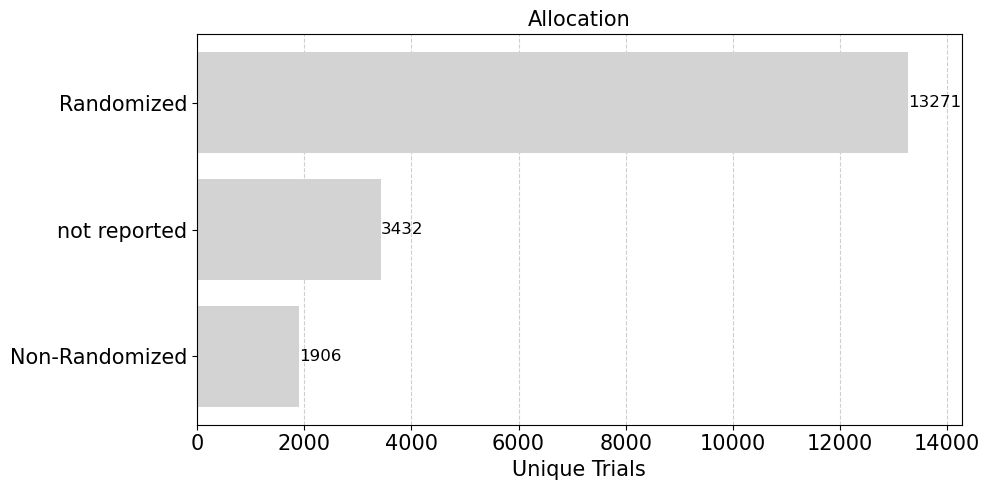

In [30]:
# Keeping only unique nct_id, phase pairs
unique_pairs_phase = trial_design[['nct_id', 'allocation']].drop_duplicates()

# Counting the number of nct_ids per phase type
allocation_counts = unique_pairs_phase['allocation'].value_counts()
allocation_counts = allocation_counts.sort_values(ascending=True)
print(sum(allocation_counts))

# Create a horizontal bar chart for the top 10 data types
plt.figure(figsize=(10, 5))
bars = plt.barh(allocation_counts.index, allocation_counts, color='lightgrey',zorder=2)

# Add labels to each bar
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height() / 2, f'{width}', va='center', fontsize=12)
    
plt.tick_params(axis='y', labelsize=15)
plt.tick_params(axis='x', labelsize=15)
plt.grid(axis='x', linestyle='--', alpha=0.6, zorder=1)
plt.xlabel('Unique Trials', fontsize=15)
plt.title('Allocation', fontsize=15)
plt.xlim(0, max(allocation_counts)+1000) # Adjusted to max count for relevancy
plt.tight_layout()

# Save the plot to a local folder
plt.savefig(f'viz/trial_characteristics/design/allocation_frequency.png')

# Display the chart
plt.show()

/var/folders/nd/2fzvhsh510gbt9x6z5pdb1gr0000gn/T/ipykernel_68110/3125102833.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_yticklabels(['{:.0f}%'.format(x * 100) for x in axs[1].get_yticks()])


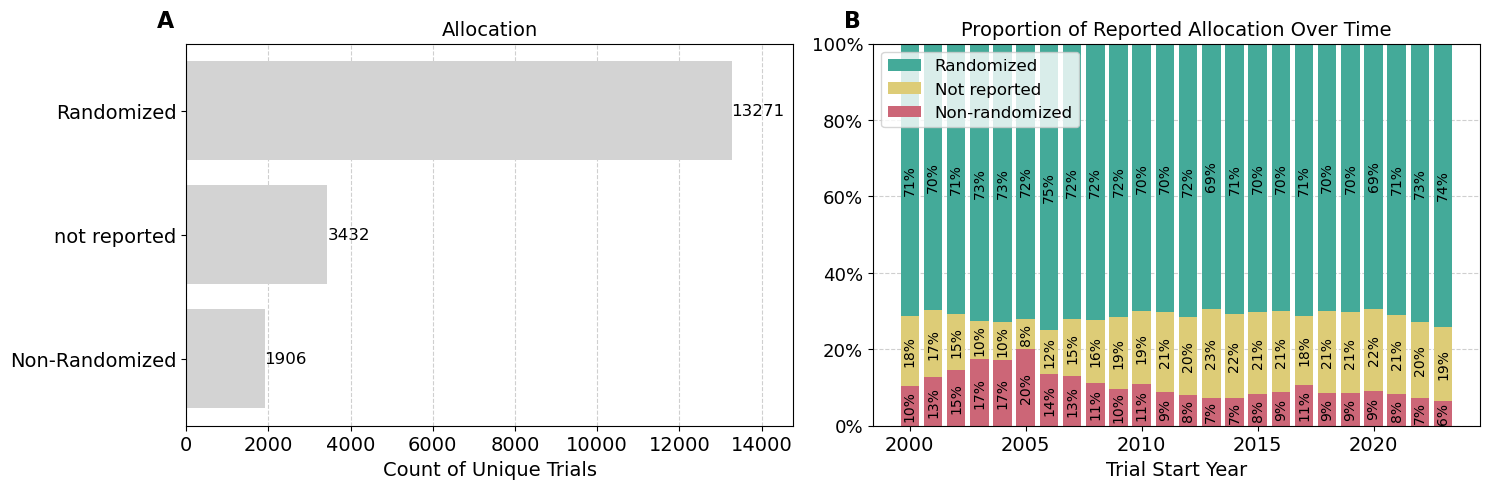

In [31]:
# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot for Allocation (Plot A)
bars_0 = axs[0].barh(allocation_counts.index, allocation_counts, color='lightgrey', zorder=2)
for bar in bars_0:
    width = bar.get_width()
    axs[0].text(width, bar.get_y() + bar.get_height() / 2, f'{width}', va='center', fontsize=12)
axs[0].tick_params(axis='y', labelsize=14)
axs[0].tick_params(axis='x', labelsize=14)
axs[0].grid(axis='x', linestyle='--', alpha=0.6, zorder=1)
axs[0].set_xlabel('Count of Unique Trials', fontsize=14)
axs[0].set_title('Allocation', fontsize=14)
axs[0].set_xlim(0, max(allocation_counts) + 1500)  # Adjusted to max count for relevancy
axs[0].text(-0.02, 1.09, 'A', transform=axs[0].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

### PLOT B
allocation_colors = {'Randomized': '#44AA99',
 'Non-Randomized': '#CC6677',
 'not reported': '#DDCC77'}
allocation_types = ['Non-Randomized', 'not reported', 'Randomized']

# Keeping only unique nct_id, allocation pairs
unique_pairs_allocation = trial_design[['nct_id', 'allocation', 'start_year']].drop_duplicates()

# Group by start_year and allocation, then count unique nct_ids
allocation_over_time = unique_pairs_allocation.groupby(['start_year', 'allocation']).size().unstack(fill_value=0)

# Calculate the proportion of each allocation type from all trials for each year
allocation_proportion_over_time = allocation_over_time.div(allocation_over_time.sum(axis=1), axis=0)

# Plot for Allocation Over Time (Plot B)
bottom = np.zeros(len(allocation_proportion_over_time))
for allocation_type in allocation_types:
    bars = axs[1].bar(allocation_proportion_over_time.index, 
                      allocation_proportion_over_time[allocation_type], 
                      bottom=bottom, 
                      label=allocation_type,
                      color=allocation_colors.get(allocation_type, 'gray'), zorder=2)  # Use custom color or gray if not specified
    bottom += allocation_proportion_over_time[allocation_type]

    # Add labels to each segment
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            axs[1].text(bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2, f'{height:.0%}', ha='center', va='center', fontsize=10, rotation=90)

axs[1].set_xlabel('Trial Start Year', fontsize=14)
axs[1].set_title('Proportion of Reported Allocation Over Time', fontsize=14)
# Set y-axis limits and labels
axs[1].set_ylim(0, 1)
axs[1].set_yticklabels(['{:.0f}%'.format(x * 100) for x in axs[1].get_yticks()])

# Sorting the legend handles
handles, labels = axs[1].get_legend_handles_labels()
allocation_type_totals = allocation_over_time.sum().to_dict()
sorted_handles_labels = sorted(zip(handles, labels), key=lambda x: allocation_type_totals[x[1]], reverse=True)
sorted_handles, sorted_labels = zip(*sorted_handles_labels)
sorted_labels = [label.capitalize() for label in sorted_labels]
axs[1].legend(sorted_handles, sorted_labels, fontsize=12, loc='upper left')

axs[1].grid(linestyle='--', alpha=0.6, zorder=1)
axs[1].tick_params(axis='x', labelsize=14)
axs[1].tick_params(axis='y', labelsize=13)
axs[1].text(-0.02, 1.09, 'B', transform=axs[1].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

# Adjust layout
plt.tight_layout()

# Save the plot to a local folder
plt.savefig(f'viz/trial_characteristics/design/allocation_over_time_{len(unique_pairs_allocation)}.pdf')

# Display the plots
plt.show()

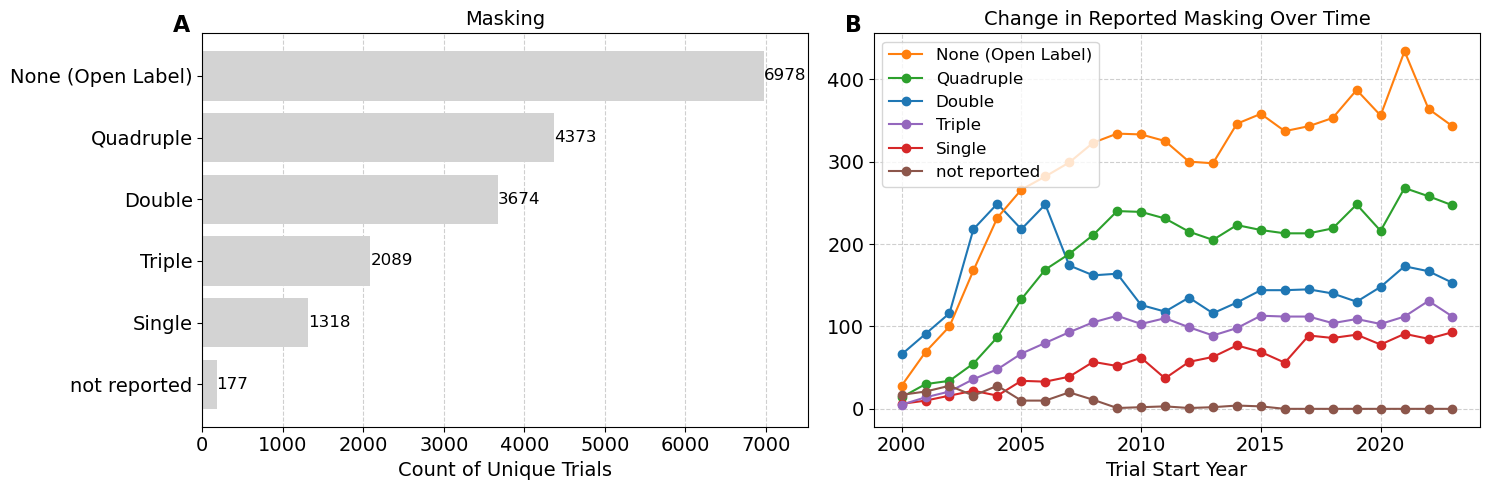

In [32]:
# Prepare masking data
unique_pairs_masking = trial_design[['nct_id', 'masking', 'start_year']].drop_duplicates()
masking_counts = unique_pairs_masking['masking'].value_counts().sort_values(ascending=True)

# Prepare masking over time data
masking_over_time = unique_pairs_masking.groupby(['start_year', 'masking']).size().unstack(fill_value=0)

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot for Masking Frequency (Plot A)
bars_0 = axs[0].barh(masking_counts.index, masking_counts, color='lightgrey', zorder=2)
for bar in bars_0:
    width = bar.get_width()
    axs[0].text(width, bar.get_y() + bar.get_height() / 2, f'{width}', va='center', fontsize=12)
axs[0].tick_params(axis='y', labelsize=14)
axs[0].tick_params(axis='x', labelsize=14)
axs[0].grid(axis='x', linestyle='--', alpha=0.6, zorder=1)
axs[0].set_xlabel('Count of Unique Trials', fontsize=14)
axs[0].set_title('Masking', fontsize=14)
axs[0].set_xlim(0, max(masking_counts) + 550)  # Adjusted to max count for relevancy
axs[0].text(-0.02, 1.05, 'A', transform=axs[0].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

# Plot for Change in Masking Over Time (Plot B)
for masking_type in masking_over_time.columns:
    axs[1].plot(masking_over_time.index, masking_over_time[masking_type], marker='o', label=masking_type)
axs[1].set_xlabel('Trial Start Year', fontsize=14)
axs[1].set_title('Change in Reported Masking Over Time', fontsize=14)

# Sorting the legend handles
handles, labels = axs[1].get_legend_handles_labels()
masking_type_totals = masking_over_time.sum().to_dict()
sorted_handles_labels = sorted(zip(handles, labels), key=lambda x: masking_type_totals[x[1]], reverse=True)
sorted_handles, sorted_labels = zip(*sorted_handles_labels)
axs[1].legend(sorted_handles, sorted_labels, fontsize=12, loc='upper left')

axs[1].grid(linestyle='--', alpha=0.6, zorder=1)
axs[1].tick_params(axis='x', labelsize=14)
axs[1].tick_params(axis='y', labelsize=14)
axs[1].text(-0.02, 1.05, 'B', transform=axs[1].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

# Adjust layout
plt.tight_layout()

# Save the plot to a local folder
plt.savefig(f'viz/trial_characteristics/design/masking_over_time_totals_{len(unique_pairs_masking)}.pdf')

# Display the plots
plt.show()

/var/folders/nd/2fzvhsh510gbt9x6z5pdb1gr0000gn/T/ipykernel_68110/2601891245.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_yticklabels(['{:.0f}%'.format(x * 100) for x in axs[1].get_yticks()])


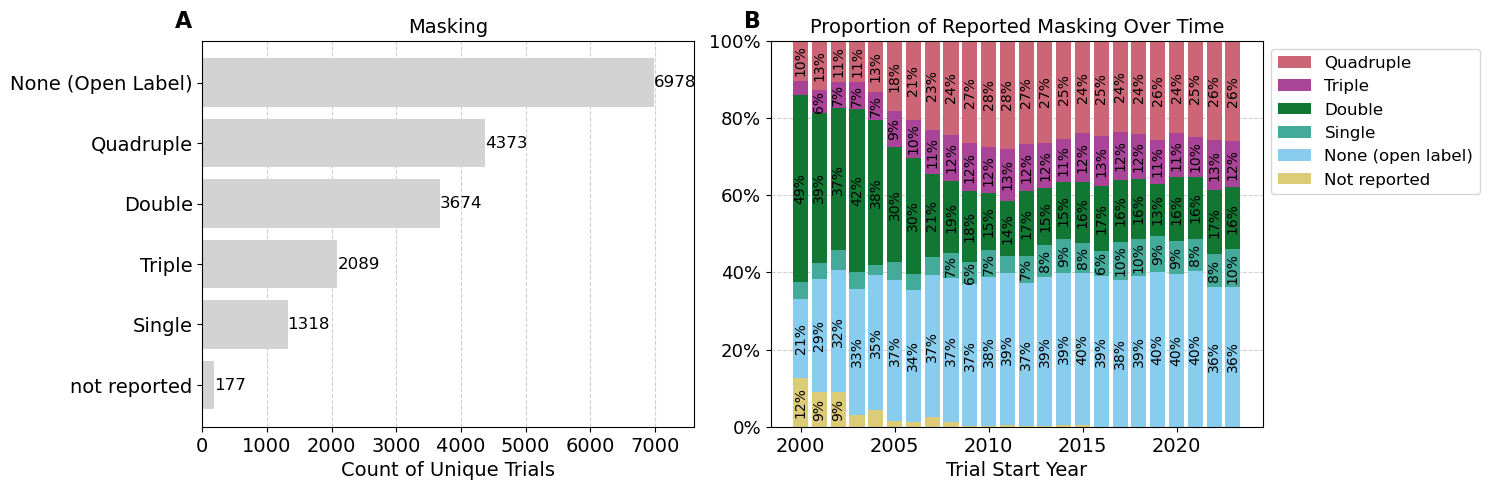

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming trial_design is already loaded and processed

# Prepare masking data
unique_pairs_masking = trial_design[['nct_id', 'masking', 'start_year']].drop_duplicates()
masking_counts = unique_pairs_masking['masking'].value_counts().sort_values(ascending=True)

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot for Masking Frequency (Plot A)
bars_0 = axs[0].barh(masking_counts.index, masking_counts, color='lightgrey', zorder=2)
for bar in bars_0:
    width = bar.get_width()
    axs[0].text(width, bar.get_y() + bar.get_height() / 2, f'{width}', va='center', fontsize=12)
axs[0].tick_params(axis='y', labelsize=14)
axs[0].tick_params(axis='x', labelsize=14)
axs[0].grid(axis='x', linestyle='--', alpha=0.6, zorder=1)
axs[0].set_xlabel('Count of Unique Trials', fontsize=14)
axs[0].set_title('Masking', fontsize=14)
axs[0].set_xlim(0, max(masking_counts) + 630)  # Adjusted to max count for relevancy
axs[0].text(-0.02, 1.08, 'A', transform=axs[0].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

# Plot for Change in Masking Over Time (Plot B)

# Prepare masking over time data
masking_over_time = unique_pairs_masking.groupby(['start_year', 'masking']).size().unstack(fill_value=0)

# Calculate the proportion of each masking type from all trials for each year
masking_proportion_over_time = masking_over_time.div(masking_over_time.sum(axis=1), axis=0)
masking_types = ['not reported', 'None (Open Label)', 'Single', 'Double', 'Triple', 'Quadruple']

masking_colors = {'None (Open Label)': '#88CCEE',
 'Quadruple': '#CC6677',
 'not reported': '#DDCC77',
 'Double': '#117733',
  'Triple': '#AA4499',
 'Single': '#44AA99'}

allocation_types = ['Non-Randomized', 'not reported', 'Randomized']

bottom = np.zeros(len(masking_proportion_over_time))
for masking_type in masking_types:
    bars = axs[1].bar(masking_proportion_over_time.index, 
                      masking_proportion_over_time[masking_type], 
                      bottom=bottom, 
                      label=masking_type, color=masking_colors.get(masking_type, 'gray'), zorder=2)
    bottom += masking_proportion_over_time[masking_type]

    # Add labels to each segment
    for bar in bars:
        height = bar.get_height()
        #print(height)
        if height > 0.055:
            axs[1].text(bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2, f'{height:.0%}', 
                        ha='center', va='center', fontsize=10, rotation=90) 

axs[1].set_xlabel('Trial Start Year', fontsize=14)
axs[1].set_title('Proportion of Reported Masking Over Time', fontsize=14)

# Set y-axis limits and labels
axs[1].set_ylim(0, 1)
axs[1].set_yticklabels(['{:.0f}%'.format(x * 100) for x in axs[1].get_yticks()])

# Sort and place the legend outside the plot area
handles, labels = axs[1].get_legend_handles_labels()
sorted_handles_labels = sorted(zip(handles, labels), key=lambda x: masking_types[::-1].index(x[1]))
sorted_handles, sorted_labels = zip(*sorted_handles_labels)
axs[1].legend(sorted_handles, [label.capitalize() for label in sorted_labels], fontsize=12, loc='upper left', bbox_to_anchor=(1.00, 1))

axs[1].grid(linestyle='--', alpha=0.6, zorder=1)
axs[1].tick_params(axis='x', labelsize=14)
axs[1].tick_params(axis='y', labelsize=13)
axs[1].text(-0.02, 1.08, 'B', transform=axs[1].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

# Adjust layout
plt.tight_layout()

# Save the plot to a local folder
plt.savefig(f'viz/trial_characteristics/design/masking_over_time_{len(unique_pairs_masking)}.pdf')

# Display the plots
plt.show()


#### 2x2 allocation and masking

/var/folders/nd/2fzvhsh510gbt9x6z5pdb1gr0000gn/T/ipykernel_68110/2203028088.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0, 1].set_yticklabels(['{:.0f}%'.format(x * 100) for x in axs[0, 1].get_yticks()])
/var/folders/nd/2fzvhsh510gbt9x6z5pdb1gr0000gn/T/ipykernel_68110/2203028088.py:70: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1, 1].set_yticklabels(['{:.0f}%'.format(x * 100) for x in axs[1, 1].get_yticks()])


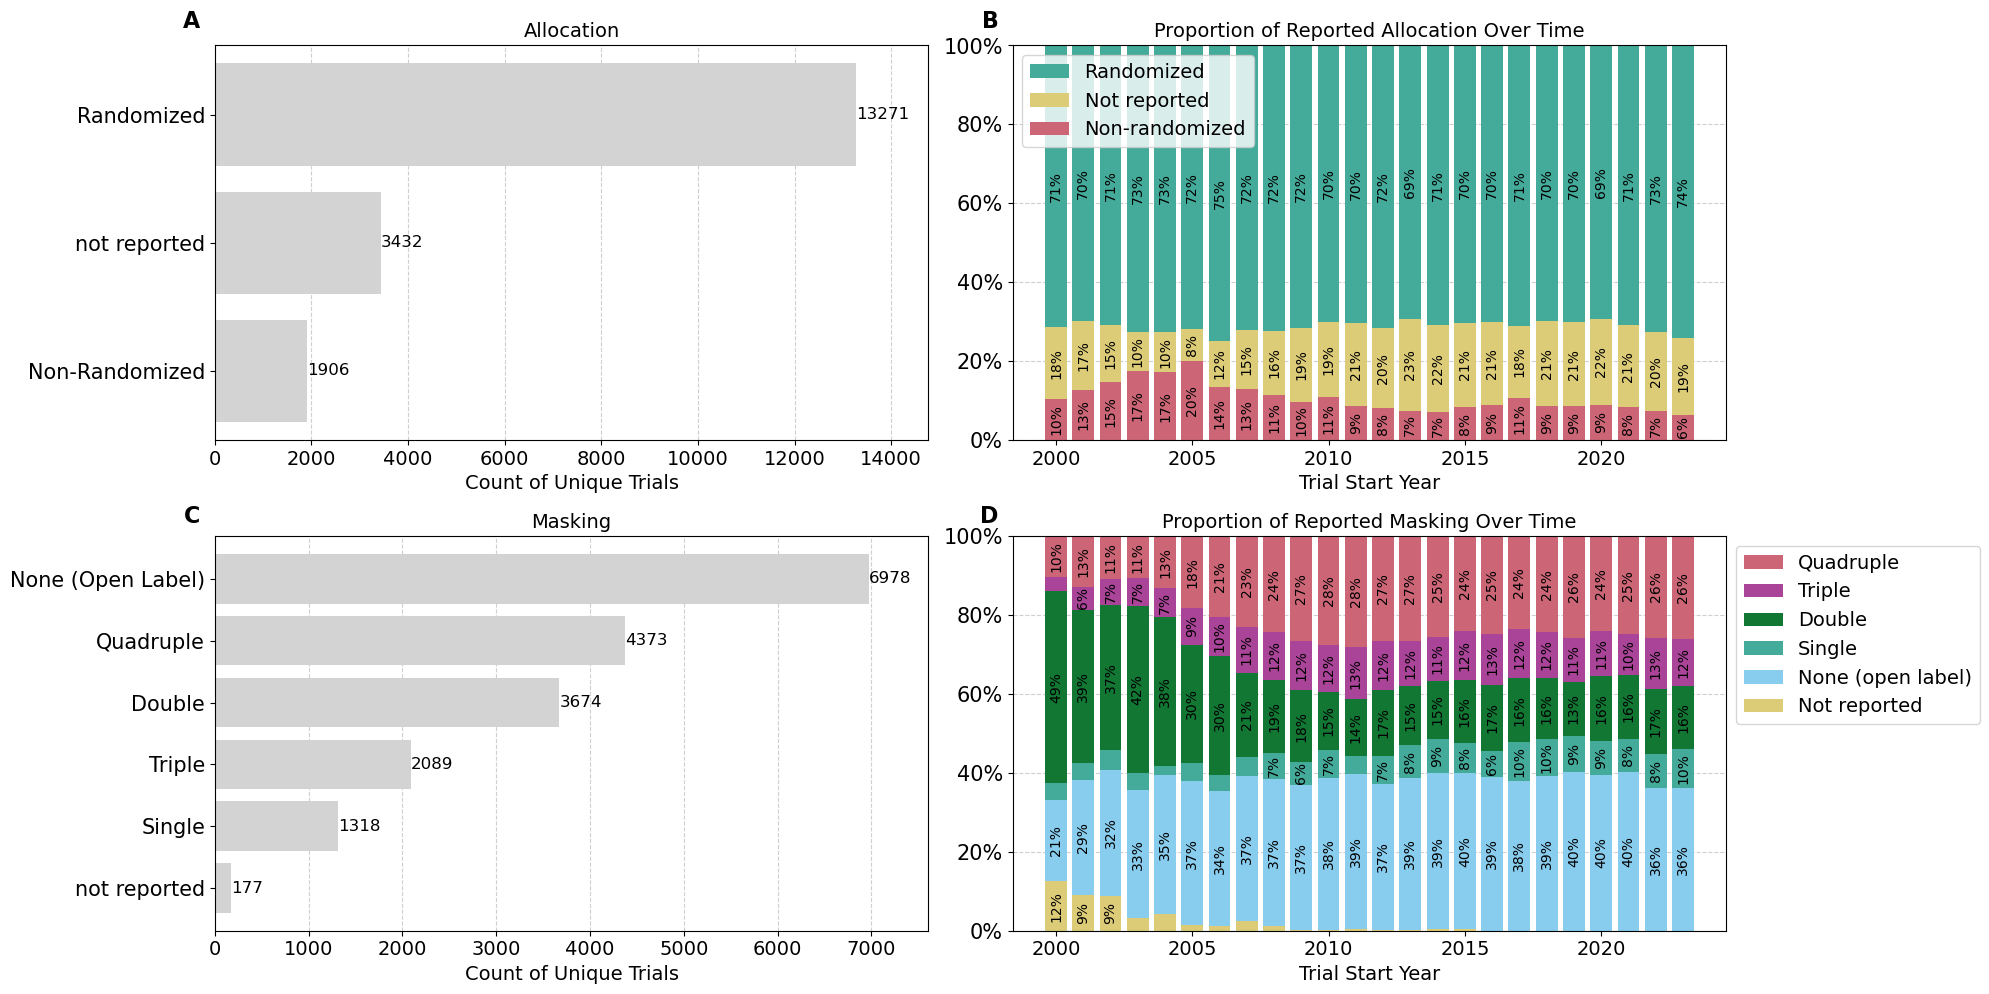

In [211]:
# Create the 2x2 figure
fig, axs = plt.subplots(2, 2, figsize=(20, 10))

# PLOT A: Allocation Frequency
bars_0 = axs[0, 0].barh(allocation_counts.index, allocation_counts, color='lightgrey', zorder=2)
for bar in bars_0:
    width = bar.get_width()
    axs[0, 0].text(width, bar.get_y() + bar.get_height() / 2, f'{width}', va='center', fontsize=12)
axs[0, 0].tick_params(axis='y', labelsize=15)
axs[0, 0].tick_params(axis='x', labelsize=14)
axs[0, 0].grid(axis='x', linestyle='--', alpha=0.6, zorder=1)
axs[0, 0].set_xlabel('Count of Unique Trials', fontsize=14)
axs[0, 0].set_title('Allocation', fontsize=14)
axs[0, 0].set_xlim(0, max(allocation_counts) + 1500)
axs[0, 0].text(-0.02, 1.09, 'A', transform=axs[0, 0].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

# PLOT B: Allocation Proportion Over Time
bottom = np.zeros(len(allocation_proportion_over_time))
for allocation_type in allocation_types:
    bars = axs[0, 1].bar(allocation_proportion_over_time.index, 
                         allocation_proportion_over_time[allocation_type], 
                         bottom=bottom, label=allocation_type,
                         color=allocation_colors.get(allocation_type, 'gray'), zorder=2)
    bottom += allocation_proportion_over_time[allocation_type]
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            axs[0, 1].text(bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2, f'{height:.0%}', ha='center', va='center', fontsize=10, rotation=90)
axs[0, 1].set_xlabel('Trial Start Year', fontsize=14)
axs[0, 1].set_title('Proportion of Reported Allocation Over Time', fontsize=14)
axs[0, 1].set_ylim(0, 1)
axs[0, 1].set_yticklabels(['{:.0f}%'.format(x * 100) for x in axs[0, 1].get_yticks()])
handles, labels = axs[0, 1].get_legend_handles_labels()
sorted_handles_labels = sorted(zip(handles, labels), key=lambda x: allocation_over_time.sum().to_dict()[x[1]], reverse=True)
sorted_handles, sorted_labels = zip(*sorted_handles_labels)
axs[0, 1].legend(sorted_handles, [label.capitalize() for label in sorted_labels], fontsize=14, loc='upper left')
axs[0, 1].grid(linestyle='--', alpha=0.6, zorder=1)
axs[0, 1].tick_params(axis='x', labelsize=14)
axs[0, 1].tick_params(axis='y', labelsize=15)
axs[0, 1].text(-0.02, 1.09, 'B', transform=axs[0, 1].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

# PLOT C: Masking Frequency
bars_1 = axs[1, 0].barh(masking_counts.index, masking_counts, color='lightgrey', zorder=2)
for bar in bars_1:
    width = bar.get_width()
    axs[1, 0].text(width, bar.get_y() + bar.get_height() / 2, f'{width}', va='center', fontsize=12)
axs[1, 0].tick_params(axis='y', labelsize=15)
axs[1, 0].tick_params(axis='x', labelsize=14)
axs[1, 0].grid(axis='x', linestyle='--', alpha=0.6, zorder=1)
axs[1, 0].set_xlabel('Count of Unique Trials', fontsize=14)
axs[1, 0].set_title('Masking', fontsize=14)
axs[1, 0].set_xlim(0, max(masking_counts) + 630)
axs[1, 0].text(-0.02, 1.08, 'C', transform=axs[1, 0].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

# PLOT D: Masking Proportion Over Time
bottom = np.zeros(len(masking_proportion_over_time))
for masking_type in masking_types:
    bars = axs[1, 1].bar(masking_proportion_over_time.index, 
                         masking_proportion_over_time[masking_type], 
                         bottom=bottom, label=masking_type,
                         color=masking_colors.get(masking_type, 'gray'), zorder=2)
    bottom += masking_proportion_over_time[masking_type]
    for bar in bars:
        height = bar.get_height()
        if height > 0.055:
            axs[1, 1].text(bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2, f'{height:.0%}', ha='center', va='center', fontsize=10, rotation=90)
axs[1, 1].set_xlabel('Trial Start Year', fontsize=14)
axs[1, 1].set_title('Proportion of Reported Masking Over Time', fontsize=14)
axs[1, 1].set_ylim(0, 1)
axs[1, 1].set_yticklabels(['{:.0f}%'.format(x * 100) for x in axs[1, 1].get_yticks()])
handles, labels = axs[1, 1].get_legend_handles_labels()
sorted_handles_labels = sorted(zip(handles, labels), key=lambda x: masking_types[::-1].index(x[1]))
sorted_handles, sorted_labels = zip(*sorted_handles_labels)
axs[1, 1].legend(sorted_handles, [label.capitalize() for label in sorted_labels], fontsize=14, loc='upper left', bbox_to_anchor=(1.00, 1))
axs[1, 1].grid(linestyle='--', alpha=0.6, zorder=1)
axs[1, 1].tick_params(axis='x', labelsize=14)
axs[1, 1].tick_params(axis='y', labelsize=15)
axs[1, 1].text(-0.02, 1.08, 'D', transform=axs[1, 1].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

# Adjust layout
plt.tight_layout()

# Save the combined plot
plt.savefig(f'viz/trial_characteristics/design/combined_allocation_masking_over_time.pdf')

# Display the combined plots
plt.show()

### Number of Participants

In [34]:
aact_baseline_counts = pd.read_csv('data/raw_aact/studies_enrollment_20240717.csv')
#aact_participant_counts = aact_baseline_counts[aact_baseline_counts['units'] == 'Participants']
aact_baseline_counts.shape


(485756, 3)

In [35]:
aact_baseline_counts.head()

nct_id  enrollment enrollment_type
0  NCT00840918       123.0          Actual
1  NCT02893800        40.0          Actual
2  NCT02856126       214.0     Anticipated
3  NCT01705626       500.0          Actual
4  NCT00404430       121.0          Actual

In [36]:
aact_baseline_counts[aact_baseline_counts['nct_id']=='NCT00001956']

nct_id  enrollment enrollment_type
2778  NCT00001956       800.0             NaN

In [37]:
trials_ids_unique = trial_design[['nct_id','start_year']].drop_duplicates()
trials_ids_unique.shape

(18609, 2)

In [38]:
trials_with_participants = trials_ids_unique.merge(aact_baseline_counts, how='left', on='nct_id')
trials_with_participants

nct_id  start_year  enrollment enrollment_type
0      NCT00000307        2003         0.0             NaN
1      NCT00000333        2001         0.0             NaN
2      NCT00000428        2000        58.0          Actual
3      NCT00000439        2000        72.0          Actual
4      NCT00001956        2000       800.0             NaN
...            ...         ...         ...             ...
18604  NCT06282640        2021        87.0          Actual
18605  NCT06287502        2022        20.0     Anticipated
18606  NCT06289335        2020        40.0          Actual
18607  NCT06292351        2023       135.0     Anticipated
18608  NCT06293586        2023       140.0     Anticipated

[18609 rows x 4 columns]

In [39]:
nan_count = trials_with_participants.isna().any(axis=1).sum()
nan_count

825

In [40]:
def classify_enrollment(enrollment):
    if 0 <= enrollment <= 10:
        return "0–10"
    elif 11 <= enrollment <= 50:
        return "11–50"
    elif 51 <= enrollment <= 100:
        return "51–100"
    elif 101 <= enrollment <= 1000:
        return "101–1,000"
    else:
        return ">1,000"

# Apply the classification function to create a new column
trials_with_participants['enrollment_class'] = trials_with_participants['enrollment'].apply(classify_enrollment)


In [41]:
trials_with_participants.head()

nct_id  start_year  enrollment enrollment_type enrollment_class
0  NCT00000307        2003         0.0             NaN             0–10
1  NCT00000333        2001         0.0             NaN             0–10
2  NCT00000428        2000        58.0          Actual           51–100
3  NCT00000439        2000        72.0          Actual           51–100
4  NCT00001956        2000       800.0             NaN        101–1,000

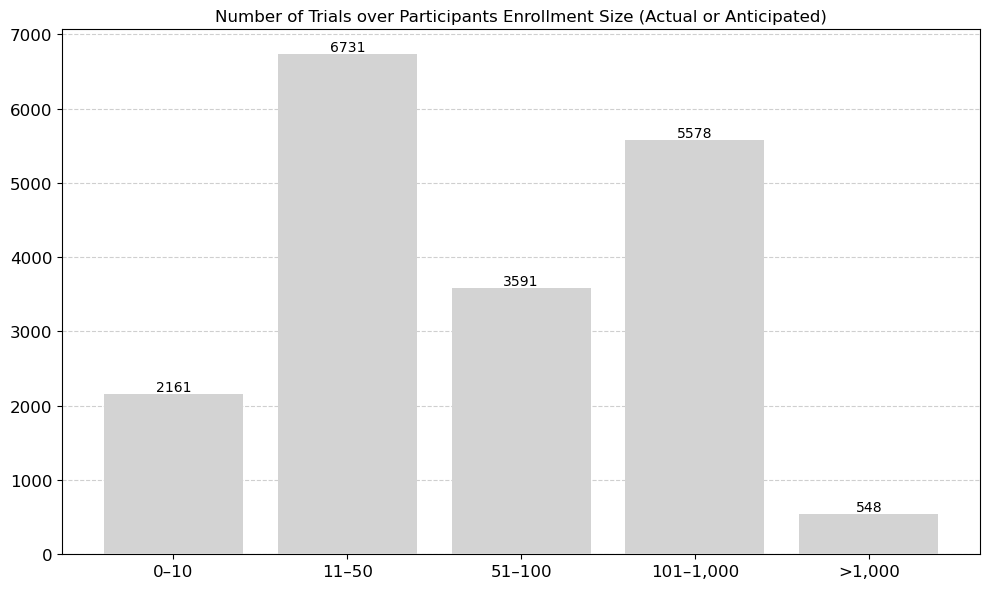

In [42]:
# Count the occurrences of each enrollment class
enrollment_class_counts = trials_with_participants['enrollment_class'].value_counts().sort_index()
# Define the order of the categories
category_order = ["0–10", "11–50", "51–100", "101–1,000", ">1,000"]

# Reorder the counts according to the specified category order
enrollment_class_counts = enrollment_class_counts.reindex(category_order, fill_value=0)

# Plot the counts as a vertical bar chart with sorted categories
plt.figure(figsize=(10, 6))
ax = plt.bar(enrollment_class_counts.index, enrollment_class_counts.values, color='lightgrey', zorder=3)
plt.title('Number of Trials over Participants Enrollment Size (Actual or Anticipated)')
#plt.xticks(rotation=45)

# Adding the text labels on the bars
for i, value in enumerate(enrollment_class_counts):
    plt.text(i, value + 0.1, str(int(value)), ha='center', va='bottom')

plt.grid(axis='y', linestyle='--', alpha=0.6, zorder=1)
plt.tick_params(axis='y', labelsize=12)
plt.tick_params(axis='x', labelsize=12)

plt.tight_layout()
plt.show()

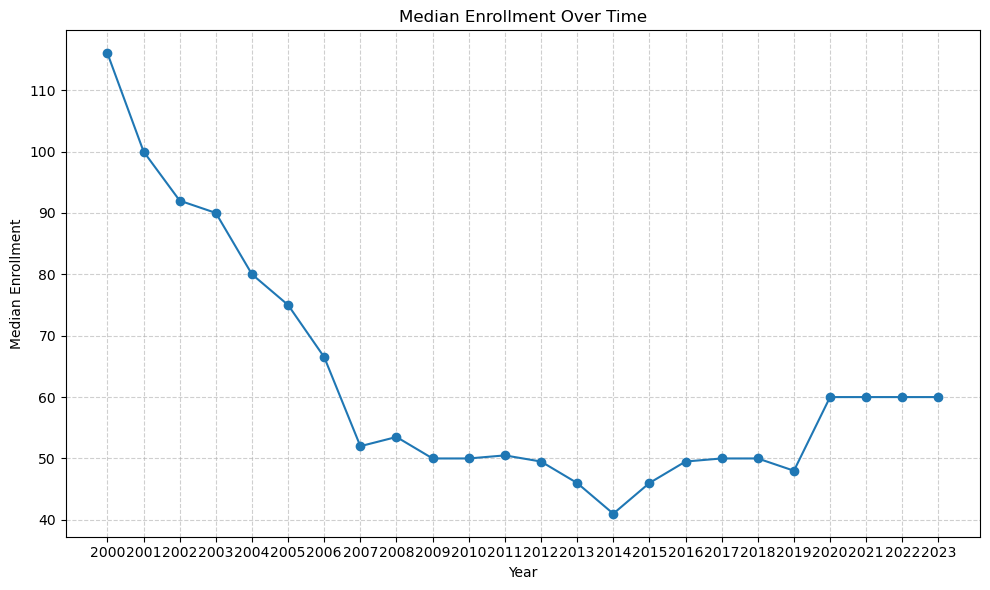

In [43]:
# Calculate the median enrollment per year
median_enrollment_per_year = trials_with_participants.groupby('start_year')['enrollment'].median().reset_index()

# Plot the median enrollment over time
plt.figure(figsize=(10, 6))
plt.plot(median_enrollment_per_year['start_year'], median_enrollment_per_year['enrollment'], marker='o', linestyle='-')
plt.xlabel('Year')
plt.ylabel('Median Enrollment')
plt.title('Median Enrollment Over Time')
plt.grid(linestyle='--', alpha=0.6, zorder=1)
plt.xticks(median_enrollment_per_year['start_year'])
plt.tight_layout()

# Show the plot
plt.show()

### Number of Facilities

In [44]:
trial_design.columns

Index(['nct_id', 'allocation', 'masking',
       'number_of_primary_outcomes_to_measure',
       'number_of_secondary_outcomes_to_measure',
       'number_of_other_outcomes_to_measure', 'number_of_facilities',
       'country', 'country_name', 'start_year'],
      dtype='object')

In [45]:
unique_pairs_facilities = trial_design[['nct_id', 'number_of_facilities']].drop_duplicates()
unique_pairs_facilities

nct_id number_of_facilities
2285     NCT00000307                  1.0
2379     NCT00000333                  1.0
2712     NCT00000428                  7.0
2754     NCT00000439                  1.0
6266     NCT00001956                  1.0
...              ...                  ...
9258396  NCT06282640                  1.0
9258791  NCT06287502                  1.0
9258933  NCT06289335                  1.0
9259172  NCT06292351                  7.0
9259439  NCT06293586                  1.0

[18609 rows x 2 columns]

In [46]:
unique_pairs_facilities['number_of_facilities'] = pd.to_numeric(unique_pairs_facilities['number_of_facilities'], errors='coerce')

len(unique_pairs_facilities[unique_pairs_facilities["number_of_facilities"]>100])

277

In [47]:
unique_pairs_facilities[unique_pairs_facilities["number_of_facilities"]>100]

nct_id  number_of_facilities
69023    NCT00006024                 235.0
96713    NCT00027846                 165.0
121035   NCT00036205                 110.0
122355   NCT00036218                 102.0
146812   NCT00044915                 119.0
...              ...                   ...
8965912  NCT05509400                 107.0
8971675  NCT05518123                 130.0
8977584  NCT05523167                 121.0
9163819  NCT05929066                 141.0
9212536  NCT06079190                 104.0

[277 rows x 2 columns]

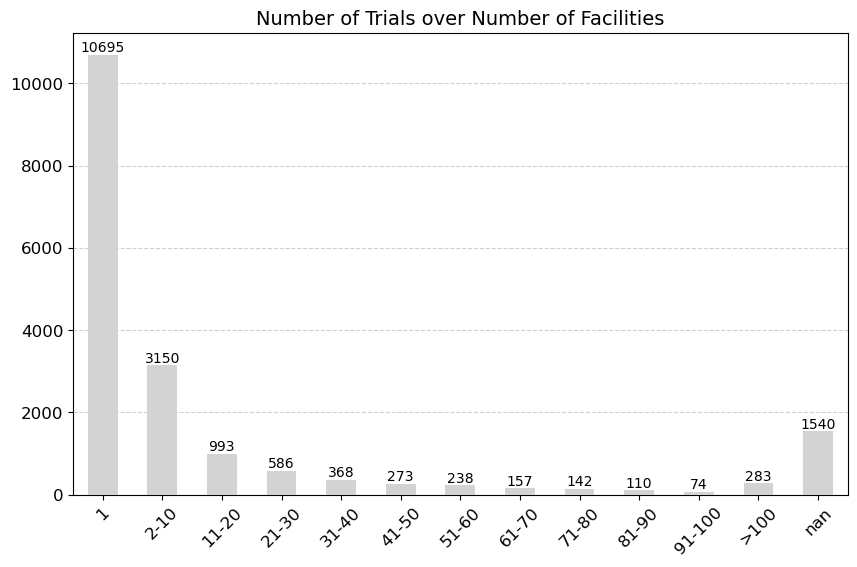

(None,
 binned
 1         10695.0
 2-10       3150.0
 11-20       993.0
 21-30       586.0
 31-40       368.0
 41-50       273.0
 51-60       238.0
 61-70       157.0
 71-80       142.0
 81-90       110.0
 91-100       74.0
 >100        283.0
 NaN        1540.0
 Name: count, dtype: float64)

In [48]:
# Convert the 'number_of_facilities' column to numeric, setting errors='coerce' to handle 'not reported' values
unique_pairs_facilities['number_of_facilities'] = pd.to_numeric(unique_pairs_facilities['number_of_facilities'], errors='coerce')

# Define the bins and labels
bins = [0, 2, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, np.inf]
labels = ['1', '2-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100', '>100']

# Bin the data
unique_pairs_facilities['binned'] = pd.cut(unique_pairs_facilities['number_of_facilities'], bins=bins, labels=labels, right=False)

# Count occurrences in each bin including NaN for 'not reported'
bin_counts = unique_pairs_facilities['binned'].value_counts().reindex(labels + [np.nan]).fillna(0)
bin_counts[np.nan] = len(unique_pairs_facilities[unique_pairs_facilities['number_of_facilities'].isna()])

# Plot

plt.figure(figsize=(10, 6))

ax = bin_counts.plot(kind='bar', color='lightgrey', zorder=3)
# Adding the text labels on the bars
for i, value in enumerate(bin_counts):
    ax.text(i, value + 0.1, str(int(value)), ha='center', va='bottom')
    
plt.title('Number of Trials over Number of Facilities', fontsize=14)
plt.xlabel('', fontsize=14)
plt.ylabel('', fontsize=14)
plt.xticks(rotation=45)
ax.grid(axis='y', linestyle='--', alpha=0.6, zorder=1)
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)

plt.savefig(f'viz/trial_characteristics/design/nr_facilities_per_trial_{len(unique_pairs_facilities)}.pdf')

plt.show(), bin_counts

#### combined with participants

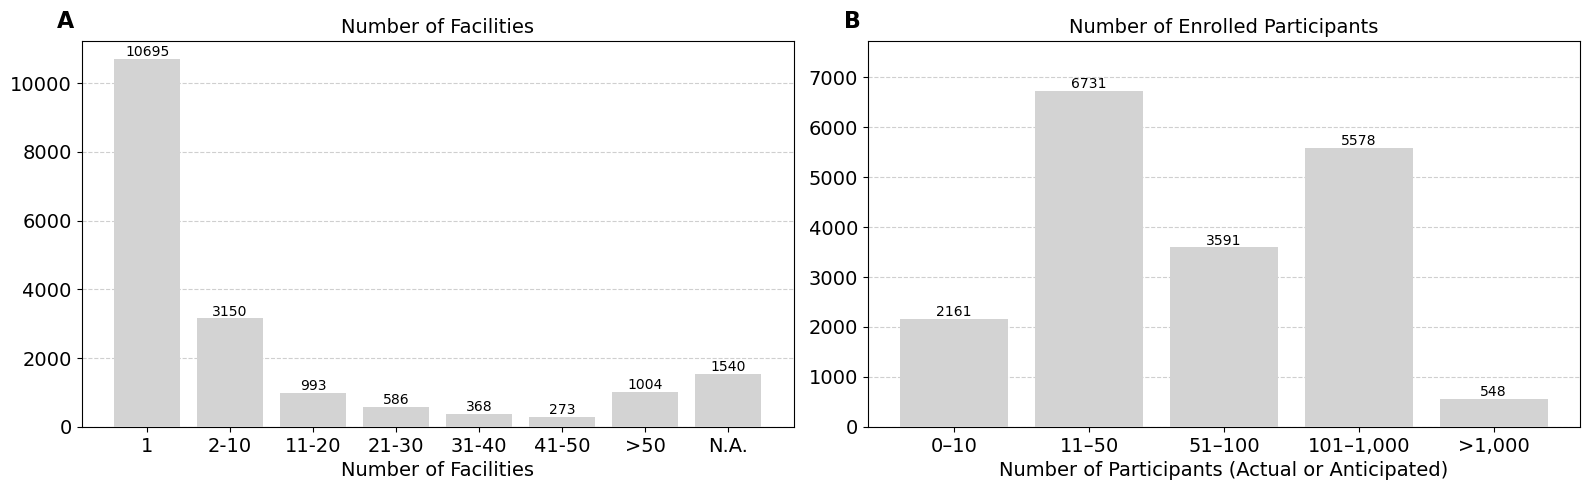

In [49]:
# Convert the 'number_of_facilities' column to numeric, setting errors='coerce' to handle 'not reported' values
unique_pairs_facilities['number_of_facilities'] = pd.to_numeric(unique_pairs_facilities['number_of_facilities'], errors='coerce')

# Define the bins and labels
bins = [0, 2, 10, 20, 30, 40, 50, np.inf]
labels = ['1', '2-10', '11-20', '21-30', '31-40', '41-50', '>50']

# Bin the data
unique_pairs_facilities['binned'] = pd.cut(unique_pairs_facilities['number_of_facilities'], bins=bins, labels=labels, right=False)

# Count occurrences in each bin including NaN for 'not reported'
bin_counts_facilities = unique_pairs_facilities['binned'].value_counts().reindex(labels + [np.nan]).fillna(0)
bin_counts_facilities[np.nan] = len(unique_pairs_facilities[unique_pairs_facilities['number_of_facilities'].isna()])

# Count the occurrences of each enrollment class
enrollment_class_counts = trials_with_participants['enrollment_class'].value_counts().sort_index()

# Define the order of the categories
category_order_enrollment = ["0–10", "11–50", "51–100", "101–1,000", ">1,000"]

# Reorder the counts according to the specified category order
enrollment_class_counts = enrollment_class_counts.reindex(category_order_enrollment, fill_value=0)

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# Plot for number_of_facilities
bin_counts_facilities = bin_counts_facilities.rename(index={np.nan: 'N.A.'})
bars_facilities = axs[0].bar(bin_counts_facilities.index.astype(str), bin_counts_facilities, color='lightgrey', zorder=3)
for i, value in enumerate(bin_counts_facilities):
    axs[0].text(i, value + 0.1, str(int(value)), ha='center', va='bottom')

axs[0].tick_params(axis='y', labelsize=14)
axs[0].tick_params(axis='x', labelsize=14)
axs[0].grid(axis='y', linestyle='--', alpha=0.6, zorder=1)
axs[0].set_xlabel('Number of Facilities', fontsize=14)
axs[0].set_title('Number of Facilities', fontsize=14)
#plt.xticks(rotation=45)
axs[0].text(-0.01, 1.08, 'A', transform=axs[0].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

# Plot for enrollment
bars_enrollment = axs[1].bar(enrollment_class_counts.index, enrollment_class_counts.values, color='lightgrey', zorder=3)
for i, value in enumerate(enrollment_class_counts):
    axs[1].text(i, value + 0.1, str(int(value)), ha='center', va='bottom')

axs[1].tick_params(axis='y', labelsize=14)
axs[1].tick_params(axis='x', labelsize=14)
axs[1].grid(axis='y', linestyle='--', alpha=0.6, zorder=1)
axs[1].set_xlabel('Number of Participants (Actual or Anticipated)', fontsize=14)
axs[1].set_title('Number of Enrolled Participants', fontsize=14)
axs[1].text(-0.01, 1.08, 'B', transform=axs[1].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
axs[1].set_ylim(0, max(enrollment_class_counts) + 1000) # Adjusted to max count for relevancy

plt.tight_layout()

plt.savefig(f'viz/trial_characteristics/design/trial_size_facilities_enrollment_{len(unique_pairs_facilities)}.pdf')

# Display the plots
plt.show()

### World map

In [50]:
import plotly
import plotly.express as px
import plotly.graph_objects as go


In [82]:
unique_pairs_facility_countries = trial_design[['nct_id', 'country']].drop_duplicates()
unique_pairs_facility_countries['country'] = unique_pairs_facility_countries['country'].replace({'United States': 'United States of America'})
unique_pairs_facility_countries['country'] = unique_pairs_facility_countries['country'].replace({'Russian Federation': 'Russia'})
unique_pairs_facility_countries['country'] = unique_pairs_facility_countries['country'].replace({'Korea, Republic of': 'South Korea'})

unique_pairs_facility_countries


nct_id                   country
2285     NCT00000307  United States of America
2379     NCT00000333  United States of America
2712     NCT00000428  United States of America
2754     NCT00000439  United States of America
6266     NCT00001956  United States of America
...              ...                       ...
9258396  NCT06282640                    Turkey
9258791  NCT06287502                 Hong Kong
9258933  NCT06289335                    Mexico
9259172  NCT06292351                    Russia
9259439  NCT06293586                     Egypt

[33339 rows x 2 columns]

In [83]:
len(set(unique_pairs_facility_countries['nct_id']))

18609

In [84]:
unique_pairs_facility_countries


nct_id                   country
2285     NCT00000307  United States of America
2379     NCT00000333  United States of America
2712     NCT00000428  United States of America
2754     NCT00000439  United States of America
6266     NCT00001956  United States of America
...              ...                       ...
9258396  NCT06282640                    Turkey
9258791  NCT06287502                 Hong Kong
9258933  NCT06289335                    Mexico
9259172  NCT06292351                    Russia
9259439  NCT06293586                     Egypt

[33339 rows x 2 columns]

In [199]:
# Group by 'nct_id' and count unique countries
trial_country_counts = unique_pairs_facility_countries.groupby('nct_id')['country'].nunique()

# Filter to include only those trials with facilities in more than one country
multi_country_trials = trial_country_counts[trial_country_counts > 1]
single_country_trials = trial_country_counts[trial_country_counts == 1]

# Calculate the average number of unique countries per trial
average_countries = multi_country_trials.mean()
average_countries

6.7923712151002755

In [89]:
len(multi_country_trials)/len(set(unique_pairs_facility_countries['nct_id'])), len(single_country_trials)/len(set(unique_pairs_facility_countries['nct_id']))

(0.13665430705572573, 0.8633456929442743)

In [90]:
multi_country_trials

nct_id
NCT00005850     2
NCT00006024     7
NCT00012467     2
NCT00021541     2
NCT00027300     8
               ..
NCT06141486     2
NCT06152237     2
NCT06194552     2
NCT06204809     2
NCT06254482    10
Name: country, Length: 2543, dtype: int64

In [55]:
len(single_country_trials), len(multi_country_trials)

(16066, 2543)

In [91]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
print(world['name'].unique())
len(world['name'].unique())


['Fiji' 'Tanzania' 'W. Sahara' 'Canada' 'United States of America'
 'Kazakhstan' 'Uzbekistan' 'Papua New Guinea' 'Indonesia' 'Argentina'
 'Chile' 'Dem. Rep. Congo' 'Somalia' 'Kenya' 'Sudan' 'Chad' 'Haiti'
 'Dominican Rep.' 'Russia' 'Bahamas' 'Falkland Is.' 'Norway' 'Greenland'
 'Fr. S. Antarctic Lands' 'Timor-Leste' 'South Africa' 'Lesotho' 'Mexico'
 'Uruguay' 'Brazil' 'Bolivia' 'Peru' 'Colombia' 'Panama' 'Costa Rica'
 'Nicaragua' 'Honduras' 'El Salvador' 'Guatemala' 'Belize' 'Venezuela'
 'Guyana' 'Suriname' 'France' 'Ecuador' 'Puerto Rico' 'Jamaica' 'Cuba'
 'Zimbabwe' 'Botswana' 'Namibia' 'Senegal' 'Mali' 'Mauritania' 'Benin'
 'Niger' 'Nigeria' 'Cameroon' 'Togo' 'Ghana' "Côte d'Ivoire" 'Guinea'
 'Guinea-Bissau' 'Liberia' 'Sierra Leone' 'Burkina Faso'
 'Central African Rep.' 'Congo' 'Gabon' 'Eq. Guinea' 'Zambia' 'Malawi'
 'Mozambique' 'eSwatini' 'Angola' 'Burundi' 'Israel' 'Lebanon'
 'Madagascar' 'Palestine' 'Gambia' 'Tunisia' 'Algeria' 'Jordan'
 'United Arab Emirates' 'Qatar' 'Kuwait'

/var/folders/nd/2fzvhsh510gbt9x6z5pdb1gr0000gn/T/ipykernel_68110/2730037189.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


177

In [93]:
unique_pairs_facility_countries[unique_pairs_facility_countries['country'] == 'not reported']

nct_id       country
59565    NCT00004403  not reported
116670   NCT00034697  not reported
116744   NCT00034749  not reported
116768   NCT00034762  not reported
116776   NCT00034775  not reported
...              ...           ...
9232314  NCT06128616  not reported
9232814  NCT06133309  not reported
9235010  NCT06137924  not reported
9235336  NCT06141876  not reported
9235419  NCT06144021  not reported

[1553 rows x 2 columns]

In [57]:
df_filtered = unique_pairs_facility_countries[unique_pairs_facility_countries['country'] != 'not reported']
df_filtered.country.nunique()


136

In [94]:
import contextily as ctx
import geopandas as gpd
from matplotlib.colors import Normalize
from matplotlib.colorbar import ColorbarBase
#from matplotlib.cm import ScalarMappable, cmap

In [95]:
world

pop_est      continent                      name iso_a3  gdp_md_est  \
0       889953.0        Oceania                      Fiji    FJI        5496   
1     58005463.0         Africa                  Tanzania    TZA       63177   
2       603253.0         Africa                 W. Sahara    ESH         907   
3     37589262.0  North America                    Canada    CAN     1736425   
4    328239523.0  North America  United States of America    USA    21433226   
..           ...            ...                       ...    ...         ...   
172    6944975.0         Europe                    Serbia    SRB       51475   
173     622137.0         Europe                Montenegro    MNE        5542   
174    1794248.0         Europe                    Kosovo    -99        7926   
175    1394973.0  North America       Trinidad and Tobago    TTO       24269   
176   11062113.0         Africa                  S. Sudan    SSD       11998   

                                              geometry  
0    MULTIPOLYGON (((180.00000 -16.06713, 180.00000...  
1    POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...  
2    POLYGON ((-8.66559 27.65643, -8.66512 27.58948...  
3    MULTIPOLYGON (((-122.84000 49.00000, -122.9742...  
4    MULTIPOLYGON (((-122.84000 49.00000, -120.0000...  
..                                                 ...  
172  POLYGON ((18.82982 45.90887, 18.82984 45.90888...  
173  POLYGON ((20.07070 42.58863, 19.80161 42.50009...  
174  POLYGON ((20.59025 41.85541, 20.52295 42.21787...  
175  POLYGON ((-61.68000 10.76000, -61.10500 10.890...  
176  POLYGON ((30.83385 3.50917, 29.95350 4.17370, ...  

[177 rows x 6 columns]

/var/folders/nd/2fzvhsh510gbt9x6z5pdb1gr0000gn/T/ipykernel_68110/1032474129.py:6: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


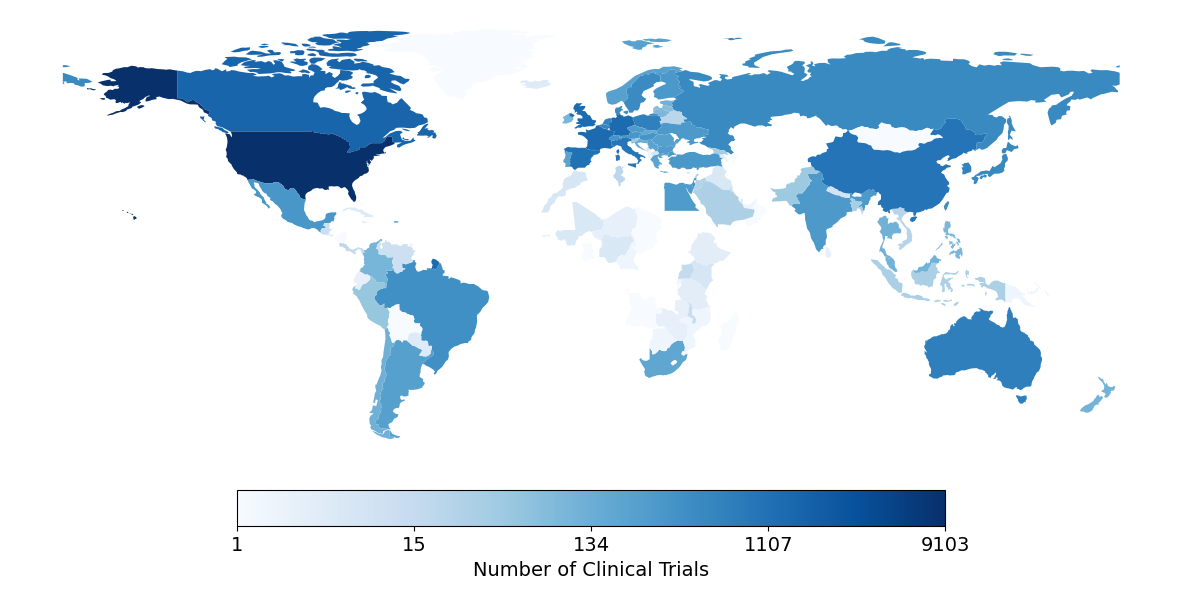

In [96]:
# Count the number of facilities per country
country_counts = df_filtered['country'].value_counts().reset_index()
country_counts.columns = ['country', 'count']

# Load world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Merge the world GeoDataFrame with the country counts DataFrame
world = world.merge(country_counts, how="left", left_on="name", right_on="country")

# Apply a logarithmic transformation to the 'Frequency' column to deal with wide ranges in data
world['log_count'] = np.log1p(world['count'])

# Ensure that areas with zero (log1p(0) = 0) are left white by treating them as NaN
world['log_count'] = world['log_count'].replace(0, np.nan)

# Plot the data
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
base = world.plot(ax=ax, column='log_count', cmap='Blues', legend=False, legend_kwds={'label': "Number of Clinical Trials by Country", 'orientation': "horizontal"})
#ctx.add_basemap(ax, crs=world.crs.to_string(), source=ctx.providers.Stamen.Terrain)
ax.set_axis_off()
#plt.title('World Map with of Clinical Trial Frequency', fontsize=15)

# Create a custom colorbar
norm = Normalize(vmin=world['log_count'].min(), vmax=world['log_count'].max())
sm = ScalarMappable(cmap='Blues', norm=norm)
sm._A = []  # Fake up the array of the scalar mappable. Urgh...
cb = plt.colorbar(sm, ax=ax, orientation='horizontal', fraction=0.046, pad=0.04)
cb.set_label('Number of Clinical Trials', fontsize=14)

# Format the ticks to show the actual counts
tick_locs = np.linspace(world['log_count'].min(), world['log_count'].max(), num=5)
cb.set_ticks(tick_locs)
cb.set_ticklabels((np.exp(tick_locs) - 1).round().astype(int), fontsize=14)  # Convert log count back to count and increase font size


# Save the figure as a PDF
plt.savefig(f'viz/trial_characteristics/general/clinical_trials_world_map_{len(trial_country_counts)}.pdf', format='pdf')

# Show the plot
plt.show()

In [97]:
from matplotlib import gridspec


/var/folders/nd/2fzvhsh510gbt9x6z5pdb1gr0000gn/T/ipykernel_68110/1686778283.py:6: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


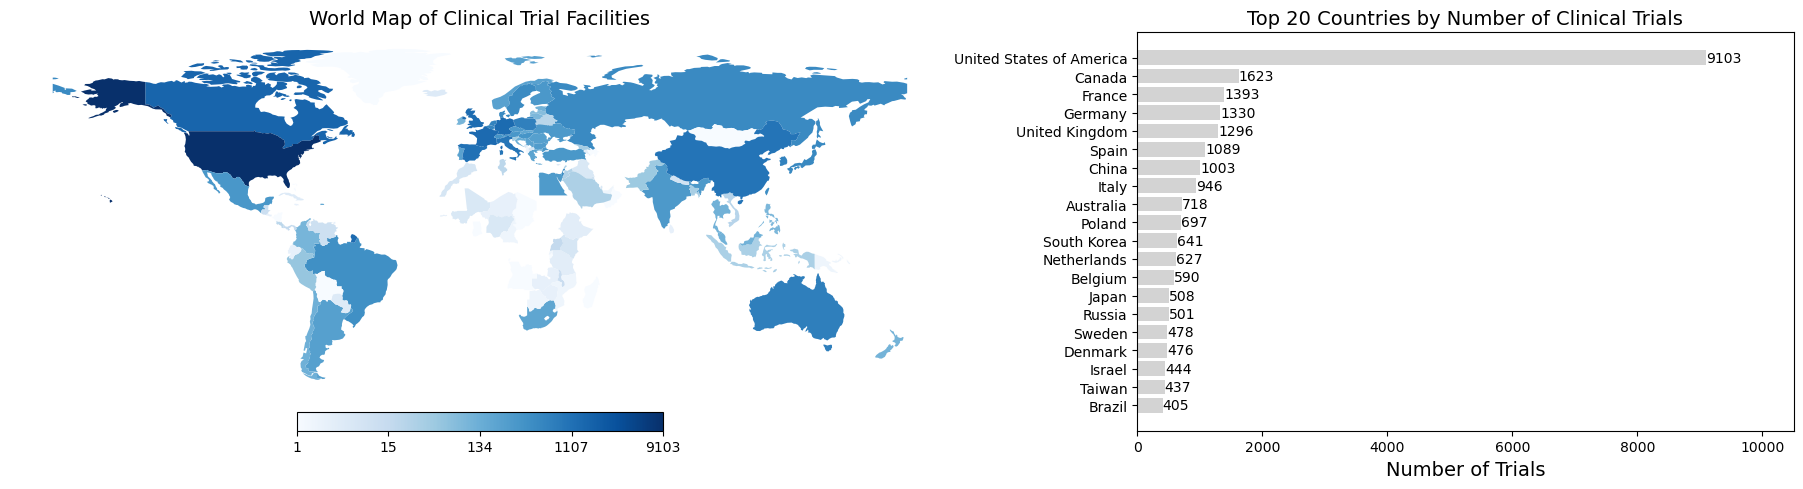

In [98]:
# Count the number of facilities per country
country_counts = df_filtered['country'].value_counts().reset_index()
country_counts.columns = ['country', 'count']

# Load world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Merge the world GeoDataFrame with the country counts DataFrame
world = world.merge(country_counts, how="left", left_on="name", right_on="country")

# Apply a logarithmic transformation to the 'count' column to deal with wide ranges in data
world['log_count'] = np.log1p(world['count'])

# Ensure that areas with zero (log1p(0) = 0) are left white by treating them as NaN
world['log_count'] = world['log_count'].replace(0, np.nan)

# Set up the figure and grid spec
fig = plt.figure(figsize=(20, 5))
gs = GridSpec(1, 2, width_ratios=[2, 1])  # Adjust the width ratio to favor the map

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

# Plotting the world map (assuming world and log_count are already defined)
base = world.plot(ax=ax1, column='log_count', cmap='Blues', legend=False)
ax1.set_title('World Map of Clinical Trial Facilities', fontsize=14)
ax1.set_axis_off()

# Create a custom colorbar for the map
norm = Normalize(vmin=world['log_count'].min(), vmax=world['log_count'].max())
sm = ScalarMappable(cmap='Blues', norm=norm)
sm._A = []
cb = plt.colorbar(sm, ax=ax1, orientation='horizontal', fraction=0.046, pad=0.04)
#cb.set_label('Number of Clinical Trial Facilities by Country', fontsize=14)
tick_locs = np.linspace(world['log_count'].min(), world['log_count'].max(), num=5)
cb.set_ticks(tick_locs)
cb.set_ticklabels((np.exp(tick_locs) - 1).round().astype(int))

# Adjustments for the bar chart to sort by most frequent and select the top 20 countries
top_countries = country_counts.sort_values(by='count', ascending=False).head(20)
ax2.barh(top_countries['country'], top_countries['count'], color='lightgrey')
ax2.set_title('Top 20 Countries by Number of Clinical Trials', fontsize=14)
ax2.set_xlabel('Number of Trials', fontsize=14)
ax2.invert_yaxis()  # Invert the y-axis to have the country with the most trials on top
ax2.set_xlim(0, 10500) # Adjusted to max count for relevancy

# Label the bars with their respective counts
for index, value in enumerate(top_countries['count']):
    ax2.text(value, index, f'{value}', va='center')

# Adjust layout to prevent overlap and ensure good proportion between subplots
plt.tight_layout()
fig.subplots_adjust(wspace=0.001)  # Adjust the width space between the subplots

# Save the figure as a PDF
plt.savefig('viz/trial_characteristics/general/clinical_trials_world_map_and_bar_chart.pdf',  bbox_inches='tight', pad_inches=0.1)


# Show the plot
plt.show()

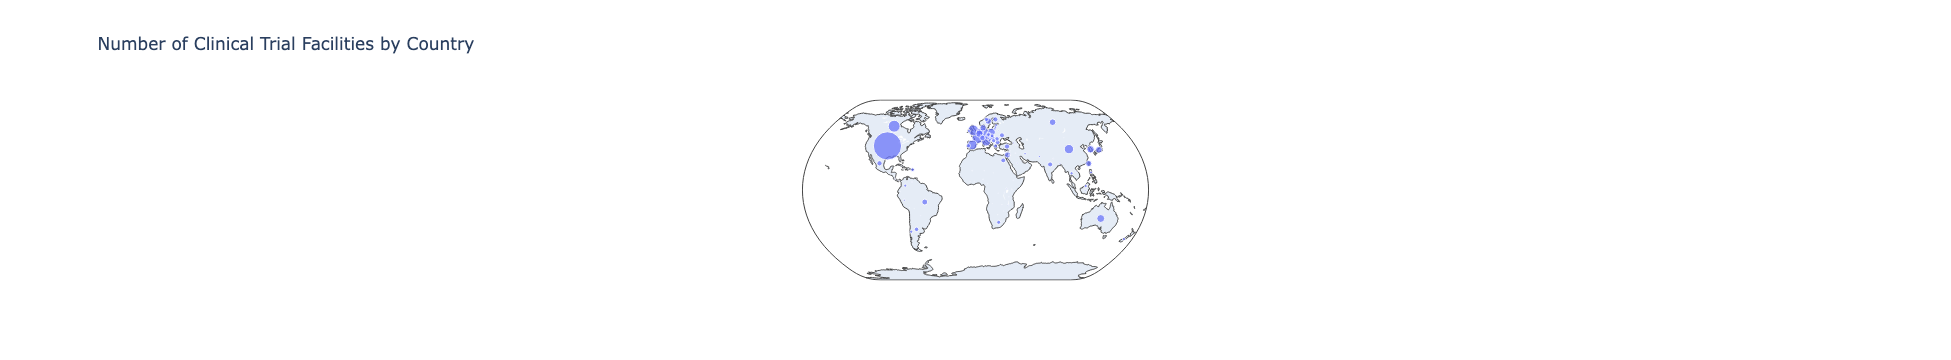

In [128]:
# Filter out rows where the country is 'not reported'

# Count the number of facilities per country
country_counts = df_filtered['country'].value_counts().reset_index()
country_counts.columns = ['country', 'count']

# Plotting the data on a world map
fig = px.scatter_geo(country_counts,
                     locations="country",
                     locationmode='country names',
                     size="count",
                     hover_name="country",
                     projection="natural earth",
                     title="Number of Clinical Trial Facilities by Country")

fig.show()

### Number of Outcomes

In [129]:
trial_design.head()

nct_id    allocation       masking  \
2285  NCT00000307  not reported  not reported   
2286  NCT00000307  not reported  not reported   
2287  NCT00000307  not reported  not reported   
2288  NCT00000307  not reported  not reported   
2289  NCT00000307  not reported  not reported   

     number_of_primary_outcomes_to_measure  \
2285                                   1.0   
2286                                   1.0   
2287                                   1.0   
2288                                   1.0   
2289                                   1.0   

     number_of_secondary_outcomes_to_measure  \
2285                            not reported   
2286                            not reported   
2287                            not reported   
2288                            not reported   
2289                            not reported   

     number_of_other_outcomes_to_measure number_of_facilities        country  \
2285                        not reported                  1.0  United States   
2286                        not reported                  1.0  United States   
2287                        not reported                  1.0  United States   
2288                        not reported                  1.0  United States   
2289                        not reported                  1.0  United States   

       country_name  start_year  
2285  United States        2003  
2286  United States        2003  
2287  United States        2003  
2288  United States        2003  
2289  United States        2003

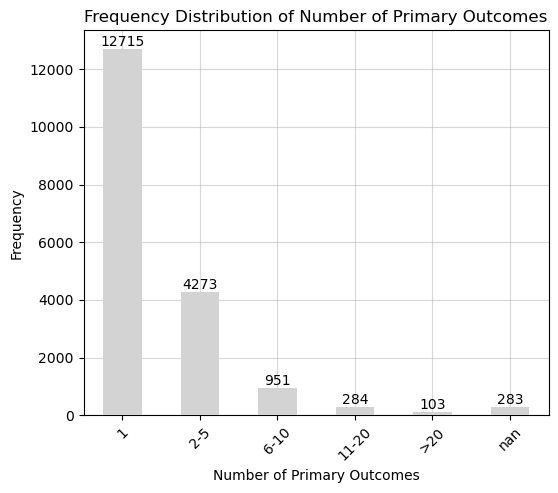

(None,
 binned_primary_outcomes
 1        12715.0
 2-5       4273.0
 6-10       951.0
 11-20      284.0
 >20        103.0
 NaN        283.0
 Name: count, dtype: float64)

In [136]:
unique_pairs_primary_outocome = trial_design[['nct_id', 'number_of_primary_outcomes_to_measure']].drop_duplicates()

# Convert the 'number_of_primary_outcomes_to_measure' column to numeric, setting errors='coerce' to handle 'not reported' values
unique_pairs_primary_outocome['number_of_primary_outcomes_to_measure'] = pd.to_numeric(unique_pairs_primary_outocome['number_of_primary_outcomes_to_measure'], errors='coerce')

# Define the bins and labels up to >30
bins = [0, 2, 5, 10, 20, np.inf]
labels = ['1', '2-5', '6-10', '11-20', '>20']

# Bin the data
unique_pairs_primary_outocome['binned_primary_outcomes'] = pd.cut(unique_pairs_primary_outocome['number_of_primary_outcomes_to_measure'], bins=bins, labels=labels, right=False)

# Count occurrences in each bin including NaN for 'not reported'
bin_counts_primary_outcomes = unique_pairs_primary_outocome['binned_primary_outcomes'].value_counts().reindex(labels + [np.nan]).fillna(0)
bin_counts_primary_outcomes[np.nan] = len(unique_pairs_primary_outocome[unique_pairs_primary_outocome['number_of_primary_outcomes_to_measure'].isna()])

# Plot
plt.figure(figsize=(6, 5))

ax = bin_counts_primary_outcomes.plot(kind='bar', color='lightgrey', zorder=3)
# Adding the text labels on the bars
for i, value in enumerate(bin_counts_primary_outcomes):
    ax.text(i, value + 0.1, str(int(value)), ha='center', va='bottom')

plt.title('Frequency Distribution of Number of Primary Outcomes')
plt.xlabel('Number of Primary Outcomes')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.5)

plt.savefig(f'viz/trial_characteristics/design/nr_primary_outcomes_frequency.png')

plt.show(), bin_counts_primary_outcomes


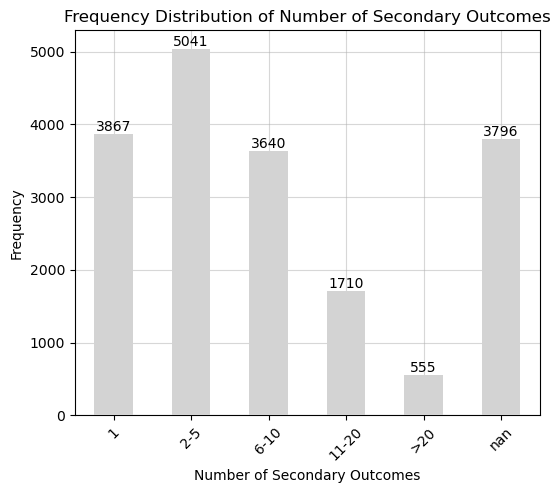

(None,
 binned_secondary_outcomes
 1        3867.0
 2-5      5041.0
 6-10     3640.0
 11-20    1710.0
 >20       555.0
 NaN      3796.0
 Name: count, dtype: float64)

In [131]:
unique_pairs_secondary_outocome = trial_design[['nct_id', 'number_of_secondary_outcomes_to_measure']].drop_duplicates()

# Convert the 'number_of_secondary_outcomes_to_measure' column to numeric, setting errors='coerce' to handle 'not reported' values
unique_pairs_secondary_outocome['number_of_secondary_outcomes_to_measure'] = pd.to_numeric(unique_pairs_secondary_outocome['number_of_secondary_outcomes_to_measure'], errors='coerce')

# Define the bins and labels
bins = [0, 2, 5, 10, 20, np.inf]
labels = ['1', '2-5', '6-10', '11-20', '>20']

# Bin the data
unique_pairs_secondary_outocome['binned_secondary_outcomes'] = pd.cut(unique_pairs_secondary_outocome['number_of_secondary_outcomes_to_measure'], bins=bins, labels=labels, right=False)

# Count occurrences in each bin including NaN for 'not reported'
bin_counts_secondary_outcomes = unique_pairs_secondary_outocome['binned_secondary_outcomes'].value_counts().reindex(labels + [np.nan]).fillna(0)
bin_counts_secondary_outcomes[np.nan] = len(unique_pairs_secondary_outocome[unique_pairs_secondary_outocome['number_of_secondary_outcomes_to_measure'].isna()])

# Plot
plt.figure(figsize=(6, 5))

ax = bin_counts_secondary_outcomes.plot(kind='bar', color='lightgrey', zorder=3)
# Adding the text labels on the bars
for i, value in enumerate(bin_counts_secondary_outcomes):
    ax.text(i, value + 0.1, str(int(value)), ha='center', va='bottom')

plt.title('Frequency Distribution of Number of Secondary Outcomes')
plt.xlabel('Number of Secondary Outcomes')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.5)

plt.savefig(f'viz/trial_characteristics/design/nr_secondary_outcomes_frequency.png')

plt.show(), bin_counts_secondary_outcomes


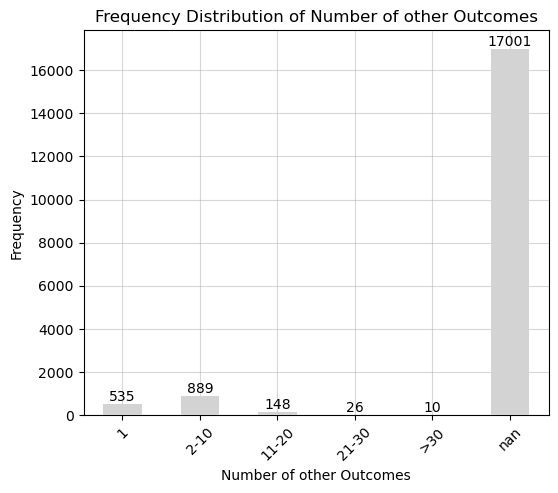

(None,
 binned_other_outcomes
 1          535.0
 2-10       889.0
 11-20      148.0
 21-30       26.0
 >30         10.0
 NaN      17001.0
 Name: count, dtype: float64)

In [133]:
unique_pairs_other_outocome = trial_design[['nct_id', 'number_of_other_outcomes_to_measure']].drop_duplicates()

# Convert the 'number_of_other_outcomes_to_measure' column to numeric, setting errors='coerce' to handle 'not reported' values
unique_pairs_other_outocome['number_of_other_outcomes_to_measure'] = pd.to_numeric(unique_pairs_other_outocome['number_of_other_outcomes_to_measure'], errors='coerce')

# Define the bins and labels
bins = [0, 2, 10, 20, 30, np.inf]
labels = ['1', '2-10', '11-20', '21-30', '>30']

# Bin the data
unique_pairs_other_outocome['binned_other_outcomes'] = pd.cut(unique_pairs_other_outocome['number_of_other_outcomes_to_measure'], bins=bins, labels=labels, right=False)

# Count occurrences in each bin including NaN for 'not reported'
bin_counts_other_outcomes = unique_pairs_other_outocome['binned_other_outcomes'].value_counts().reindex(labels + [np.nan]).fillna(0)
bin_counts_other_outcomes[np.nan] = len(unique_pairs_other_outocome[unique_pairs_other_outocome['number_of_other_outcomes_to_measure'].isna()])

# Plot
plt.figure(figsize=(6, 5))

ax = bin_counts_other_outcomes.plot(kind='bar', color='lightgrey', zorder=3)
# Adding the text labels on the bars
for i, value in enumerate(bin_counts_other_outcomes):
    ax.text(i, value + 0.1, str(int(value)), ha='center', va='bottom')

plt.title('Frequency Distribution of Number of other Outcomes')
plt.xlabel('Number of other Outcomes')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.5)

plt.savefig(f'viz/trial_characteristics/design/nr_other_outcomes_frequency.png')

plt.show(), bin_counts_other_outcomes

#### combined

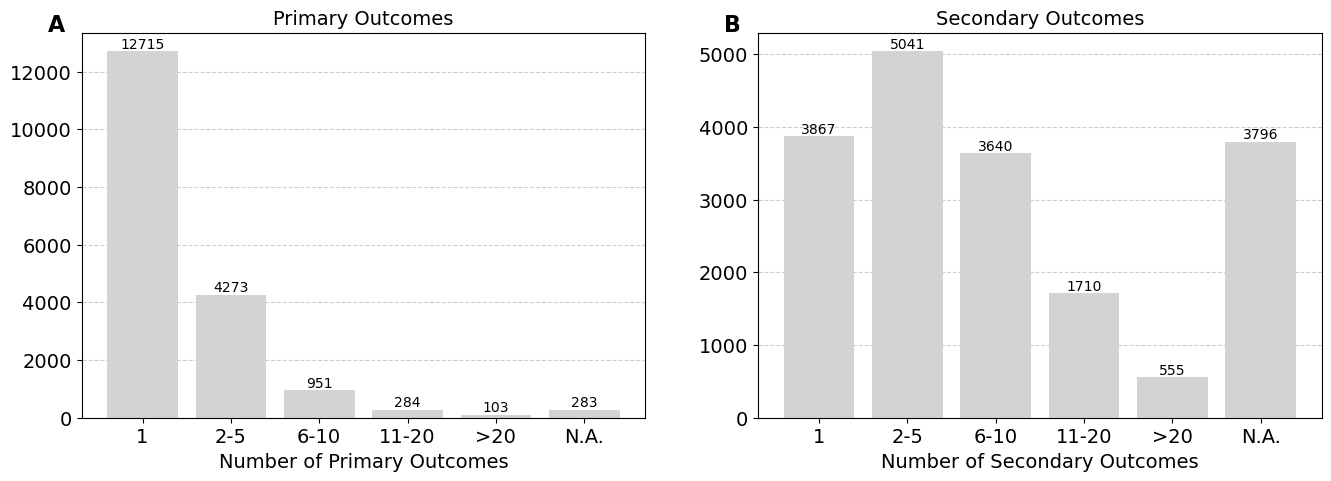

In [203]:
# Plot A
unique_pairs_primary_outocome = trial_design[['nct_id', 'number_of_primary_outcomes_to_measure']].drop_duplicates()

# Convert the 'number_of_primary_outcomes_to_measure' column to numeric, setting errors='coerce' to handle 'not reported' values
unique_pairs_primary_outocome['number_of_primary_outcomes_to_measure'] = pd.to_numeric(unique_pairs_primary_outocome['number_of_primary_outcomes_to_measure'], errors='coerce')

# Define the bins and labels up to >30
bins = [0, 2, 5, 10, 20, np.inf]
labels = ['1', '2-5', '6-10', '11-20', '>20']

# Bin the data
unique_pairs_primary_outocome['binned_primary_outcomes'] = pd.cut(unique_pairs_primary_outocome['number_of_primary_outcomes_to_measure'], bins=bins, labels=labels, right=False)

# Count occurrences in each bin including NaN for 'not reported'
bin_counts_primary_outcomes = unique_pairs_primary_outocome['binned_primary_outcomes'].value_counts().reindex(labels + [np.nan]).fillna(0)
bin_counts_primary_outcomes[np.nan] = len(unique_pairs_primary_outocome[unique_pairs_primary_outocome['number_of_primary_outcomes_to_measure'].isna()])

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

bin_counts_primary_outcomes = bin_counts_primary_outcomes.rename(index={pd.NA: 'N.A.'})
bin_counts_primary_outcomes.index = bin_counts_primary_outcomes.index.fillna('N.A.').astype(str)
# Plot A
bars_0 = axs[0].bar(bin_counts_primary_outcomes.index, bin_counts_primary_outcomes, color='lightgrey', zorder=2)

for i, value in enumerate(bin_counts_primary_outcomes):
    axs[0].text(i, value + 0.1, str(int(value)), ha='center', va='bottom')
    
axs[0].tick_params(axis='y', labelsize=14)
axs[0].tick_params(axis='x', labelsize=14)
axs[0].grid(axis='y', linestyle='--', alpha=0.6, zorder=1)
axs[0].set_xlabel('Number of Primary Outcomes', fontsize=14)
axs[0].set_title('Primary Outcomes', fontsize=14)
axs[0].text(-0.03, 1.05, 'A', transform=axs[0].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

# Plot B
unique_pairs_secondary_outocome = trial_design[['nct_id', 'number_of_secondary_outcomes_to_measure']].drop_duplicates()

# Convert the 'number_of_secondary_outcomes_to_measure' column to numeric, setting errors='coerce' to handle 'not reported' values
unique_pairs_secondary_outocome['number_of_secondary_outcomes_to_measure'] = pd.to_numeric(unique_pairs_secondary_outocome['number_of_secondary_outcomes_to_measure'], errors='coerce')

# Define the bins and labels
bins = [0, 2, 5, 10, 20, np.inf]
labels = ['1', '2-5', '6-10', '11-20', '>20']

# Bin the data
unique_pairs_secondary_outocome['binned_secondary_outcomes'] = pd.cut(unique_pairs_secondary_outocome['number_of_secondary_outcomes_to_measure'], bins=bins, labels=labels, right=False)

# Count occurrences in each bin including NaN for 'not reported'
bin_counts_secondary_outcomes = unique_pairs_secondary_outocome['binned_secondary_outcomes'].value_counts().reindex(labels + [np.nan]).fillna(0)
bin_counts_secondary_outcomes[np.nan] = len(unique_pairs_secondary_outocome[unique_pairs_secondary_outocome['number_of_secondary_outcomes_to_measure'].isna()])
bin_counts_secondary_outcomes = bin_counts_secondary_outcomes.rename(index={pd.NA: 'N.A.'})
bin_counts_secondary_outcomes.index = bin_counts_secondary_outcomes.index.fillna('N.A.').astype(str)

bars_1 = axs[1].bar(bin_counts_secondary_outcomes.index, bin_counts_secondary_outcomes, color='lightgrey', zorder=2)

for i, value in enumerate(bin_counts_secondary_outcomes):
    axs[1].text(i, value + 0.1, str(int(value)), ha='center', va='bottom')
    
axs[1].tick_params(axis='y', labelsize=14)
axs[1].tick_params(axis='x', labelsize=14)
axs[1].grid(axis='y', linestyle='--', alpha=0.6, zorder=1)
axs[1].set_xlabel('Number of Secondary Outcomes', fontsize=14)
axs[1].set_title('Secondary Outcomes', fontsize=14)
axs[1].text(-0.03, 1.05, 'B', transform=axs[1].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

# Save the plot to a local folder
plt.savefig(f'viz/trial_characteristics/design/outcomes_primary_secondary_number_frequency_{len(unique_pairs_primary_outocome)}.pdf')

# Display the plots
plt.show()


#### 2x2 figure on outcomes, facilities, participants

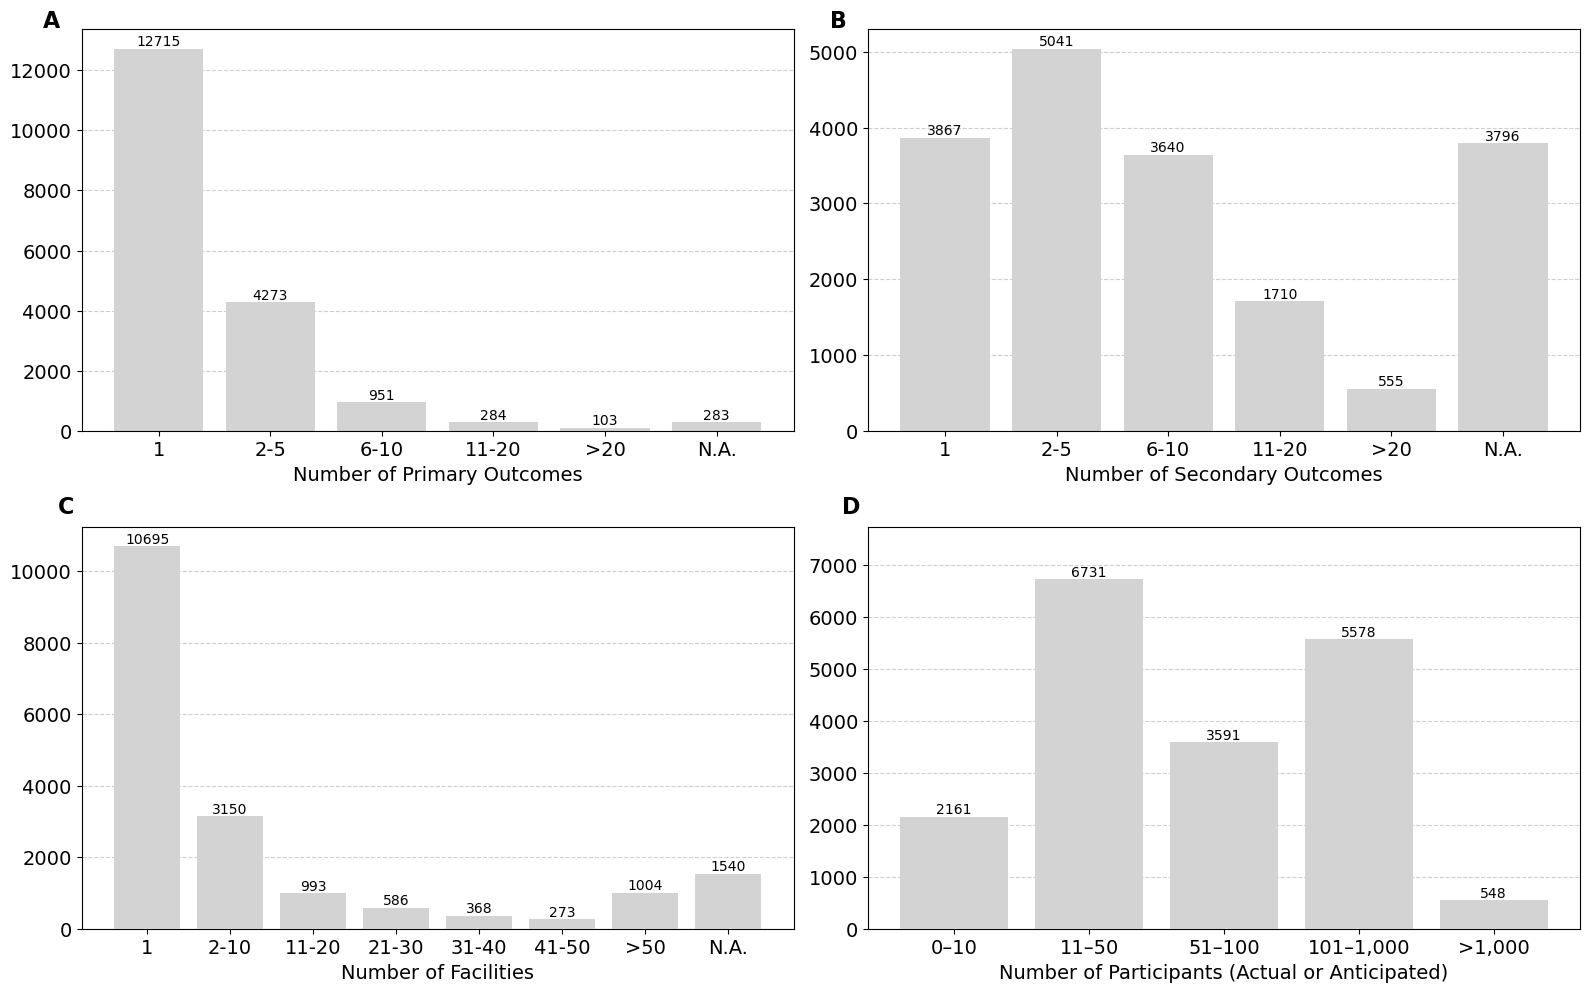

In [205]:
# Create the figure with 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 10))

# Plot A: Primary Outcomes
bars_0 = axs[0, 0].bar(bin_counts_primary_outcomes.index, bin_counts_primary_outcomes, color='lightgrey', zorder=2)
for i, value in enumerate(bin_counts_primary_outcomes):
    axs[0, 0].text(i, value + 0.1, str(int(value)), ha='center', va='bottom')
axs[0, 0].tick_params(axis='y', labelsize=14)
axs[0, 0].tick_params(axis='x', labelsize=14)
axs[0, 0].grid(axis='y', linestyle='--', alpha=0.6, zorder=1)
axs[0, 0].set_xlabel('Number of Primary Outcomes', fontsize=14)
#axs[0, 0].set_title('Primary Outcomes', fontsize=14)
axs[0, 0].text(-0.03, 1.05, 'A', transform=axs[0, 0].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

# Plot B: Secondary Outcomes
bars_1 = axs[0, 1].bar(bin_counts_secondary_outcomes.index, bin_counts_secondary_outcomes, color='lightgrey', zorder=2)
for i, value in enumerate(bin_counts_secondary_outcomes):
    axs[0, 1].text(i, value + 0.1, str(int(value)), ha='center', va='bottom')
axs[0, 1].tick_params(axis='y', labelsize=14)
axs[0, 1].tick_params(axis='x', labelsize=14)
axs[0, 1].grid(axis='y', linestyle='--', alpha=0.6, zorder=1)
axs[0, 1].set_xlabel('Number of Secondary Outcomes', fontsize=14)
#axs[0, 1].set_title('Secondary Outcomes', fontsize=14)
axs[0, 1].text(-0.03, 1.05, 'B', transform=axs[0, 1].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

# Plot C: Number of Facilities
bin_counts_facilities = bin_counts_facilities.rename(index={np.nan: 'N.A.'})
bars_facilities = axs[1, 0].bar(bin_counts_facilities.index.astype(str), bin_counts_facilities, color='lightgrey', zorder=3)
for i, value in enumerate(bin_counts_facilities):
    axs[1, 0].text(i, value + 0.1, str(int(value)), ha='center', va='bottom')
axs[1, 0].tick_params(axis='y', labelsize=14)
axs[1, 0].tick_params(axis='x', labelsize=14)
axs[1, 0].grid(axis='y', linestyle='--', alpha=0.6, zorder=1)
axs[1, 0].set_xlabel('Number of Facilities', fontsize=14)
#axs[1, 0].set_title('Number of Facilities', fontsize=14)
axs[1, 0].text(-0.01, 1.08, 'C', transform=axs[1, 0].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

# Plot D: Number of Enrolled Participants
bars_enrollment = axs[1, 1].bar(enrollment_class_counts.index, enrollment_class_counts.values, color='lightgrey', zorder=3)
for i, value in enumerate(enrollment_class_counts):
    axs[1, 1].text(i, value + 0.1, str(int(value)), ha='center', va='bottom')
axs[1, 1].tick_params(axis='y', labelsize=14)
axs[1, 1].tick_params(axis='x', labelsize=14)
axs[1, 1].grid(axis='y', linestyle='--', alpha=0.6, zorder=1)
axs[1, 1].set_xlabel('Number of Participants (Actual or Anticipated)', fontsize=14)
#axs[1, 1].set_title('Number of Enrolled Participants', fontsize=14)
axs[1, 1].text(-0.01, 1.08, 'D', transform=axs[1, 1].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
axs[1, 1].set_ylim(0, max(enrollment_class_counts) + 1000)

plt.tight_layout()

# Save the combined plot to a local folder
plt.savefig(f'viz/trial_characteristics/design/combined_outcomes_facilities_enrollment_{len(unique_pairs_primary_outocome)}.pdf')

# Display the combined plots
plt.show()


## Reported Results

In [167]:
df.columns

Index(['nct_id', 'start_date', 'completion_date', 'phase', 'overall_status',
       'country_name', 'primary_purpose', 'allocation', 'masking',
       'number_of_facilities', 'were_results_reported',
       'months_to_report_results', 'number_of_primary_outcomes_to_measure',
       'number_of_secondary_outcomes_to_measure',
       'number_of_other_outcomes_to_measure', 'agency_class',
       'lead_or_collaborator', 'sponsor_name', 'facility_name', 'country',
       'start_year', 'completion_year'],
      dtype='object')

In [236]:
df_results_reported = df[['nct_id', 'start_year', 'completion_year','were_results_reported', 'months_to_report_results', 'overall_status']].drop_duplicates()
print(df_results_reported.shape)
df_results_reported = df_results_reported[df_results_reported['overall_status']=='Completed']
print(df_results_reported.shape)

df_results_reported = df_results_reported[df_results_reported['completion_year']<2022]

df_results_reported.head()

(18609, 6)
(11411, 6)


nct_id  start_year  completion_year  were_results_reported  \
2285  NCT00000307        2003           2007.0                  False   
2379  NCT00000333        2001           2003.0                  False   
2712  NCT00000428        2000           2004.0                  False   
2754  NCT00000439        2000           2003.0                  False   
6266  NCT00001956        2000           2005.0                  False   

      months_to_report_results overall_status  
2285                       NaN      Completed  
2379                       NaN      Completed  
2712                       NaN      Completed  
2754                       NaN      Completed  
6266                       NaN      Completed

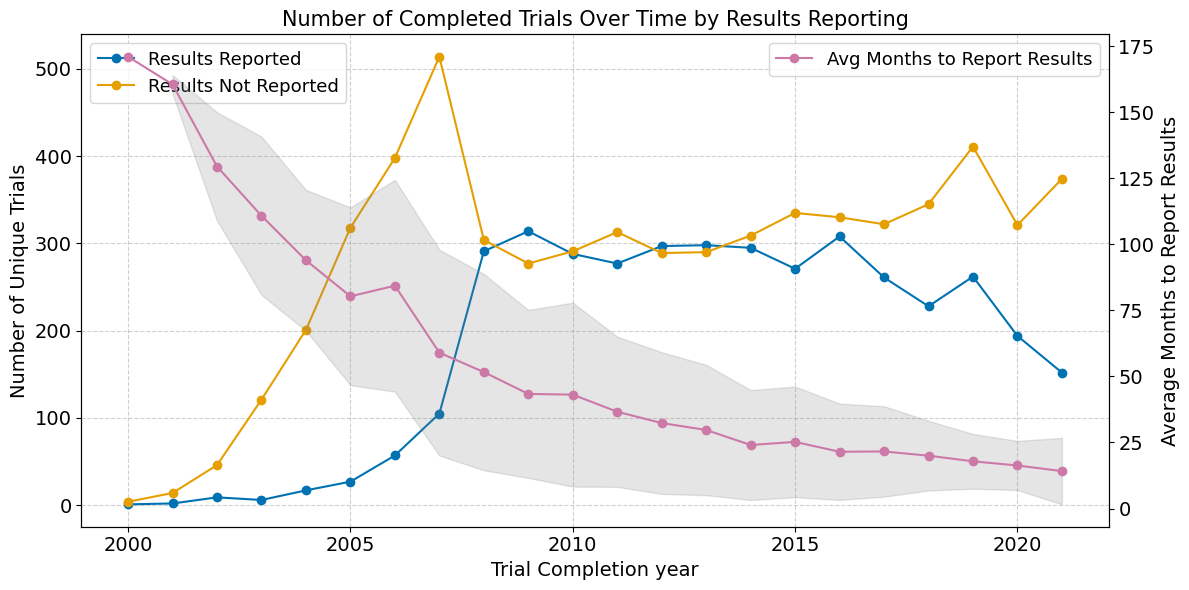

In [237]:
year_to_use = 'completion_year'

# Group by start_year and were_results_reported, then count unique nct_ids
results_over_time = df_results_reported.groupby([year_to_use, 'were_results_reported'])['nct_id'].nunique().unstack(fill_value=0)

# Filter data for reported results
reported_results = df_results_reported[df_results_reported['were_results_reported'] == True]

# Calculate average months to report results and standard deviation
average_months_to_report = reported_results.groupby(year_to_use)['months_to_report_results'].mean()
std_months_to_report = reported_results.groupby(year_to_use)['months_to_report_results'].std()

# Create a line chart
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot for trials with results reported
ax1.plot(results_over_time.index, results_over_time[True], marker='o', label='Results Reported', color='#0072B2')

# Plot for trials without results reported
ax1.plot(results_over_time.index, results_over_time[False], marker='o', label='Results Not Reported', color='#E69F00')

ax1.set_xlabel("Trial " + year_to_use.replace("_"," ").capitalize(), fontsize=14)
ax1.set_ylabel('Number of Unique Trials', fontsize=14)
ax1.set_title('Number of Completed Trials Over Time by Results Reporting', fontsize=15)
ax1.legend(loc='upper left', title='', fontsize=13)
ax1.grid(linestyle='--', alpha=0.6, zorder=1)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)

# Create a secondary y-axis for the average months to report results
ax2 = ax1.twinx()
ax2.plot(average_months_to_report.index, average_months_to_report, marker='o', label='Avg Months to Report Results', color='#CC79A7')
ax2.fill_between(average_months_to_report.index, average_months_to_report - std_months_to_report, average_months_to_report + std_months_to_report, color='grey', alpha=0.2)
ax2.set_ylabel('Average Months to Report Results', fontsize=14)
ax2.tick_params(axis='y', labelsize=14)
ax2.legend(loc='upper right', title='', fontsize=13)
plt.tight_layout()
plt.savefig(f'viz/trial_characteristics/completed_trials_results_reporting_{len(df_results_reported)}.pdf')



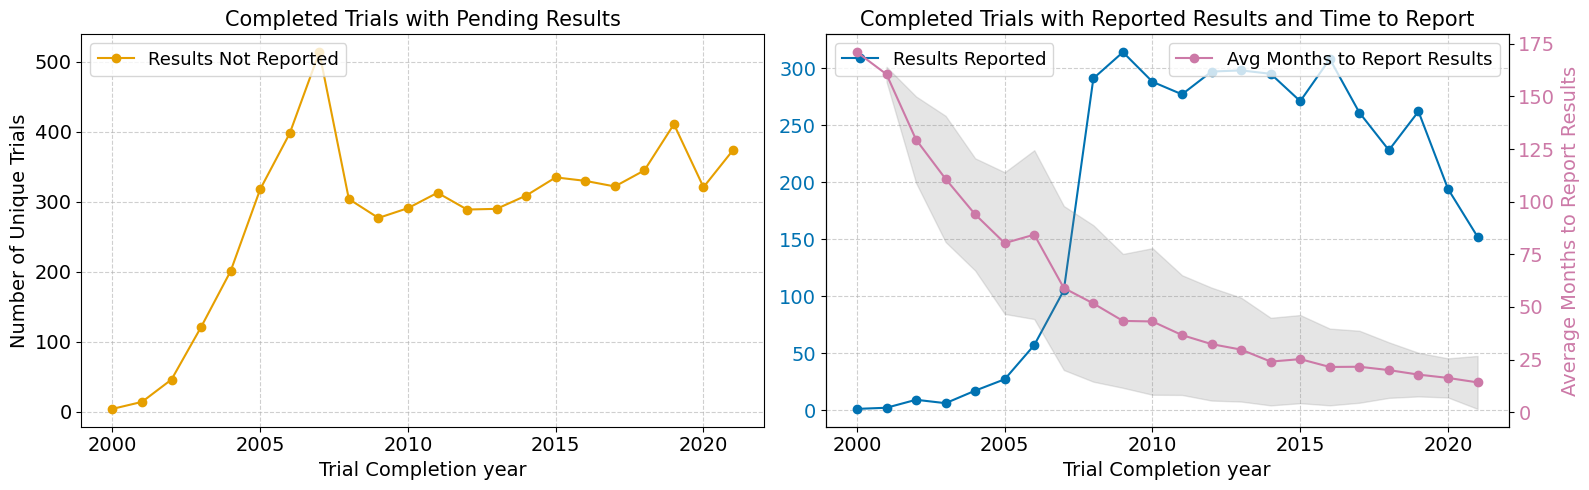

In [238]:
import matplotlib.pyplot as plt

year_to_use = 'completion_year'

# Group by start_year and were_results_reported, then count unique nct_ids
results_over_time = df_results_reported.groupby([year_to_use, 'were_results_reported'])['nct_id'].nunique().unstack(fill_value=0)

# Filter data for reported results
reported_results = df_results_reported[df_results_reported['were_results_reported'] == True]

# Calculate average months to report results and standard deviation
average_months_to_report = reported_results.groupby(year_to_use)['months_to_report_results'].mean()
std_months_to_report = reported_results.groupby(year_to_use)['months_to_report_results'].std()

# Create subplots
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 5))

# Subplot 1: Results Not Reported
ax1.plot(results_over_time.index, results_over_time[False], marker='o', label='Results Not Reported', color='#E69F00')
ax1.set_xlabel("Trial " + year_to_use.replace("_"," ").capitalize(), fontsize=14)
ax1.set_ylabel('Number of Unique Trials', fontsize=14)
ax1.set_title('Completed Trials with Pending Results', fontsize=15)
ax1.legend(loc='upper left', title='', fontsize=13)
ax1.grid(linestyle='--', alpha=0.6, zorder=1)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)

# Subplot 2: Results Reported and Months to Report Results
ax2.plot(results_over_time.index, results_over_time[True], marker='o', label='Results Reported', color='#0072B2')
ax2.set_xlabel("Trial " + year_to_use.replace("_"," ").capitalize(), fontsize=14)
#ax2.set_ylabel('Number of Unique Trials', fontsize=14, color='#0072B2')
ax2.set_title('Completed Trials with Reported Results and Time to Report', fontsize=15)
ax2.tick_params(axis='y', labelsize=14, labelcolor='#0072B2')
ax2.legend(loc='upper left', title='', fontsize=13)
ax2.tick_params(axis='x', labelsize=14)
ax2.grid(linestyle='--', alpha=0.6, zorder=1)

# Create a secondary y-axis for the average months to report results
ax3 = ax2.twinx()
ax3.plot(average_months_to_report.index, average_months_to_report, marker='o', label='Avg Months to Report Results', color='#CC79A7')
ax3.fill_between(average_months_to_report.index, average_months_to_report - std_months_to_report, average_months_to_report + std_months_to_report, color='grey', alpha=0.2)
ax3.set_ylabel('Average Months to Report Results', fontsize=14, color='#CC79A7')
ax3.tick_params(axis='y', labelsize=14, labelcolor='#CC79A7')
ax3.legend(loc='upper right', title='', fontsize=13)

plt.tight_layout()
plt.savefig(f'viz/trial_characteristics/completed_trials_results_reporting_line_charts_{len(df_results_reported)}.pdf')
plt.show()


/var/folders/nd/2fzvhsh510gbt9x6z5pdb1gr0000gn/T/ipykernel_68110/3128286774.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels(['{:.0f}%'.format(x * 100) for x in ax1.get_yticks()])


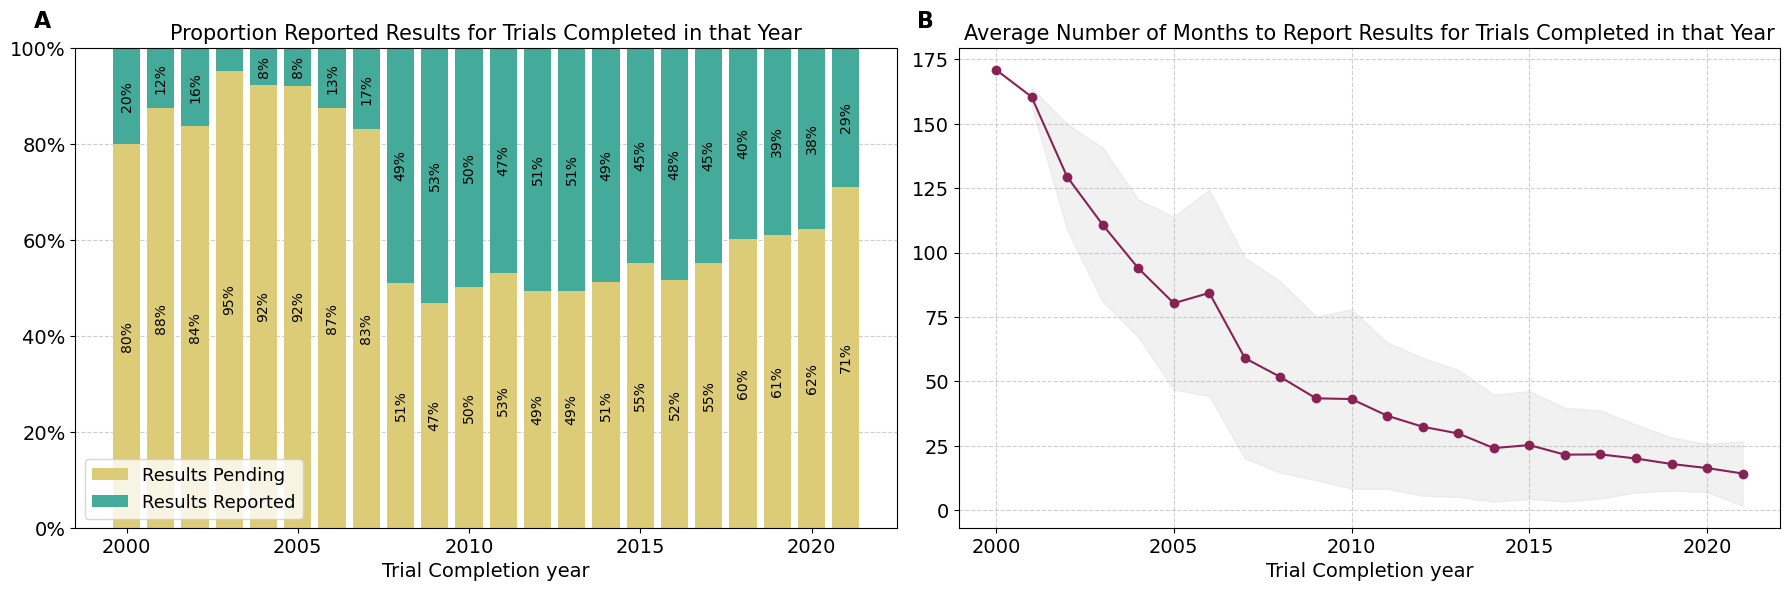

In [239]:
import matplotlib.pyplot as plt
import numpy as np

year_to_use = 'completion_year'

# Group by completion_year and were_results_reported, then count unique nct_ids
results_over_time = df_results_reported.groupby([year_to_use, 'were_results_reported'])['nct_id'].nunique().unstack(fill_value=0)

# Calculate the proportion of each type
results_proportion_over_time = results_over_time.div(results_over_time.sum(axis=1), axis=0)

# Filter data for reported results
reported_results = df_results_reported[df_results_reported['were_results_reported'] == True]

# Calculate average months to report results and standard deviation
average_months_to_report = reported_results.groupby(year_to_use)['months_to_report_results'].mean()
std_months_to_report = reported_results.groupby(year_to_use)['months_to_report_results'].std()

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Subplot 1: Stacked bar chart for results reported/results pending
bottom = np.zeros(len(results_proportion_over_time))
colors = {False: '#DDCC77', True: '#44AA99'}
for reported in [False, True]:
    label = 'Results Reported' if reported else 'Results Pending'
    bars = ax1.bar(results_proportion_over_time.index, 
                   results_proportion_over_time[reported], 
                   bottom=bottom, 
                   label=label, 
                   color=colors[reported], zorder=2)
    bottom += results_proportion_over_time[reported]

    # Add labels to each segment
    for bar in bars:
        height = bar.get_height()
        if height > 0.05:
            ax1.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2, f'{height*100:.0f}%', 
                     ha='center', va='center', fontsize=10, rotation=90)

ax1.set_xlabel("Trial " + year_to_use.replace("_", " ").capitalize(), fontsize=14)
#ax1.set_ylabel('Proportion of Trials', fontsize=14)
ax1.set_title('Proportion Reported Results for Trials Completed in that Year', fontsize=15)
ax1.legend(loc='lower left', title='', fontsize=13)
ax1.grid(linestyle='--', alpha=0.6, zorder=1)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
ax1.set_ylim(0, 1)
ax1.set_yticklabels(['{:.0f}%'.format(x * 100) for x in ax1.get_yticks()])
ax1.text(-0.03, 1.08, 'A', transform=ax1.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')


# Subplot 2: Line chart for months to report results
ax2.plot(average_months_to_report.index, average_months_to_report, marker='o', label='Avg Months to Report Results', color='#882255')
ax2.fill_between(average_months_to_report.index, average_months_to_report - std_months_to_report, average_months_to_report + std_months_to_report, color='lightgrey', alpha=0.3)
ax2.set_xlabel("Trial " + year_to_use.replace("_", " ").capitalize(), fontsize=14)
#ax2.set_ylabel('Average Months to Report Results', fontsize=14)
ax2.set_title('Average Number of Months to Report Results for Trials Completed in that Year', fontsize=15)
#ax2.legend(loc='upper right', title='', fontsize=13)
ax2.grid(linestyle='--', alpha=0.6, zorder=1)
ax2.tick_params(axis='x', labelsize=14)
ax2.tick_params(axis='y', labelsize=14)
ax2.text(-0.03, 1.08, 'B', transform=ax2.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

plt.tight_layout()
plt.savefig(f'viz/trial_characteristics/completed_trials_results_reporting_{len(df_results_reported)}_completion_year_before_2022.pdf')
plt.show()


In [269]:
sum(results_over_time[False])

7343

In [284]:
sum(results_over_time[False])/ n_trials

0.6381887710759604

In [286]:
sum(results_over_time[True])

4163

In [285]:
sum(results_over_time[True])/ n_trials

0.3618112289240396

### combined allocation, masking, results reporting

/var/folders/nd/2fzvhsh510gbt9x6z5pdb1gr0000gn/T/ipykernel_68110/2613218616.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0, 1].set_yticklabels(['{:.0f}%'.format(x * 100) for x in axs[0, 1].get_yticks()])
/var/folders/nd/2fzvhsh510gbt9x6z5pdb1gr0000gn/T/ipykernel_68110/2613218616.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1, 1].set_yticklabels(['{:.0f}%'.format(x * 100) for x in axs[1, 1].get_yticks()])
/var/folders/nd/2fzvhsh510gbt9x6z5pdb1gr0000gn/T/ipykernel_68110/2613218616.py:108: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[2, 0].set_yticklabels(['{:.0f}%'.format(x * 100) for x in axs[2, 0].get_yticks()])


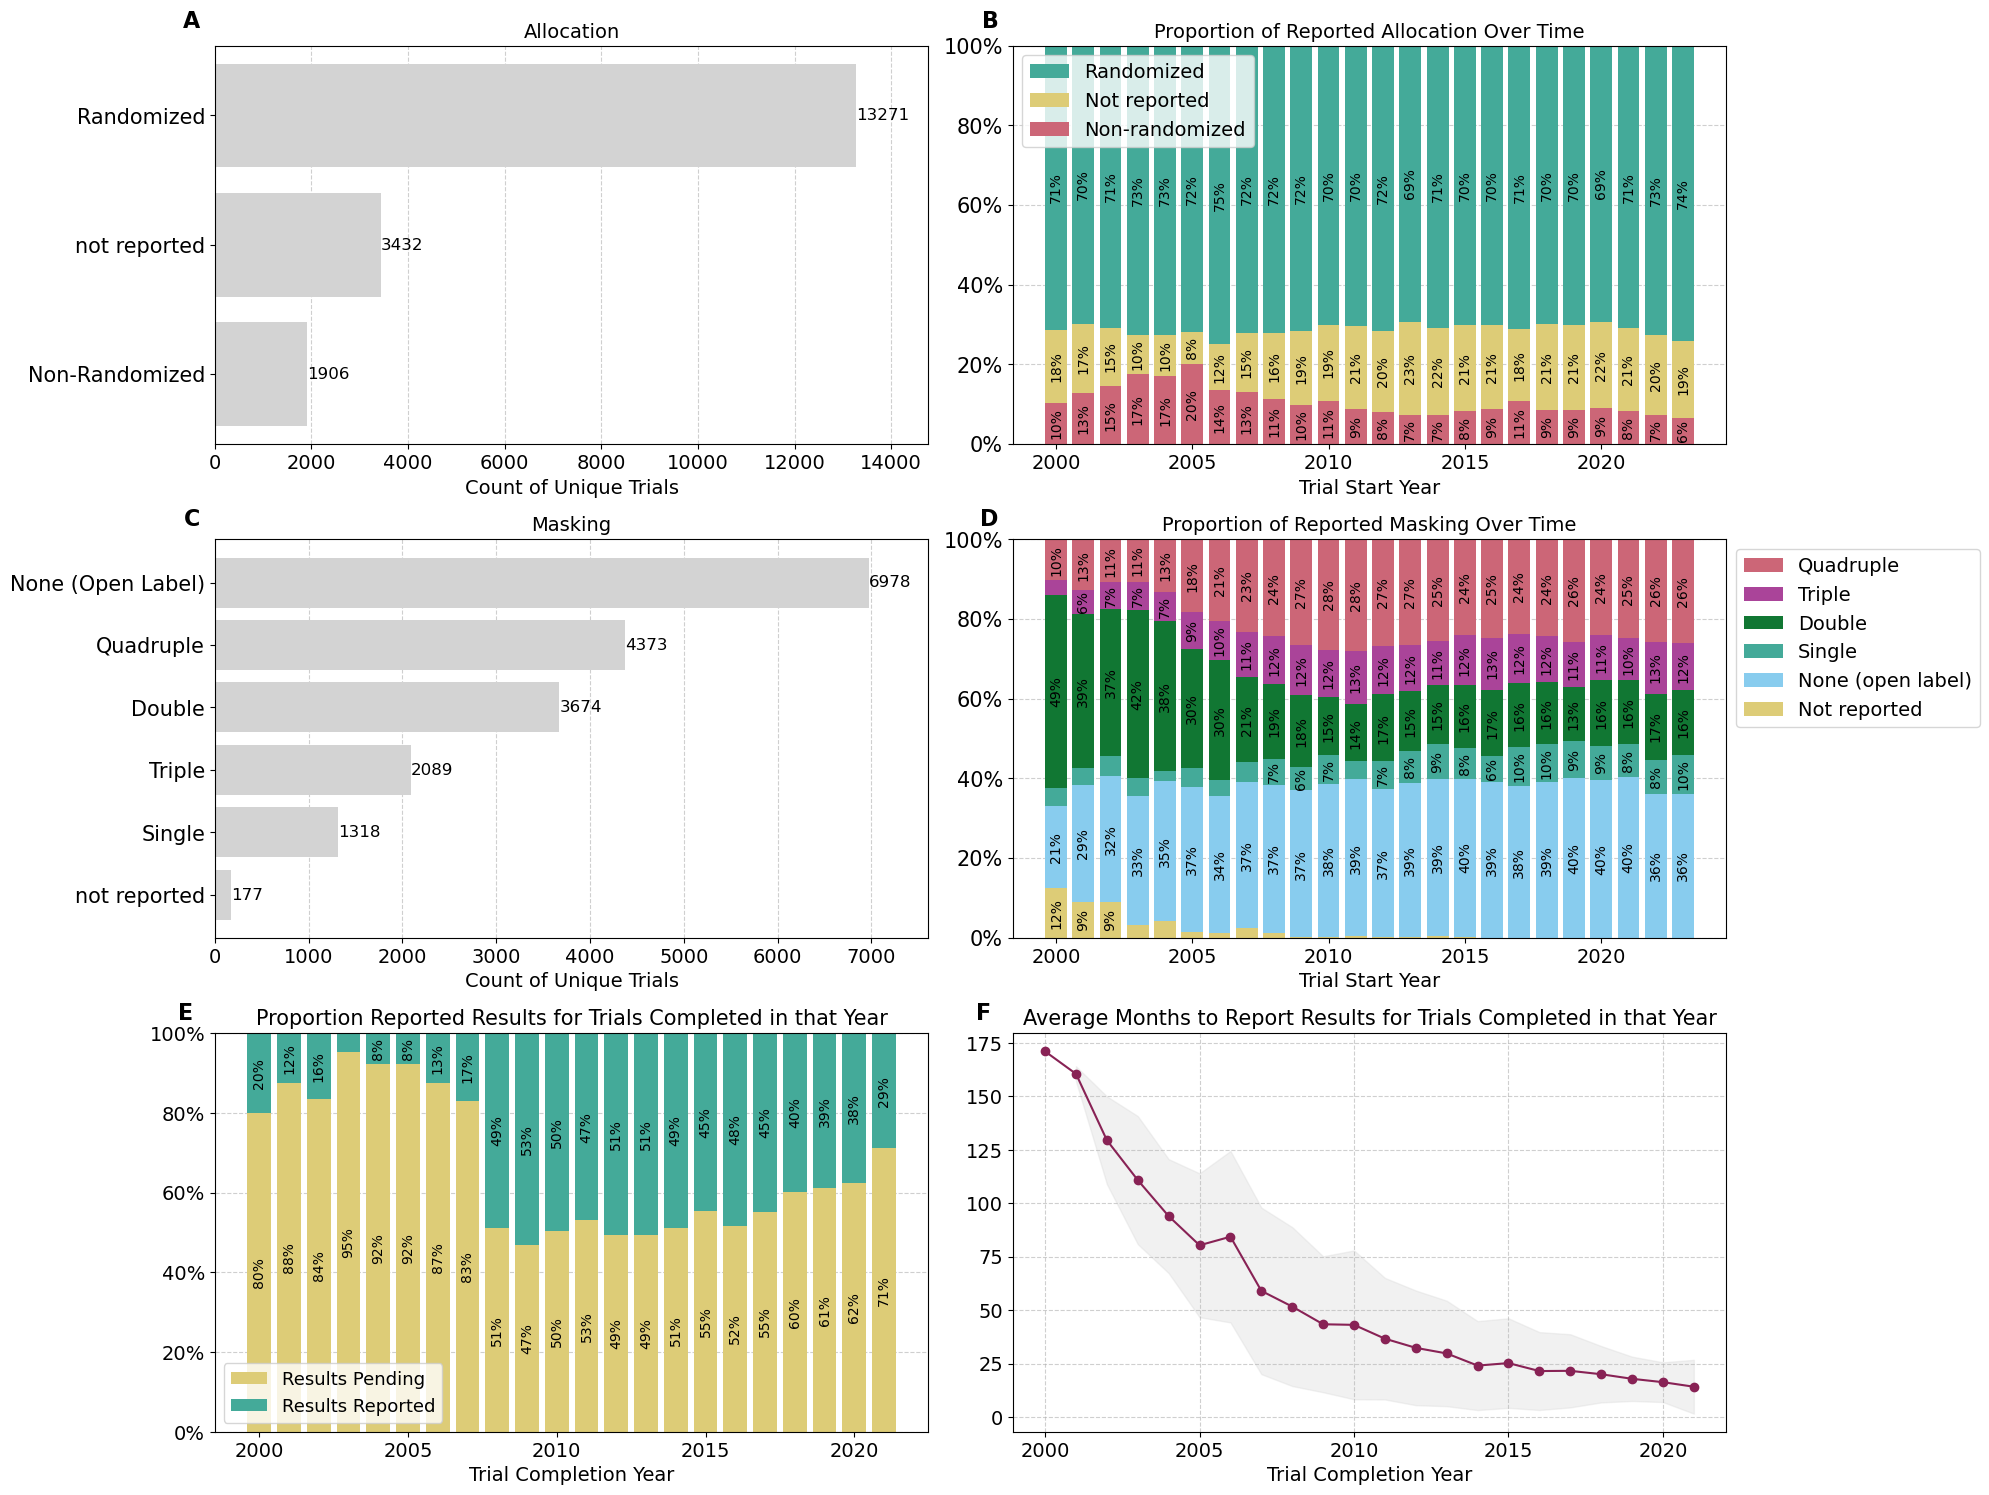

In [240]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming necessary dataframes (allocation_counts, masking_counts, etc.) are already processed

# Create a 3x2 figure for 6 panels
fig, axs = plt.subplots(3, 2, figsize=(20, 15))

# PLOT A: Allocation Frequency
bars_0 = axs[0, 0].barh(allocation_counts.index, allocation_counts, color='lightgrey', zorder=2)
for bar in bars_0:
    width = bar.get_width()
    axs[0, 0].text(width, bar.get_y() + bar.get_height() / 2, f'{width}', va='center', fontsize=12)
axs[0, 0].tick_params(axis='y', labelsize=15)
axs[0, 0].tick_params(axis='x', labelsize=14)
axs[0, 0].grid(axis='x', linestyle='--', alpha=0.6, zorder=1)
axs[0, 0].set_xlabel('Count of Unique Trials', fontsize=14)
axs[0, 0].set_title('Allocation', fontsize=14)
axs[0, 0].set_xlim(0, max(allocation_counts) + 1500)
axs[0, 0].text(-0.02, 1.09, 'A', transform=axs[0, 0].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

# PLOT B: Allocation Proportion Over Time
bottom = np.zeros(len(allocation_proportion_over_time))
for allocation_type in allocation_types:
    bars = axs[0, 1].bar(allocation_proportion_over_time.index, 
                         allocation_proportion_over_time[allocation_type], 
                         bottom=bottom, label=allocation_type,
                         color=allocation_colors.get(allocation_type, 'gray'), zorder=2)
    bottom += allocation_proportion_over_time[allocation_type]
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            axs[0, 1].text(bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2, f'{height:.0%}', ha='center', va='center', fontsize=10, rotation=90)
axs[0, 1].set_xlabel('Trial Start Year', fontsize=14)
axs[0, 1].set_title('Proportion of Reported Allocation Over Time', fontsize=14)
axs[0, 1].set_ylim(0, 1)
axs[0, 1].set_yticklabels(['{:.0f}%'.format(x * 100) for x in axs[0, 1].get_yticks()])
handles, labels = axs[0, 1].get_legend_handles_labels()
sorted_handles_labels = sorted(zip(handles, labels), key=lambda x: allocation_over_time.sum().to_dict()[x[1]], reverse=True)
sorted_handles, sorted_labels = zip(*sorted_handles_labels)
axs[0, 1].legend(sorted_handles, [label.capitalize() for label in sorted_labels], fontsize=14, loc='upper left')
axs[0, 1].grid(linestyle='--', alpha=0.6, zorder=1)
axs[0, 1].tick_params(axis='x', labelsize=14)
axs[0, 1].tick_params(axis='y', labelsize=15)
axs[0, 1].text(-0.02, 1.09, 'B', transform=axs[0, 1].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

# PLOT C: Masking Frequency
bars_1 = axs[1, 0].barh(masking_counts.index, masking_counts, color='lightgrey', zorder=2)
for bar in bars_1:
    width = bar.get_width()
    axs[1, 0].text(width, bar.get_y() + bar.get_height() / 2, f'{width}', va='center', fontsize=12)
axs[1, 0].tick_params(axis='y', labelsize=15)
axs[1, 0].tick_params(axis='x', labelsize=14)
axs[1, 0].grid(axis='x', linestyle='--', alpha=0.6, zorder=1)
axs[1, 0].set_xlabel('Count of Unique Trials', fontsize=14)
axs[1, 0].set_title('Masking', fontsize=14)
axs[1, 0].set_xlim(0, max(masking_counts) + 630)
axs[1, 0].text(-0.02, 1.08, 'C', transform=axs[1, 0].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

# PLOT D: Masking Proportion Over Time
bottom = np.zeros(len(masking_proportion_over_time))
for masking_type in masking_types:
    bars = axs[1, 1].bar(masking_proportion_over_time.index, 
                         masking_proportion_over_time[masking_type], 
                         bottom=bottom, label=masking_type,
                         color=masking_colors.get(masking_type, 'gray'), zorder=2)
    bottom += masking_proportion_over_time[masking_type]
    for bar in bars:
        height = bar.get_height()
        if height > 0.055:
            axs[1, 1].text(bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2, f'{height:.0%}', ha='center', va='center', fontsize=10, rotation=90)
axs[1, 1].set_xlabel('Trial Start Year', fontsize=14)
axs[1, 1].set_title('Proportion of Reported Masking Over Time', fontsize=14)
axs[1, 1].set_ylim(0, 1)
axs[1, 1].set_yticklabels(['{:.0f}%'.format(x * 100) for x in axs[1, 1].get_yticks()])
handles, labels = axs[1, 1].get_legend_handles_labels()
sorted_handles_labels = sorted(zip(handles, labels), key=lambda x: masking_types[::-1].index(x[1]))
sorted_handles, sorted_labels = zip(*sorted_handles_labels)
axs[1, 1].legend(sorted_handles, [label.capitalize() for label in sorted_labels], fontsize=14, loc='upper left', bbox_to_anchor=(1.00, 1))
axs[1, 1].grid(linestyle='--', alpha=0.6, zorder=1)
axs[1, 1].tick_params(axis='x', labelsize=14)
axs[1, 1].tick_params(axis='y', labelsize=15)
axs[1, 1].text(-0.02, 1.08, 'D', transform=axs[1, 1].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

# PLOT E: Results Reporting Over Time (New Panel)
bottom = np.zeros(len(results_proportion_over_time))
colors = {False: '#DDCC77', True: '#44AA99'}
for reported in [False, True]:
    label = 'Results Reported' if reported else 'Results Pending'
    bars = axs[2, 0].bar(results_proportion_over_time.index, 
                         results_proportion_over_time[reported], 
                         bottom=bottom, 
                         label=label, 
                         color=colors[reported], zorder=2)
    bottom += results_proportion_over_time[reported]
    for bar in bars:
        height = bar.get_height()
        if height > 0.05:
            axs[2, 0].text(bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2, f'{height*100:.0f}%', 
                           ha='center', va='center', fontsize=10, rotation=90)
axs[2, 0].set_xlabel("Trial Completion Year", fontsize=14)
axs[2, 0].set_title('Proportion Reported Results for Trials Completed in that Year', fontsize=15)
axs[2, 0].legend(loc='lower left', title='', fontsize=13)
axs[2, 0].grid(linestyle='--', alpha=0.6, zorder=1)
axs[2, 0].tick_params(axis='x', labelsize=14)
axs[2, 0].tick_params(axis='y', labelsize=14)
axs[2, 0].set_ylim(0, 1)
axs[2, 0].set_yticklabels(['{:.0f}%'.format(x * 100) for x in axs[2, 0].get_yticks()])
axs[2, 0].text(-0.03, 1.08, 'E', transform=axs[2, 0].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

# PLOT F: Average Months to Report Results Over Time (New Panel)
axs[2, 1].plot(average_months_to_report.index, average_months_to_report, marker='o', label='Avg Months to Report Results', color='#882255')
axs[2, 1].fill_between(average_months_to_report.index, average_months_to_report - std_months_to_report, average_months_to_report + std_months_to_report, color='lightgrey', alpha=0.3)
axs[2, 1].set_xlabel("Trial Completion Year", fontsize=14)
axs[2, 1].set_title('Average Months to Report Results for Trials Completed in that Year', fontsize=15)
axs[2, 1].grid(linestyle='--', alpha=0.6, zorder=1)
axs[2, 1].tick_params(axis='x', labelsize=14)
axs[2, 1].tick_params(axis='y', labelsize=14)
axs[2, 1].text(-0.03, 1.08, 'F', transform=axs[2, 1].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

# Adjust layout
plt.tight_layout()

# Save the combined plot
plt.savefig(f'viz/trial_characteristics/combined_allocation_masking_results_reporting.pdf')

# Display the combined plots
plt.show()


## Funding and Locations

In [361]:
df.columns

Index(['nct_id', 'start_date', 'completion_date', 'phase', 'overall_status',
       'country_name', 'primary_purpose', 'allocation', 'masking',
       'number_of_facilities', 'were_results_reported',
       'months_to_report_results', 'number_of_primary_outcomes_to_measure',
       'number_of_secondary_outcomes_to_measure',
       'number_of_other_outcomes_to_measure', 'agency_class',
       'lead_or_collaborator', 'sponsor_name', 'facility_name', 'country',
       'start_year', 'completion_year'],
      dtype='object')

In [363]:
df_funding = df[['nct_id', 'start_year', 'agency_class', 'lead_or_collaborator', 'sponsor_name', 'phase']].drop_duplicates()

In [364]:
df_funding.shape

(29857, 6)

Note: we filter to the lead funding.

### Leading overall and over time

In [367]:
df_funding = df_funding[df_funding['lead_or_collaborator']=='lead']
df_funding['agency_class_v2'] = df_funding.apply(replace_agency_class, axis=1)


In [368]:
df_funding[df_funding['agency_class_v2']=='UNIVERSITY']['agency_class'].value_counts()

agency_class
OTHER        5946
OTHER_GOV      28
FED             6
INDUSTRY        1
UNKNOWN         1
Name: count, dtype: int64

In [373]:
df_funding[df_funding['agency_class_v2']=='HOSPITAL']['agency_class'].value_counts()

agency_class
OTHER        1570
OTHER_GOV     141
FED            77
UNKNOWN         1
Name: count, dtype: int64

In [375]:
df_funding = df_funding[df_funding['lead_or_collaborator']=='lead']

# Apply the function
df_funding['agency_class'] = df_funding.apply(replace_agency_class, axis=1)
df_funding[df_funding['agency_class']=='OTHER']

nct_id  start_year agency_class lead_or_collaborator  \
67985    NCT00005850        2001        OTHER                 lead   
89014    NCT00006349        2001        OTHER                 lead   
89424    NCT00007189        2001        OTHER                 lead   
90526    NCT00010335        2000        OTHER                 lead   
93683    NCT00022074        2001        OTHER                 lead   
...              ...         ...          ...                  ...   
9240477  NCT06199778        2022        OTHER                 lead   
9240827  NCT06207760        2023        OTHER                 lead   
9252088  NCT06258031        2022        OTHER                 lead   
9252596  NCT06264427        2022        OTHER                 lead   
9257649  NCT06271096        2019        OTHER                 lead   

                                              sponsor_name           phase  \
67985             Alliance for Clinical Trials in Oncology         Phase 2   
89014             Alliance for Clinical Trials in Oncology         Phase 3   
89424    Seattle Institute for Biomedical and Clinical ...         Phase 3   
90526                        Fred Hutchinson Cancer Center         Phase 1   
93683                                          Gary Morrow  Not Applicable   
...                                                    ...             ...   
9240477                                      Zeng Changhao  Not Applicable   
9240827  IRCCS Centro San Giovanni di Dio Fatebenefratelli         Phase 2   
9252088                            Imperial College London         Phase 1   
9252596                    Steno Diabetes Center Greenland  Not Applicable   
9257649                                         Arooj Khan   Early Phase 1   

        agency_class_v2  
67985             OTHER  
89014             OTHER  
89424             OTHER  
90526             OTHER  
93683             OTHER  
...                 ...  
9240477           OTHER  
9240827           OTHER  
9252088           OTHER  
9252596           OTHER  
9257649           OTHER  

[3128 rows x 7 columns]

In [377]:
df_funding[df_funding['agency_class']=='OTHER'].to_csv("funding_other.csv")

In [379]:
set(df_funding['lead_or_collaborator'])

{'lead'}

18609


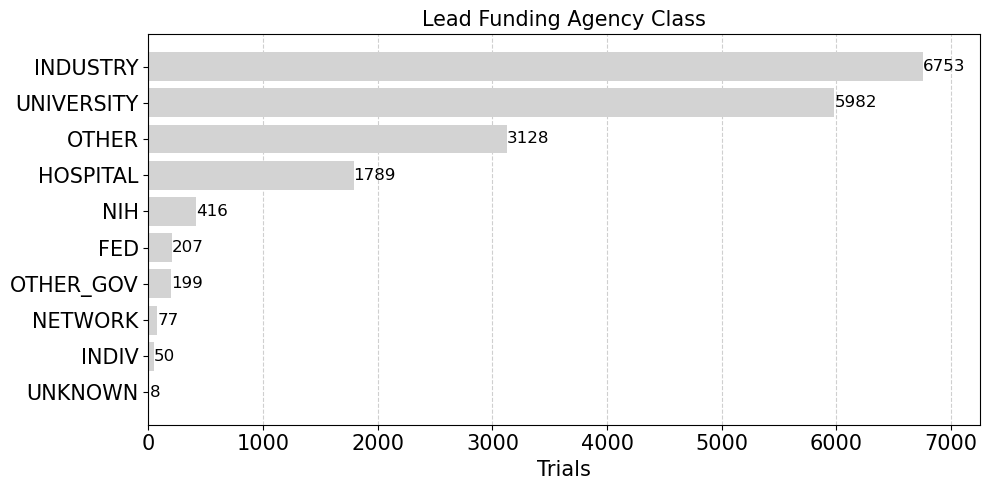

In [381]:
# Counting the number of nct_ids per phase type
funding_counts = df_funding['agency_class'].value_counts()
funding_counts = funding_counts.sort_values(ascending=True)
print(sum(funding_counts))

# Create a horizontal bar chart for the top 10 data types
plt.figure(figsize=(10, 5))
bars = plt.barh(funding_counts.index, funding_counts, color='lightgrey',zorder=2)

# Add labels to each bar
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height() / 2, f'{width}', va='center', fontsize=12)
    
plt.tick_params(axis='y', labelsize=15)
plt.tick_params(axis='x', labelsize=15)
plt.grid(axis='x', linestyle='--', alpha=0.6, zorder=1)
plt.xlabel('Trials', fontsize=15)
plt.title('Lead Funding Agency Class', fontsize=15)
plt.xlim(0, max(funding_counts)+500) # Adjusted to max count for relevancy
plt.tight_layout()

# Save the plot to a local folder
plt.savefig(f'viz/trial_characteristics/general/lead_funding_agency_{len(df_funding)}.pdf')

# Display the chart
plt.show()

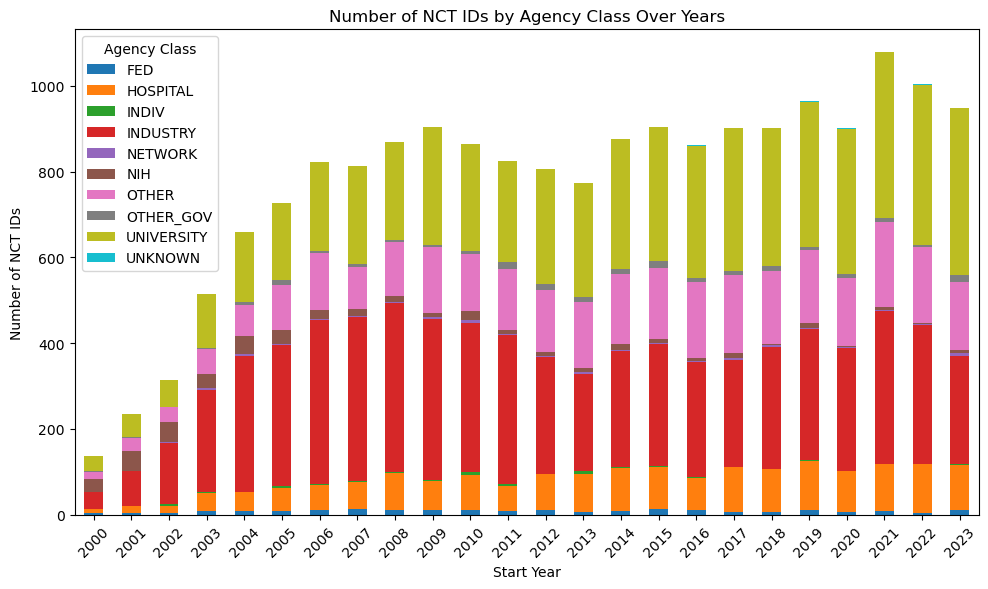

In [383]:
df_filtered = df_funding[(df_funding['start_year'] >= 2000) & (df_funding['start_year'] <= 2024)]
df_filtered['start_year'] = df_filtered['start_year'].astype(int)

pivot_table = df_filtered.pivot_table(index='start_year', columns='agency_class', values='nct_id', aggfunc='count', fill_value=0)

# Plotting the pivot table
ax = pivot_table.plot(kind='bar', stacked=True, figsize=(10, 6))  # You can also try kind='line' for a line plot
ax.set_title('Number of NCT IDs by Agency Class Over Years')
ax.set_xlabel('Start Year')
ax.set_ylabel('Number of NCT IDs')
plt.xticks(rotation=45)
plt.legend(title='Agency Class')
plt.tight_layout()  # Adjust subplots to give some room for the labels

# Show the plot
plt.show()

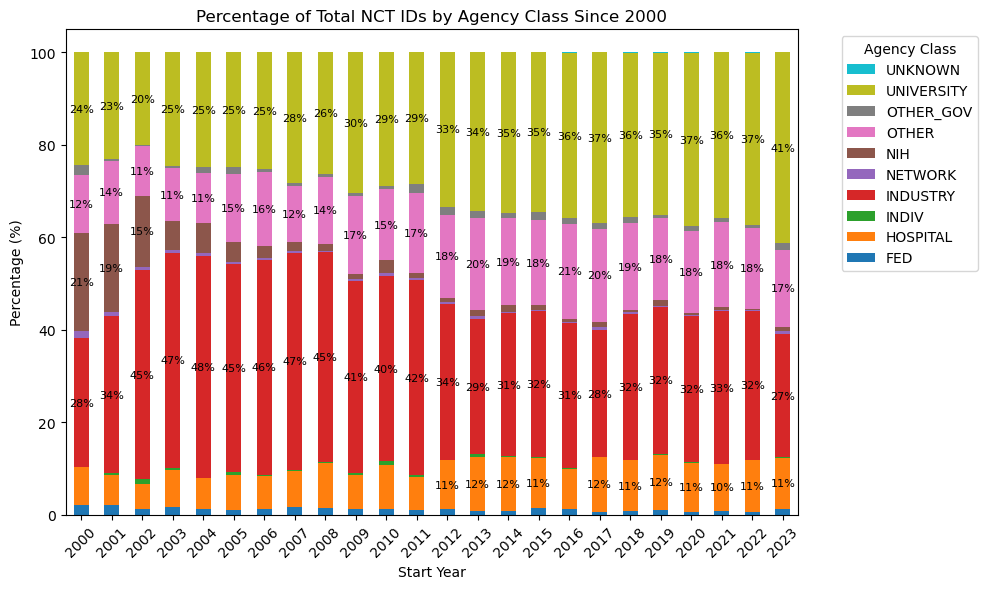

In [385]:
# Creating a pivot table with counts per agency_class and year
pivot_table_counts = df_filtered.pivot_table(index='start_year', columns='agency_class', values='nct_id', aggfunc='count', fill_value=0)

# Calculate the total for each year
total_per_year = pivot_table_counts.sum(axis=1)

# Calculate percentages and normalize to 100%
pivot_table_percentage = pivot_table_counts.divide(total_per_year, axis=0) * 100

# Verify the percentages sum to 100% per year
#print(pivot_table_percentage.sum(axis=1))  # This should print 100 for each year

fig, ax = plt.subplots(figsize=(10, 6))

bars = pivot_table_percentage.plot(kind='bar', stacked=True, ax=ax, legend=False)
ax.set_title('Percentage of Total NCT IDs by Agency Class Since 2000')
ax.set_xlabel('Start Year')
ax.set_ylabel('Percentage (%)')

# Get handles and labels, reverse them, and then apply them to the legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title='Agency Class', bbox_to_anchor=(1.05, 1), loc='upper left')

#ax.legend(title='Agency Class', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adding text inside the bars
for bars_stack in bars.containers:
    ax.bar_label(bars_stack, labels=[f'{v:.0f}%' if v > 10 else '' for v in bars_stack.datavalues], label_type='center', fontsize=8)

plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f'viz/trial_characteristics/general/lead_funding_agency_over_time_{len(df_filtered)}.pdf')

plt.show()

In [387]:
import matplotlib

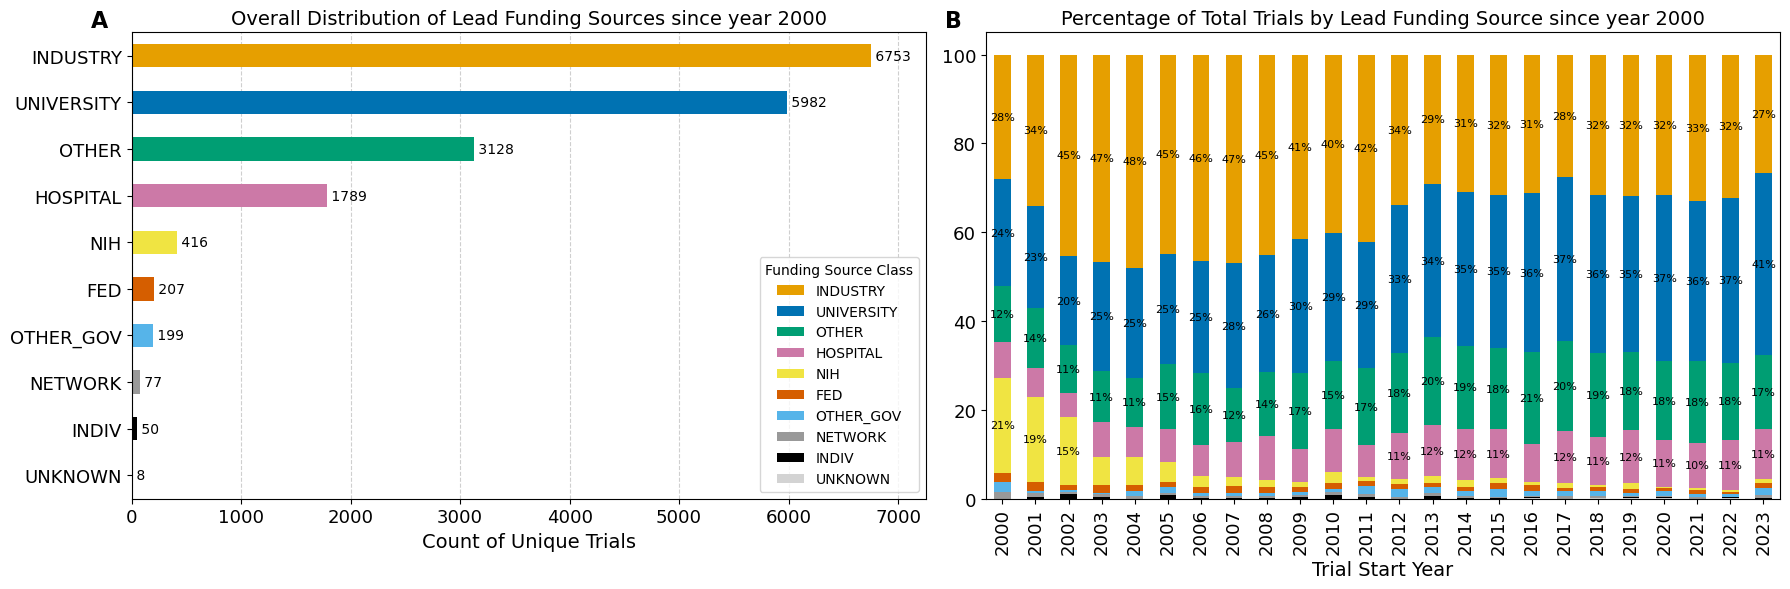

In [389]:
import matplotlib.pyplot as plt

# Assuming df_filtered is already defined and includes 'start_year', 'agency_class', and 'nct_id' columns

# Define color map
labels = ['UNKNOWN', 'INDIV', 'NETWORK', 'OTHER_GOV', 'FED', 'NIH', 'HOSPITAL', 'OTHER', 'UNIVERSITY', 'INDUSTRY']
colors = ['#d3d3d3', '#000000', '#999999', '#56B4E9', '#D55E00', '#F0E442', '#CC79A7', '#009E73', '#0072B2', '#E69F00']
color_map = dict(zip(labels, colors))

default_color = '#FFFFFF'  # White, change as needed

# Creating a pivot table with counts per agency_class and year
pivot_table_counts = df_filtered.pivot_table(index='start_year', columns='agency_class', values='nct_id', aggfunc='count', fill_value=0)
pivot_table_percentage = pivot_table_counts.divide(pivot_table_counts.sum(axis=1), axis=0) * 100
overall_distribution = pivot_table_counts.sum(axis=0).sort_values(ascending=True)

# Reorder pivot table columns to match the order of overall_distribution
pivot_table_counts = pivot_table_counts[overall_distribution.index]
pivot_table_percentage = pivot_table_percentage[overall_distribution.index]

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1 - Overall Distribution (now plot A)
overall_distribution.plot(kind='barh', ax=ax1, color=[color_map.get(x, default_color) for x in overall_distribution.index], zorder=2)
ax1.set_title('Overall Distribution of Lead Funding Sources since year 2000', fontsize=14)
ax1.set_xlabel('Count of Unique Trials', fontsize=14)
ax1.text(-0.03, 1.05, 'A', transform=ax1.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
ax1.set_ylabel('')
ax1.grid(axis='x', linestyle='--', alpha=0.6, zorder=1)

# Adding text labels to the bars
for index, value in enumerate(overall_distribution):
    ax1.text(value, index, f' {int(value)}', va='center', ha='left')
ax1.set_xlim(0, max(overall_distribution) + 500)
ax1.tick_params(axis='both', labelsize=13)  # Increase tick label size

# Plot 2 - Yearly Distribution (now plot B)
pivot_table_percentage.plot(kind='bar', stacked=True, ax=ax2, color=[color_map.get(x, default_color) for x in pivot_table_counts.columns])
ax2.set_title('Percentage of Total Trials by Lead Funding Source since year 2000', fontsize=14)
ax2.set_xlabel('Trial Start Year', fontsize=14)
ax2.legend().set_visible(False)
ax2.tick_params(axis='both', labelsize=13)  # Increase tick label size

ax2.text(-0.03, 1.05, 'B', transform=ax2.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
# Adding text inside the bars
for bars_stack in ax2.containers:
    ax2.bar_label(bars_stack, labels=[f'{v:.0f}%' if v > 10 else '' for v in bars_stack.datavalues], label_type='center', fontsize=8)

# Synchronize legend for both plots
handles, labels = ax2.get_legend_handles_labels()
ax1.legend(handles[::-1], labels[::-1], title='Funding Source Class', loc='lower right')

plt.tight_layout()
plt.savefig(f'viz/trial_characteristics/general/lead_funding_agency_combined_{len(df_filtered)}.pdf')

plt.show()


In [391]:
df_filtered.head()

nct_id  start_year agency_class lead_or_collaborator  \
2285  NCT00000307        2003          NIH                 lead   
2379  NCT00000333        2001          NIH                 lead   
2712  NCT00000428        2000     HOSPITAL                 lead   
2754  NCT00000439        2000          NIH                 lead   
6266  NCT00001956        2000          NIH                 lead   

                                           sponsor_name    phase  \
2285            National Institute on Drug Abuse (NIDA)  Phase 2   
2379            National Institute on Drug Abuse (NIDA)  Phase 2   
2712                               Tufts Medical Center  Phase 4   
2754  National Institute on Alcohol Abuse and Alcoho...  Phase 2   
6266  National Institute of Dental and Craniofacial ...  Phase 2   

     agency_class_v2  
2285             NIH  
2379             NIH  
2712        HOSPITAL  
2754             NIH  
6266             NIH

### Phase/Time/Funding combined

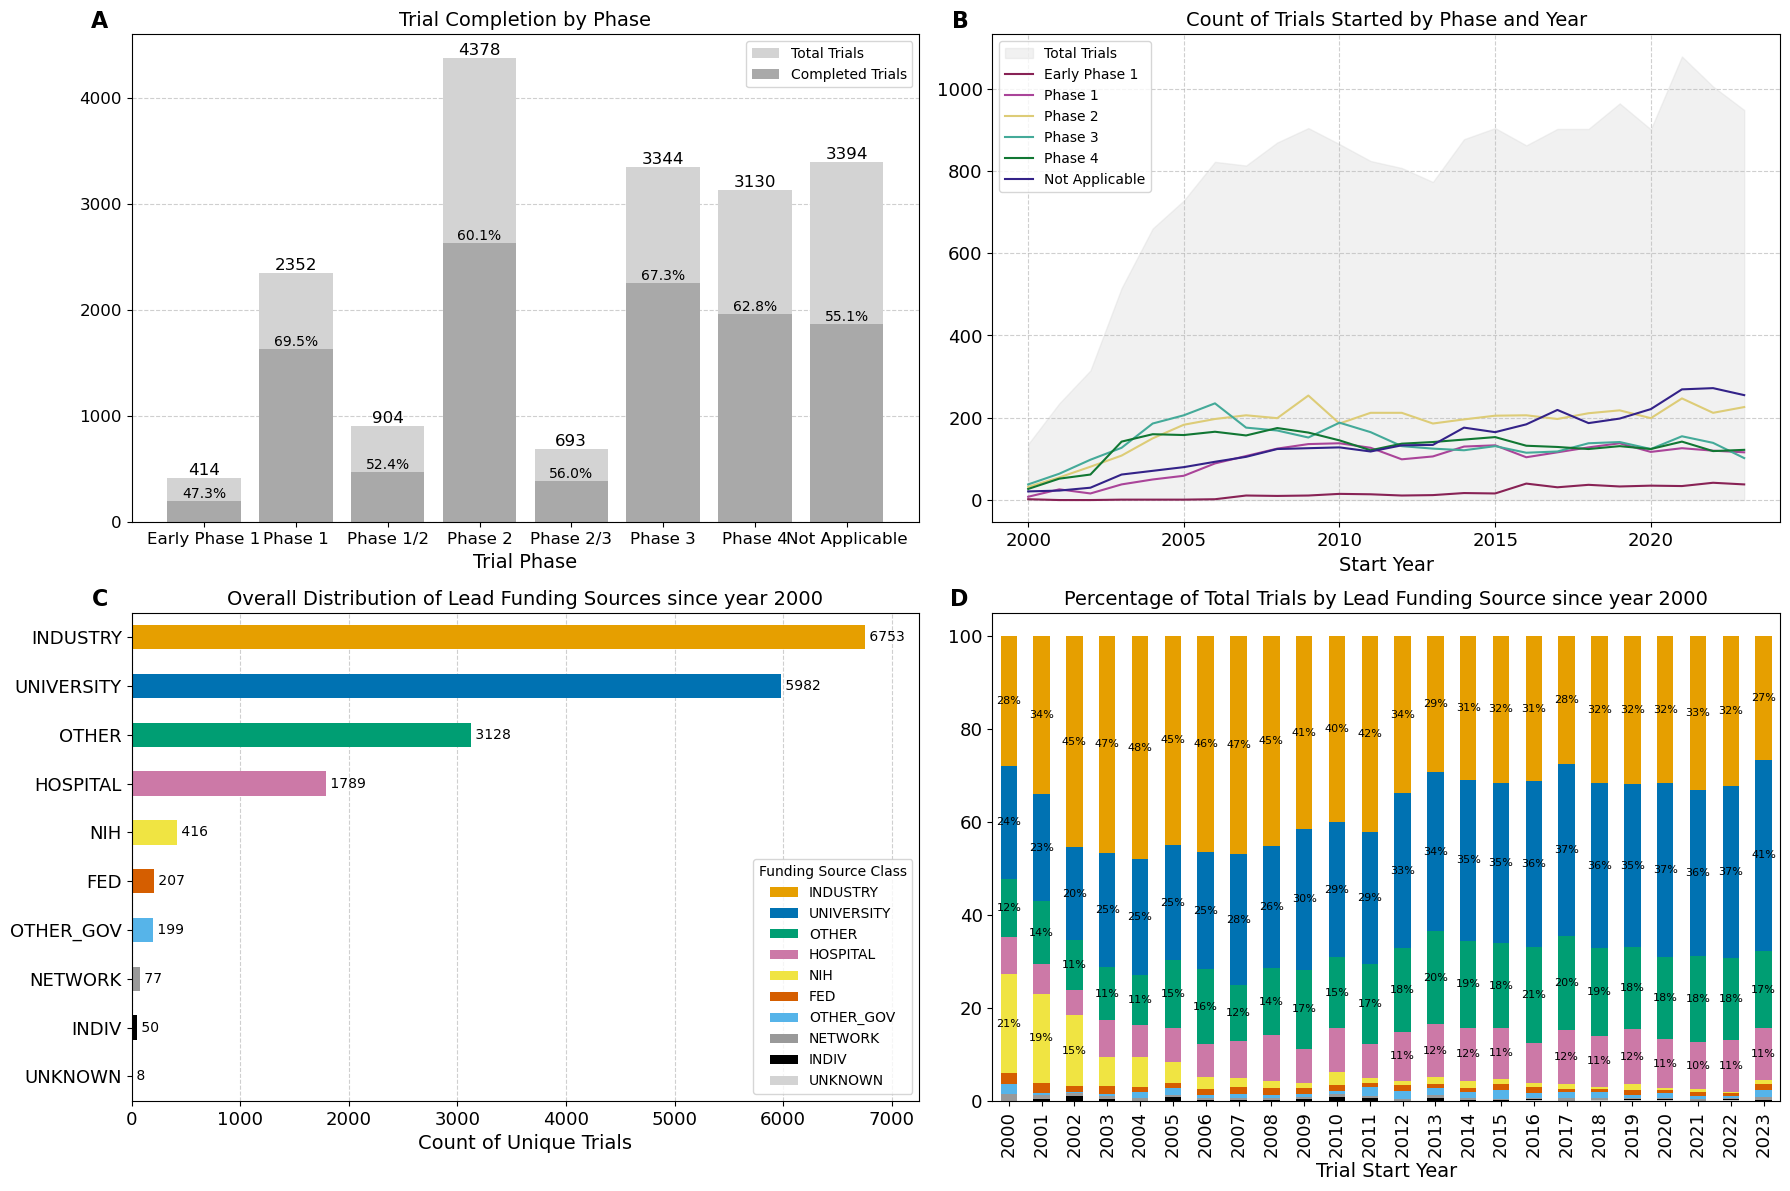

In [394]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming trial_metadata and df_filtered are already loaded and processed

# Define phase order and filter/preprocess the data
phase_order = [
    'Early Phase 1',
    'Phase 1',
    'Phase 1/2',
    'Phase 2',
    'Phase 2/3',
    'Phase 3',
    'Phase 4',
    'Not Applicable'
]

# Define custom colors for each phase
phase_colors = {
    'Early Phase 1': '#882255',
    'Phase 1': '#AA4499',
    'Phase 1/2': '#CC6677',
    'Phase 2': '#DDCC77',
    'Phase 2/3': '#88CCEE',
    'Phase 3': '#44AA99',
    'Phase 4': '#117733',
    'Not Applicable': '#332288'
}

# Filter and count phases and statuses
unique_pairs_phase = trial_metadata[['nct_id', 'phase', 'overall_status']].drop_duplicates()
unique_pairs_phase['phase'] = unique_pairs_phase['phase'].str.replace('/Phase ', '/', regex=False)

phase_type_counts = unique_pairs_phase['phase'].value_counts().reindex(phase_order, fill_value=0)
completed_count = unique_pairs_phase[unique_pairs_phase['overall_status'] == 'Completed']['phase'].value_counts().reindex(phase_order, fill_value=0)
completed_proportion = (completed_count / phase_type_counts * 100).fillna(0)

# Prepare data for the time series plot
filtered_data = trial_metadata[['nct_id', 'phase', 'start_year']][trial_metadata['start_year'] < 2024].drop_duplicates()
trial_counts = filtered_data.groupby(['phase', 'start_year']).size().unstack(fill_value=0)
total_trials_per_year = trial_counts.sum(axis=0)

# Assuming df_filtered is already defined and includes 'start_year', 'agency_class', and 'nct_id' columns

# Define color map for the second set of plots
labels = ['UNKNOWN', 'INDIV', 'NETWORK', 'OTHER_GOV', 'FED', 'NIH', 'HOSPITAL', 'OTHER', 'UNIVERSITY', 'INDUSTRY']
colors = ['#d3d3d3', '#000000', '#999999', '#56B4E9', '#D55E00', '#F0E442', '#CC79A7', '#009E73', '#0072B2', '#E69F00']
color_map = dict(zip(labels, colors))
default_color = '#FFFFFF'  # White, change as needed

# Creating a pivot table with counts per agency_class and year
pivot_table_counts = df_filtered.pivot_table(index='start_year', columns='agency_class', values='nct_id', aggfunc='count', fill_value=0)
pivot_table_percentage = pivot_table_counts.divide(pivot_table_counts.sum(axis=1), axis=0) * 100
overall_distribution = pivot_table_counts.sum(axis=0).sort_values(ascending=True)

# Reorder pivot table columns to match the order of overall_distribution
pivot_table_counts = pivot_table_counts[overall_distribution.index]
pivot_table_percentage = pivot_table_percentage[overall_distribution.index]

# Create subplots - 2 rows and 2 columns
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Plot 1 (Top Left) - Trial Completion by Phase
ax1 = axes[0, 0]
total_bars = ax1.bar(phase_type_counts.index, phase_type_counts, color='lightgrey', zorder=2, label='Total Trials')
completed_bars = ax1.bar(completed_count.index, completed_count, color='darkgrey', zorder=2, label='Completed Trials')

# Label the bars
for bar, prop in zip(completed_bars, completed_proportion):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{prop:.1f}%', ha='center', va='bottom', fontsize=10)
for bar in total_bars:
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{int(bar.get_height())}', ha='center', va='bottom', fontsize=12)

ax1.set_xlabel('Trial Phase', fontsize=14)
ax1.set_title('Trial Completion by Phase', fontsize=14)
ax1.legend()
ax1.grid(axis='y', linestyle='--', alpha=0.6)
ax1.text(-0.03, 1.05, 'A', transform=ax1.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
ax1.tick_params(axis='both', labelsize=12)

# Plot 2 (Top Right) - Trials Over Time by Phase
ax2 = axes[0, 1]
ax2.fill_between(total_trials_per_year.index, total_trials_per_year, color='lightgray', alpha=0.3, label='Total Trials')
for phase in phase_order:
    if phase in trial_counts.index:
        ax2.plot(trial_counts.columns, trial_counts.loc[phase], label=phase, color=phase_colors[phase])

ax2.set_xlabel('Start Year', fontsize=14)
ax2.set_title('Count of Trials Started by Phase and Year', fontsize=14)
ax2.legend(loc='upper left')
ax2.grid(linestyle='--', alpha=0.6, zorder=1)
ax2.set_xticks(np.arange(min(trial_counts.columns), max(trial_counts.columns)+1, 5))
ax2.text(-0.03, 1.05, 'B', transform=ax2.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
ax2.tick_params(axis='both', labelsize=13)

# Plot 3 (Bottom Left) - Overall Distribution of Lead Funding Sources
ax3 = axes[1, 0]
overall_distribution.plot(kind='barh', ax=ax3, color=[color_map.get(x, default_color) for x in overall_distribution.index], zorder=2)
ax3.set_title('Overall Distribution of Lead Funding Sources since year 2000', fontsize=14)
ax3.set_xlabel('Count of Unique Trials', fontsize=14)
ax3.text(-0.03, 1.05, 'C', transform=ax3.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
ax3.set_ylabel('')
ax3.grid(axis='x', linestyle='--', alpha=0.6, zorder=1)
for index, value in enumerate(overall_distribution):
    ax3.text(value, index, f' {int(value)}', va='center', ha='left')
ax3.set_xlim(0, max(overall_distribution) + 500)
ax3.tick_params(axis='both', labelsize=13)

# Plot 4 (Bottom Right) - Percentage of Total Trials by Lead Funding Source
ax4 = axes[1, 1]
pivot_table_percentage.plot(kind='bar', stacked=True, ax=ax4, color=[color_map.get(x, default_color) for x in pivot_table_counts.columns])
ax4.set_title('Percentage of Total Trials by Lead Funding Source since year 2000', fontsize=14)
ax4.set_xlabel('Trial Start Year', fontsize=14)
ax4.legend().set_visible(False)
ax4.tick_params(axis='both', labelsize=13)
ax4.text(-0.03, 1.05, 'D', transform=ax4.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
for bars_stack in ax4.containers:
    ax4.bar_label(bars_stack, labels=[f'{v:.0f}%' if v > 10 else '' for v in bars_stack.datavalues], label_type='center', fontsize=8)

# Synchronize legend for both plots
handles, labels = ax4.get_legend_handles_labels()
ax3.legend(handles[::-1], labels[::-1], title='Funding Source Class', loc='lower right')

# Adjust layout and display the plots
plt.tight_layout()
plt.savefig(f'viz/trial_characteristics/general/phase_funding_combined_plots_{len(unique_pairs_phase)}_{len(df_filtered)}.pdf')
plt.show()


### By Phase

In [399]:
# Filter the data for INDUSTRY and UNIVERSITY
df_filtered_industry_university = df_filtered[df_filtered['agency_class'].isin(['INDUSTRY', 'UNIVERSITY'])]
df_filtered_industry_university['phase'] = df_filtered_industry_university['phase'].str.replace('/Phase ', '/', regex=False)

# Creating a pivot table with counts per phase and agency_class
pivot_table_counts = df_filtered_industry_university.pivot_table(index='phase', columns='agency_class', values='nct_id', aggfunc='count', fill_value=0)

# Calculating the proportions
proportions = pivot_table_counts.div(pivot_table_counts.sum(axis=1), axis=0) * 100
proportions


/var/folders/nd/2fzvhsh510gbt9x6z5pdb1gr0000gn/T/ipykernel_35625/2407182040.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_industry_university['phase'] = df_filtered_industry_university['phase'].str.replace('/Phase ', '/', regex=False)


agency_class     INDUSTRY  UNIVERSITY
phase                                
Early Phase 1   11.157025   88.842975
Not Applicable  10.664683   89.335317
Phase 1         75.959368   24.040632
Phase 1/2       52.142857   47.857143
Phase 2         60.235834   39.764166
Phase 2/3       39.737991   60.262009
Phase 3         79.162073   20.837927
Phase 4         36.487193   63.512807

In [401]:
df_filtered_industry_university[df_filtered_industry_university['phase']=="Phase 4"].to_csv("phase4_trials_by_uni_industry.csv")

/var/folders/nd/2fzvhsh510gbt9x6z5pdb1gr0000gn/T/ipykernel_35625/1088996719.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_industry_university['phase'] = df_filtered_industry_university['phase'].str.replace('/Phase ', '/', regex=False)


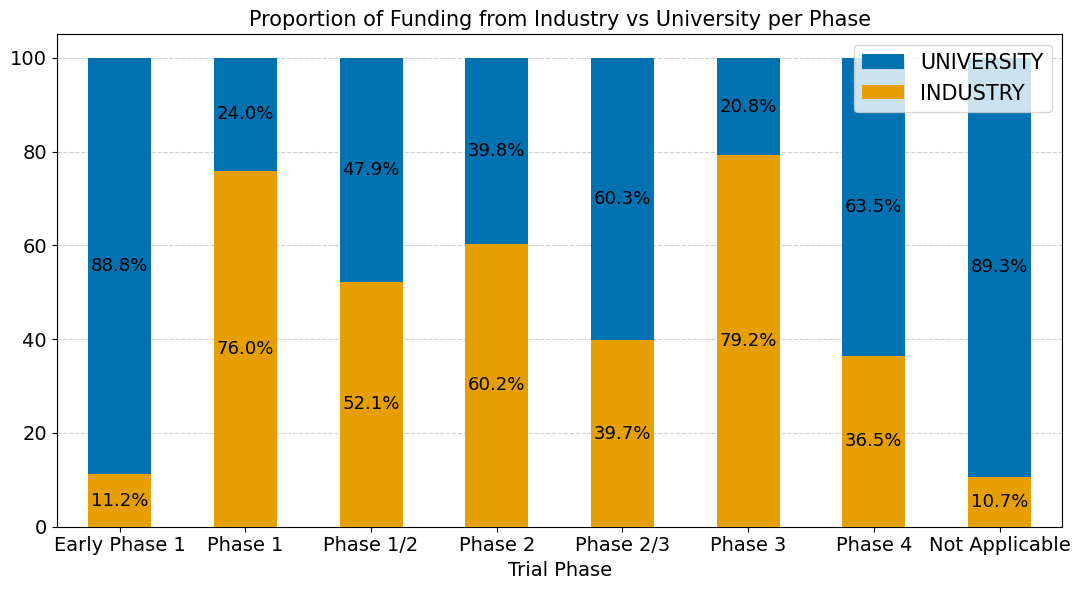

In [403]:
# Filter the data for INDUSTRY and UNIVERSITY
df_filtered_industry_university = df_filtered[df_filtered['agency_class'].isin(['INDUSTRY', 'UNIVERSITY'])]
df_filtered_industry_university['phase'] = df_filtered_industry_university['phase'].str.replace('/Phase ', '/', regex=False)

# Creating a pivot table with counts per phase and agency_class
pivot_table_counts = df_filtered_industry_university.pivot_table(index='phase', columns='agency_class', values='nct_id', aggfunc='count', fill_value=0)

# Reindex to ensure the desired phase order
phase_order = [
    'Early Phase 1', 
    'Phase 1',
    'Phase 1/2',
    'Phase 2', 
    'Phase 2/3', 
    'Phase 3', 
    'Phase 4', 
    'Not Applicable'
]
pivot_table_counts = pivot_table_counts.reindex(phase_order).fillna(0)

# Calculating the proportions
proportions = pivot_table_counts.div(pivot_table_counts.sum(axis=1), axis=0) * 100

# Plotting
fig, ax = plt.subplots(figsize=(11, 6))

# Stacked bar chart
proportions.plot(kind='bar', stacked=True, color=['#E69F00', '#0072B2'], ax=ax, zorder=3)

# Adding title and labels
ax.set_title('Proportion of Funding from Industry vs University per Phase', fontsize=15)
ax.grid(axis='y', linestyle='--', alpha=0.6, zorder=0)
ax.set_xlabel('Trial Phase',fontsize=14)
ax.tick_params(axis='both', labelsize=14)  # Increase tick label size

# Adding legend
#ax.legend( loc='upper right', fontsize=15)
# Adding reversed legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='upper right', fontsize=15)  # Reverse the legend order


# Adding percentage labels inside the bars
for bars in ax.containers:
    ax.bar_label(bars, fmt='%.1f%%', label_type='center', fontsize=13)
plt.xticks(fontsize=14,rotation=0)

plt.tight_layout()
plt.show()

### Lead - Collaborator Matrix

In [406]:
len(set(df_funding['nct_id']))

18609

In [408]:
df_funding = df[['nct_id', 'start_year', 'agency_class', 'lead_or_collaborator', 'sponsor_name', 'phase']].drop_duplicates()
df_funding['agency_class'] = df_funding.apply(replace_agency_class, axis=1)

# Separate lead and collaborator data
leads = df_funding[df_funding['lead_or_collaborator'] == 'lead']
collaborators = df_funding[df_funding['lead_or_collaborator'] == 'collaborator']

# Merge leads with their respective collaborators
merged_df = leads.merge(collaborators, on='nct_id', suffixes=('_lead', '_collaborator'))

merged_df

nct_id  start_year_lead agency_class_lead  \
0      NCT00000307             2003               NIH   
1      NCT00000333             2001               NIH   
2      NCT00000428             2000          HOSPITAL   
3      NCT00000439             2000               NIH   
4      NCT00004268             2001               NIH   
...            ...              ...               ...   
11243  NCT06264427             2022             OTHER   
11244  NCT06264427             2022             OTHER   
11245  NCT06275698             2023         OTHER_GOV   
11246  NCT06275698             2023         OTHER_GOV   
11247  NCT06282640             2021         OTHER_GOV   

      lead_or_collaborator_lead  \
0                          lead   
1                          lead   
2                          lead   
3                          lead   
4                          lead   
...                         ...   
11243                      lead   
11244                      lead   
11245                      lead   
11246                      lead   
11247                      lead   

                                       sponsor_name_lead      phase_lead  \
0                National Institute on Drug Abuse (NIDA)         Phase 2   
1                National Institute on Drug Abuse (NIDA)         Phase 2   
2                                   Tufts Medical Center         Phase 4   
3      National Institute on Alcohol Abuse and Alcoho...         Phase 2   
4          National Center for Research Resources (NCRR)         Phase 2   
...                                                  ...             ...   
11243                    Steno Diabetes Center Greenland  Not Applicable   
11244                    Steno Diabetes Center Greenland  Not Applicable   
11245             East and North Hertfordshire NHS Trust  Not Applicable   
11246             East and North Hertfordshire NHS Trust  Not Applicable   
11247                                       Dr. Ayşe Güç         Phase 4   

       start_year_collaborator agency_class_collaborator  \
0                         2003                UNIVERSITY   
1                         2001                  HOSPITAL   
2                         2000                       NIH   
3                         2000                UNIVERSITY   
4                         2001                  INDUSTRY   
...                        ...                       ...   
11243                     2022                UNIVERSITY   
11244                     2022                UNIVERSITY   
11245                     2023                   UNKNOWN   
11246                     2023                 OTHER_GOV   
11247                     2021                  HOSPITAL   

      lead_or_collaborator_collaborator  \
0                          collaborator   
1                          collaborator   
2                          collaborator   
3                          collaborator   
4                          collaborator   
...                                 ...   
11243                      collaborator   
11244                      collaborator   
11245                      collaborator   
11246                      collaborator   
11247                      collaborator   

                               sponsor_name_collaborator phase_collaborator  
0                                    University of Texas            Phase 2  
1        Washington D.C. Veterans Affairs Medical Center            Phase 2  
2      National Institute of Arthritis and Musculoske...            Phase 4  
3                               University of Pittsburgh            Phase 2  
4                                 Roberts Pharmaceutical            Phase 2  
...                                                  ...                ...  
11243                        Zealand University Hospital     Not Applicable  
11244                           University of Copenhagen     Not Applicable  
11245                               Manuka Doctor UK 

In [409]:
# Calculate collaborator types for INDUSTRY leads
industry_lead_collaborators = merged_df[merged_df['agency_class_lead'] == 'INDUSTRY']['agency_class_collaborator'].value_counts(normalize=True) * 100

# Calculate collaborator types for UNIVERSITY leads
university_lead_collaborators = merged_df[merged_df['agency_class_lead'] == 'UNIVERSITY']['agency_class_collaborator'].value_counts(normalize=True) * 100

# Combine results into a single DataFrame
collaborator_proportions = pd.DataFrame({
    'INDUSTRY lead collaborators (%)': industry_lead_collaborators,
    'UNIVERSITY lead collaborators (%)': university_lead_collaborators
}).fillna(0)

collaborator_proportions

INDUSTRY lead collaborators (%)  \
agency_class_collaborator                                    
AMBIG                                             0.144928   
FED                                               1.086957   
HOSPITAL                                          4.130435   
INDIV                                             0.000000   
INDUSTRY                                         53.695652   
NETWORK                                           1.449275   
NIH                                               4.710145   
OTHER                                            15.217391   
OTHER_GOV                                         0.797101   
UNIVERSITY                                        9.710145   
UNKNOWN                                           9.057971   

                           UNIVERSITY lead collaborators (%)  
agency_class_collaborator                                     
AMBIG                                               0.041152  
FED                                                 2.119342  
HOSPITAL                                           11.975309  
INDIV                                               0.082305  
INDUSTRY                                           16.378601  
NETWORK                                             0.493827  
NIH                                                18.065844  
OTHER                                              16.893004  
OTHER_GOV                                           3.950617  
UNIVERSITY                                         22.860082  
UNKNOWN                                             7.139918

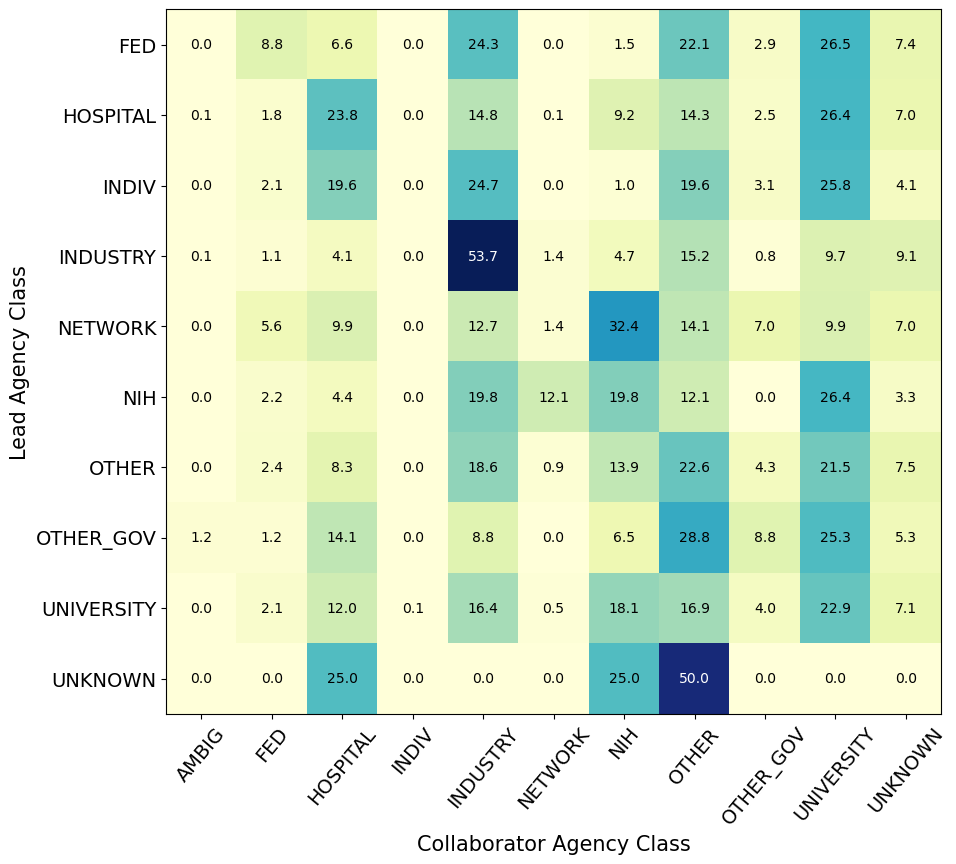

In [412]:
# Separate lead and collaborator data
leads = df_funding[df_funding['lead_or_collaborator'] == 'lead']
collaborators = df_funding[df_funding['lead_or_collaborator'] == 'collaborator']

# Merge leads with their respective collaborators
merged_df = leads.merge(collaborators, on='nct_id', suffixes=('_lead', '_collaborator'))

# Group by lead agency class and collaborator agency class and count occurrences
grouped = merged_df.groupby(['agency_class_lead', 'agency_class_collaborator']).size().reset_index(name='count')

# Pivot the table to get a matrix format
pivot_table = grouped.pivot_table(index='agency_class_lead', columns='agency_class_collaborator', values='count', fill_value=0)

# Normalize the table to get percentages
pivot_table = pivot_table.div(pivot_table.sum(axis=1), axis=0) * 100

# Extract the values into a NumPy matrix
matrix_values = pivot_table.values

# Plot the heatmap using matplotlib
fig, ax = plt.subplots(figsize=(10, 10))
cax = ax.matshow(matrix_values, cmap="YlGnBu")

# Add colorbar
#fig.colorbar(cax, label='Percentage')

# Set axis labels
ax.set_xticks(np.arange(len(pivot_table.columns)))
ax.set_yticks(np.arange(len(pivot_table.index)))
ax.set_xticklabels(pivot_table.columns)
ax.set_yticklabels(pivot_table.index)

# Move x-axis labels to the bottom
ax.xaxis.set_ticks_position('bottom')
ax.xaxis.set_label_position('bottom')
ax.tick_params(axis='both', labelsize=14)  # Increase tick label size


# Rotate the tick labels for better readability
plt.xticks(rotation=50)

# Add the text annotations
for i in range(len(pivot_table.index)):
    for j in range(len(pivot_table.columns)):
        color = 'white' if matrix_values[i, j] > 40 else 'black'
        ax.text(j, i, f'{matrix_values[i, j]:.1f}', ha='center', va='center', color=color)

#plt.title('Heatmap of Lead Agency Class vs Collaborator Agency Class')
plt.xlabel('Collaborator Agency Class', fontsize=15)
plt.ylabel('Lead Agency Class', fontsize=15)

# Show the plot
plt.show()

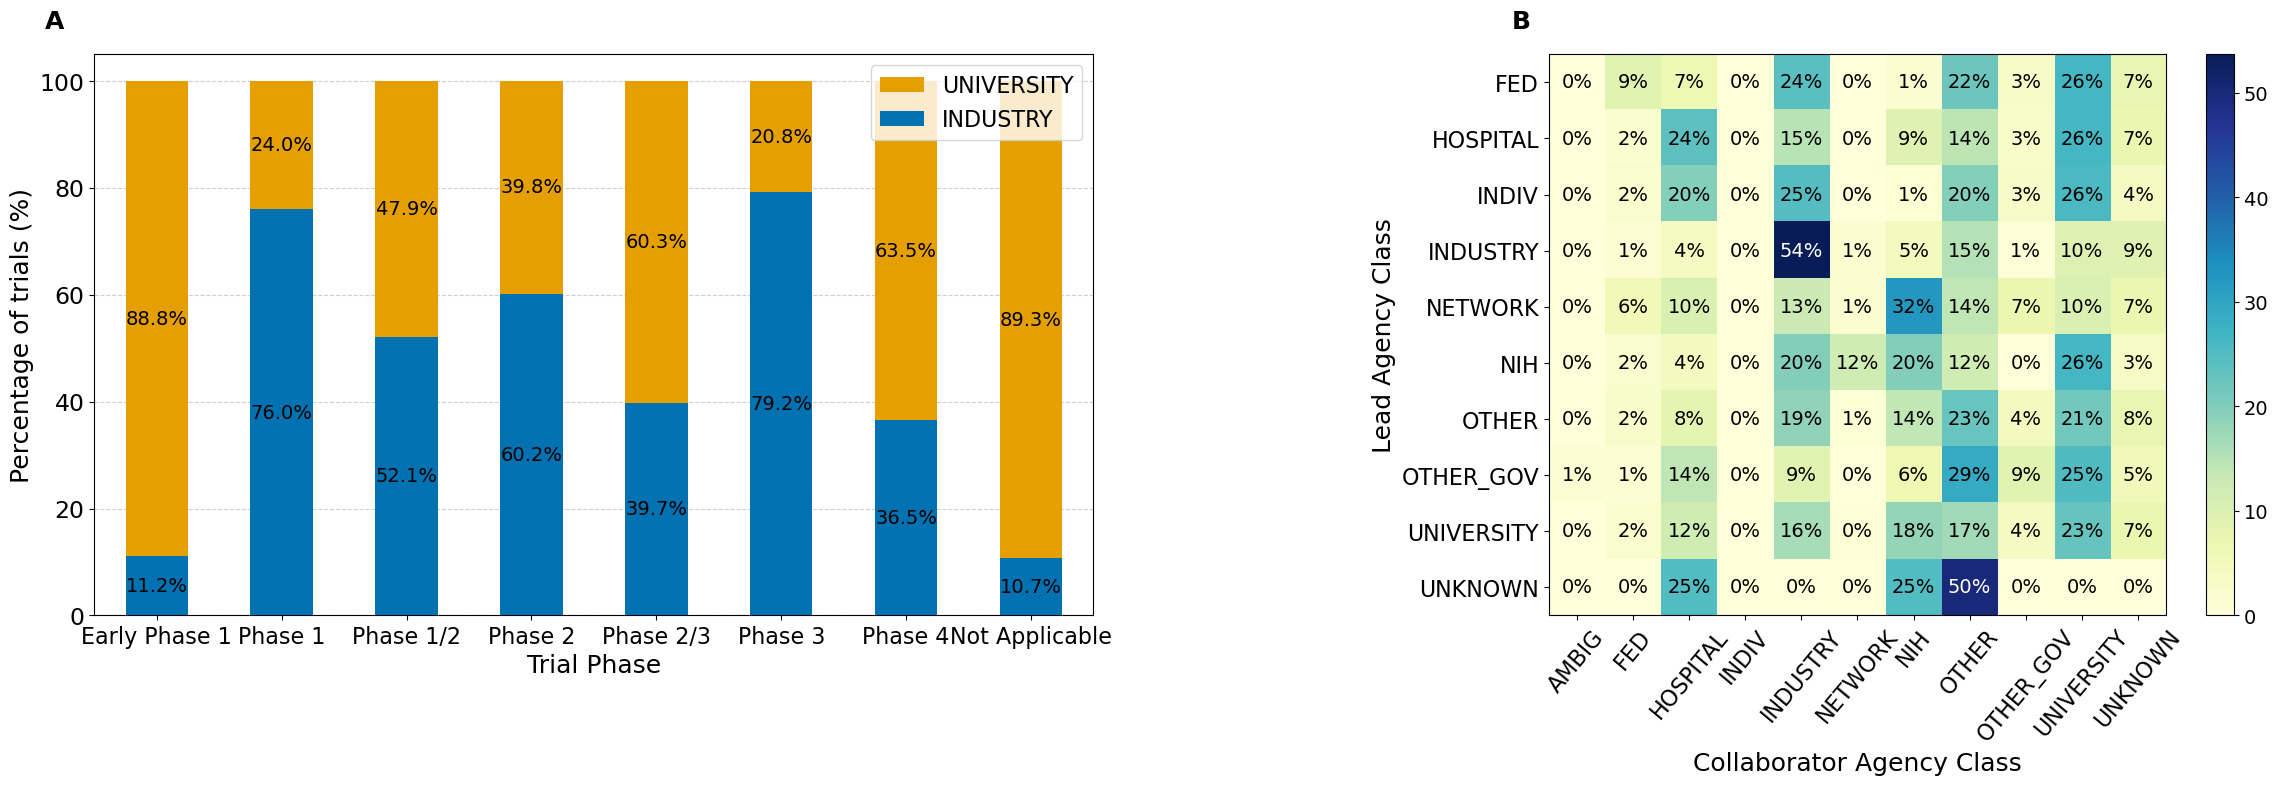

In [414]:
import matplotlib.pyplot as plt
import numpy as np

# Define the figure and the two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(23, 8))

# ---- First Plot: Stacked Bar Chart ----
# Plotting the stacked bar chart
proportions.plot(kind='bar', stacked=True, color=['#0072B2', '#E69F00'], ax=ax1, zorder=3)

# Adding title and labels
#ax1.set_title('Proportion of Funding from Industry vs University per Phase', fontsize=15)
ax1.grid(axis='y', linestyle='--', alpha=0.6, zorder=0)
ax1.set_xlabel('Trial Phase', fontsize=18)
ax1.set_ylabel('Percentage of trials (%)', fontsize=18)

ax1.tick_params(axis='both', labelsize=17)  # Increase tick label size

# Adding reversed legend
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[::-1], labels[::-1], loc='upper right', fontsize=16)  # Reverse the legend order

# Adding percentage labels inside the bars
for bars in ax1.containers:
    ax1.bar_label(bars, fmt='%.1f%%', label_type='center', fontsize=14)
ax1.set_xticks(np.arange(len(phase_order)))
ax1.set_xticklabels(phase_order, fontsize=16, rotation=0)

# ---- Second Plot: Heatmap ----
# Plot the heatmap using matplotlib
cax = ax2.matshow(matrix_values, cmap="YlGnBu")

# Set axis labels
ax2.set_xticks(np.arange(len(pivot_table.columns)))
ax2.set_yticks(np.arange(len(pivot_table.index)))
ax2.set_xticklabels(pivot_table.columns, fontsize=16, rotation=50)
ax2.set_yticklabels(pivot_table.index, fontsize=16)

# Move x-axis labels to the bottom
ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')

# Add the text annotations
for i in range(len(pivot_table.index)):
    for j in range(len(pivot_table.columns)):
        #if matrix_values[i, j] < 1:
           # continue
        color = 'white' if matrix_values[i, j] > 40 else 'black'
        ax2.text(j, i, f'{matrix_values[i, j]:.0f}%', ha='center', va='center', color=color, fontsize=14)

ax2.set_xlabel('Collaborator Agency Class', fontsize=18)
ax2.set_ylabel('Lead Agency Class', fontsize=18)
#ax2.set_title('Proportion of Collaborations for Lead Funding Agencies', fontsize=16)

ax2.text(-0.03, 1.08, 'B', transform=ax2.transAxes, fontsize=18, fontweight='bold', va='top', ha='right')
ax1.text(-0.03, 1.08, 'A', transform=ax1.transAxes, fontsize=18, fontweight='bold', va='top', ha='right')

# Add colorbar for the heatmap
cbar = fig.colorbar(cax, ax=ax2, fraction=0.046, pad=0.04)
#cbar.set_label('Percentage', fontsize=14)
cbar.ax.tick_params(labelsize=14)

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure if needed
plt.savefig('viz/trial_characteristics/general/funding_per_phase_and_lead_collaboration_details.pdf')

# Show the combined plot
plt.show()


In [460]:
#merged_df
industry_leads_collaborators = merged_df[
    (merged_df['agency_class_lead'] == 'INDUSTRY') & 
    (merged_df['agency_class_collaborator'] == 'INDUSTRY')
]
industry_leads_collaborators

nct_id  start_year_lead agency_class_lead  \
227    NCT00021723             2001          INDUSTRY   
234    NCT00027300             2001          INDUSTRY   
254    NCT00030966             2002          INDUSTRY   
269    NCT00036361             2002          INDUSTRY   
279    NCT00040404             2002          INDUSTRY   
...            ...              ...               ...   
11456  NCT06079190             2023          INDUSTRY   
11475  NCT06101173             2023          INDUSTRY   
11476  NCT06114329             2023          INDUSTRY   
11483  NCT06128564             2023          INDUSTRY   
11516  NCT06225115             2023          INDUSTRY   

      lead_or_collaborator_lead  \
227                        lead   
234                        lead   
254                        lead   
269                        lead   
279                        lead   
...                         ...   
11456                      lead   
11475                      lead   
11476                      lead   
11483                      lead   
11516                      lead   

                                       sponsor_name_lead       phase_lead  \
227    JANSSEN Alzheimer Immunotherapy Research & Dev...          Phase 2   
234                                               Biogen          Phase 3   
254                                               Biogen          Phase 3   
269    Otsuka Pharmaceutical Development & Commercial...          Phase 3   
279                                             Cephalon  Phase 2/Phase 3   
...                                                  ...              ...   
11456                                    GlaxoSmithKline          Phase 2   
11475                             CanSino Biologics Inc.          Phase 1   
11476                         AceLink Therapeutics, Inc.          Phase 2   
11483                                  Hoffmann-La Roche          Phase 2   
11516                                       Kynexis B.V.          Phase 1   

       start_year_collaborator agency_class_collaborator  \
227                       2001                  INDUSTRY   
234                       2001                  INDUSTRY   
254                       2002                  INDUSTRY   
269                       2002                  INDUSTRY   
279                       2002                  INDUSTRY   
...                        ...                       ...   
11456                     2023                  INDUSTRY   
11475                     2023                  INDUSTRY   
11476                     2023                  INDUSTRY   
11483                     2023                  INDUSTRY   
11516                     2023                  INDUSTRY   

      lead_or_collaborator_collaborator  \
227                        collaborator   
234                        collaborator   
254                        collaborator   
269                        collaborator   
279                        collaborator   
...                                 ...   
11456                      collaborator   
11475                      collaborator   
11476                      collaborator   
11483                      collaborator   
11516                      collaborator   

                              sponsor_name_collaborator phase_collaborator  
227    Wyeth is now a wholly owned subsidiary of Pfizer            Phase 2  
234                                Elan Pharmaceuticals            Phase 3  
254                                Elan Pharmaceuticals            Phase 3  
269                       Otsuka America Pharmaceutical            Phase 3  
279                                     H. Lundbeck A/S    Phase 2/Phase 3  
...                                                 ...                ...  
11456                                      Alector Inc.            Phase 2  
11475                  Novotech (Australia) Pty Limited            Phase 1  
11476                      Tigermed Consulting Co.

In [80]:
# Function to concatenate columns into a comma-separated string after sorting them alphabetically
def combine_and_sort_columns(series):
    return ', '.join(sorted(series.unique()))

# Grouping by 'nct_id' and aggregating
grouped_df = df.groupby('nct_id').agg({
    'start_year': 'first',  # Assuming start year is the same for duplicated nct_id, just take the first
    'agency_class': combine_and_sort_columns,  # Sorted alphabetically
    'lead_or_collaborator': combine_and_sort_columns,
    'sponsor_name': combine_and_sort_columns
}).reset_index()

grouped_df


nct_id  start_year agency_class lead_or_collaborator  \
0      NCT00000117        1995          NIH                 lead   
1      NCT00000146        1988          NIH                 lead   
2      NCT00000147        1988          NIH                 lead   
3      NCT00000151        1979          NIH                 lead   
4      NCT00000170        1999   NIH, OTHER   collaborator, lead   
...            ...         ...          ...                  ...   
19055  NCT06282640        2021    OTHER_GOV   collaborator, lead   
19056  NCT06287502        2022        OTHER                 lead   
19057  NCT06289335        2020        OTHER                 lead   
19058  NCT06292351        2023     INDUSTRY                 lead   
19059  NCT06293586        2023        OTHER                 lead   

                                            sponsor_name  
0                           National Eye Institute (NEI)  
1                           National Eye Institute (NEI)  
2                           National Eye Institute (NEI)  
3                           National Eye Institute (NEI)  
4      Jaeb Center for Health Research, National Eye ...  
...                                                  ...  
19055                Dr. Ayşe Güç, Kayseri City Hospital  
19056                        Kowloon Hospital, Hong Kong  
19057      Hospital Central "Dr. Ignacio Morones Prieto"  
19058                                       Bigespas LTD  
19059                                   Cairo University  

[19060 rows x 5 columns]

In [81]:
set(grouped_df['agency_class'])

{'AMBIG, INDUSTRY',
 'AMBIG, INDUSTRY, OTHER, UNKNOWN',
 'AMBIG, OTHER',
 'AMBIG, OTHER_GOV',
 'FED',
 'FED, INDIV',
 'FED, INDIV, OTHER',
 'FED, INDUSTRY',
 'FED, INDUSTRY, NETWORK',
 'FED, INDUSTRY, NETWORK, NIH, OTHER',
 'FED, INDUSTRY, NETWORK, OTHER',
 'FED, INDUSTRY, NIH',
 'FED, INDUSTRY, NIH, OTHER',
 'FED, INDUSTRY, NIH, OTHER, OTHER_GOV',
 'FED, INDUSTRY, OTHER',
 'FED, INDUSTRY, OTHER, UNKNOWN',
 'FED, INDUSTRY, UNKNOWN',
 'FED, NETWORK',
 'FED, NETWORK, OTHER',
 'FED, NIH',
 'FED, NIH, OTHER',
 'FED, NIH, OTHER, OTHER_GOV',
 'FED, OTHER',
 'FED, OTHER, OTHER_GOV',
 'FED, OTHER, UNKNOWN',
 'FED, OTHER_GOV',
 'FED, UNKNOWN',
 'INDIV',
 'INDIV, INDUSTRY',
 'INDIV, INDUSTRY, OTHER',
 'INDIV, NIH, OTHER, UNKNOWN',
 'INDIV, OTHER',
 'INDIV, OTHER, OTHER_GOV',
 'INDIV, OTHER, OTHER_GOV, UNKNOWN',
 'INDIV, UNKNOWN',
 'INDUSTRY',
 'INDUSTRY, NETWORK',
 'INDUSTRY, NETWORK, NIH',
 'INDUSTRY, NETWORK, NIH, OTHER',
 'INDUSTRY, NETWORK, OTHER',
 'INDUSTRY, NETWORK, OTHER, OTHER_GOV',
 'I